In [1]:
## First import general packages for running python analysis:
import os, h5py, datetime,pytz
import numpy as np
from matplotlib.pyplot import *
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm
import pickle, glob, yaml, string
from matplotlib import cm

from scipy.interpolate import griddata
import scipy.optimize as opt
from scipy.optimize import curve_fit
from scipy.optimize import leastsq
from scipy.optimize import least_squares
from scipy.stats import binned_statistic_2d

from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm
from matplotlib.ticker import MultipleLocator

## Then import the beamcals module packages and initialize 'gbosite' class:
from beamcals import corr
from beamcals import concat
from beamcals import drone
from beamcals import bicolog
import beamcals.plotting_utils as pu
import beamcals.fitting_utils as fu
import beamcals.geometry_utils as gu
import beamcals.time_utils as tu
from beamcals import beammap as bp
import beamcals.beam_autoprocessing as ba
from beamcals.sites import site
import beamcals.reduce_ccclass as rc

gbosite=site.site('../beamcals/beamcals/sites/GBO_config.npz')

# various gridding attempts
import pykrige.kriging_tools as kt
from pykrige.ok import OrdinaryKriging

freqs = 800.0*np.ones(1024) + (-400/1024.)*np.arange(1024)

fitdir='/hirax/GBO_Analysis_Outputs/main_beam_fits/'
ymldir = '/hirax/GBO_Analysis_Outputs/concat_config_files/'
pckldir = '/hirax/GBO_Analysis_Outputs/flight_pickles/'
ampdir = '/hirax/GBO_Analysis_Outputs/amplitude_corrections/'
beamdir = '/hirax/GBO_Analysis_Outputs/beam_pickles/'
polbeamdir = '/hirax/GBO_Analysis_Outputs/beam_pickles_polar/'

In [2]:
def get_flightinfo(fly):   
    with open('/hirax/GBO_Analysis_Outputs/GBO_flights_forscripts.yaml', 'r') as fff:
        documents = yaml.safe_load(fff)
    flights = documents["flight_info"]["flights"]
    
    for fi in range(0,len(documents["flight_info"]["flights"])):
        if fly == flights[fi]: f = fi
    
    if polarn[f]=='N':
        pols = N_pols
        cpols = E_pols
    else:
        pols = E_pols
        cpols = N_pols
    return polarn[f], pols, cpols, attns[f], f

def get_beam_diff(beam2, beam1,n):
    return beam2[:,:] - n*beam1[:,:]

def get_stat(new_d,whstat='stddev'): # default is stddev
    diff_flat = np.ndarray.flatten(new_d)
    if whstat=='stddev':
        stat = np.nanstd(diff_flat)
    elif whstat=='median':
        # compute median
        stat = np.abs(np.nanmedian(diff_flat))
    elif whstat=='sum':
        stat = np.nanmean(np.abs(diff_flat))
    elif whstat=='mednoabs':
        stat = np.nanmedian(diff_flat)
    return stat

def get_slice_xy(xes,yes,val,ax='x'):
    tol = 1.5
    if ax=='x':
        col = np.where((xes < val+tol) & (xes > val-tol))[0]
    if ax=='y':
        col = np.where((yes < val+tol) & (yes > val-tol))[0]
    return col


def get_slice(X,Y,Z,val, sliceOrientation='h'):
    # this gradually increases the tolerance until it finds something
    ok = True
    
    if sliceOrientation=='h': 
        tol = abs(Y[0,1] - Y[0,0])/2.0
    else:
        tol = abs(X[1,0] - X[0,0])/2.0
        
    while(ok):
        if sliceOrientation=='h': #keeping the y value constant and changing the x value  
            sliceIndex = np.where((Y[0,:] < (val + tol)) & (Y[0,:] > (val-tol)))[0]
            if len(sliceIndex>1): sliceIndex = sliceIndex[0]
            n = np.count_nonzero(np.isfinite(Z[:,sliceIndex])) #count number of 'good' data 
            if n > 10: 
                ok = False
            else: 
                ok = True 
        if sliceOrientation=='v': #keeping the x value constant and changing the y value 
            sliceIndex = np.where((X[:,0] < (val+tol)) & (X[:,0] > (val-tol)))[0]
            if len(sliceIndex>1): sliceIndex = sliceIndex[0]
            n = np.count_nonzero(np.isfinite(Z[sliceIndex,:])) #count number of 'good' data
            if n > 10: ok = False
            else: 
                ok = True
        tol+=1
        if tol > 30: ok = False
    return sliceIndex


def get_concatlist(flights):
    #for i, fly in enumerate(flights):
    pickle_directory='/hirax/GBO_Analysis_Outputs/flight_pickles/'
    concytest=[glob.glob(pickle_directory+'*'+fly+'*')[0] for fly in flights]
    return concytest

def convert_to_angle(d):
    h = 177.0 # meters
    aa = np.arctan(d/h)
    return np.degrees(aa)

def convert_sig_to_FWHM(sig):
    return 2.355*sig


def m_to_FWHM(d):
    angle = convert_to_angle(d)
    return convert_sig_to_FWHM(angle)

def FWHM_to_m(angle):
    sig = fwhm/2.355
    h = 177.0 # meters
    return h*np.tan(np.radians(sig))

# What should I use for the FWHM of a diffraction limited telescope?

## Use 1.03 for diffraction limit for FWHM, from 
# https://www.telescope-optics.net/telescope_resolution.htm

def get_diffrac(fs):
    D = 6.0
    lam = 3E8 / (fs*1E6) # lambda in meters
    return np.degrees(np.arcsin(1.03 * lam / D)) 

In [3]:
with open('/hirax/GBO_Analysis_Outputs/GBO_flights_forscripts.yaml', 'r') as fff:
    documents = yaml.safe_load(fff)
flights = documents["flight_info"]["flights"]
N_pols = documents["flag_info"]["N_pols"]
E_pols = documents["flag_info"]["E_pols"]
polarn = documents["flight_info"]["pols"]
attns = documents["flight_info"]["attns"]
masks = documents["flight_info"]["masks"]
good_freqs = documents["freq_info"]["good_freqs"]

pcklarr=np.sort(os.listdir(pckldir))
gfitarr=np.sort(os.listdir(fitdir))
amparr=np.sort(os.listdir(ampdir))
print(gfitarr,amparr)


# SLICE DEFAULTS # 
sliw = 10 # This defines slices for (some) plots
sz = 80 # use this to set the size of the Xargs and Yargs for beammapping, usually 80 or 50

# PLOTTING DEFAULT # 
cmap = matplotlib.cm.get_cmap('gnuplot2')
norm = matplotlib.colors.Normalize(vmin=-25, vmax=25)
sfig = False
ccm = cm.magma

Npolflights = ['618','619','625','646','647','533']
Epolflights = ['620','648','649','535']

# after looking through the slices and being very picky
#good_freqs =  [538, 553, 554,
#       556, 557, 558, 559, 560, 561, 562, 563, 564, 565, 566, 568, 569,
#       571, 572, 575, 576, 577, 578, 579, 580, 581, 584, 630, 631, 632,
#       633, 636, 639, 645, 676, 691, 692, 695, 696, 697, 698, 699, 700,
#       702, 703, 705, 706, 707, 719, 720, 768, 799, 801, 802, 803,
#       805, 807, 808, 810, 811, 814, 845, 846, 847, 848, 849, 851, 852,
#       853, 854, 855, 856, 857, 858, 860, 861, 862, 863, 864, 865, 866,
#       867, 869, 871, 872, 873, 874, 875, 876, 877, 878, 879, 880, 881,
#       883, 884, 885, 887, 888, 890, 891, 892, 895, 896, 899, 900, 902,
#       903, 904, 905, 907, 908, 909, 910, 911, 912, 913, 914, 915, 916,
#       917, 918, 919, 921, 922, 923, 924, 925, 926, 928, 929, 930, 931,
#       932, 933, 935, 936, 937, 938, 939]

['FLY533_20210826T182904Z_2dGauss_and_Airy_Params.npz'
 'FLY534_20210826T185621Z_2dGauss_and_Airy_Params.npz'
 'FLY535_20210826T192056Z_2dGauss_and_Airy_Params.npz'
 'FLY618_20211021T183430Z_2dGauss_and_Airy_Params.npz'
 'FLY619_20211021T185805Z_2dGauss_and_Airy_Params.npz'
 'FLY620_20211021T192212Z_2dGauss_and_Airy_Params.npz'
 'FLY623_20211021T203206Z_2dGauss_and_Airy_Params.npz'
 'FLY625_20211021T214028Z_2dGauss_and_Airy_Params.npz'
 'FLY646_20211022T183659Z_2dGauss_and_Airy_Params.npz'
 'FLY647_20211022T185749Z_2dGauss_and_Airy_Params.npz'
 'FLY648_20211022T191922Z_2dGauss_and_Airy_Params.npz'
 'FLY649_20211022T194308Z_2dGauss_and_Airy_Params.npz'] ['FLY533_Corrected_amplitudes.pkl' 'FLY534_Corrected_amplitudes.pkl'
 'FLY535_Corrected_amplitudes.pkl' 'FLY618_Corrected_amplitudes.pkl'
 'FLY619_Corrected_amplitudes.pkl' 'FLY620_Corrected_amplitudes.pkl'
 'FLY623_Corrected_amplitudes.pkl' 'FLY625_Corrected_amplitudes.pkl'
 'FLY646_Corrected_amplitudes.pkl' 'FLY647_Corrected_amplitudes

# Let's check if we should be normalizing by the offset+amplitude, instead of just amplitude

<ipython-input-4-ae272a6cf35a>:26: RuntimeWarning: invalid value encountered in true_divide
  fact = (fits['G_popt'][chind,:,0]+fits['G_popt'][chind,:,5])/fits['G_popt'][chind,:,0]


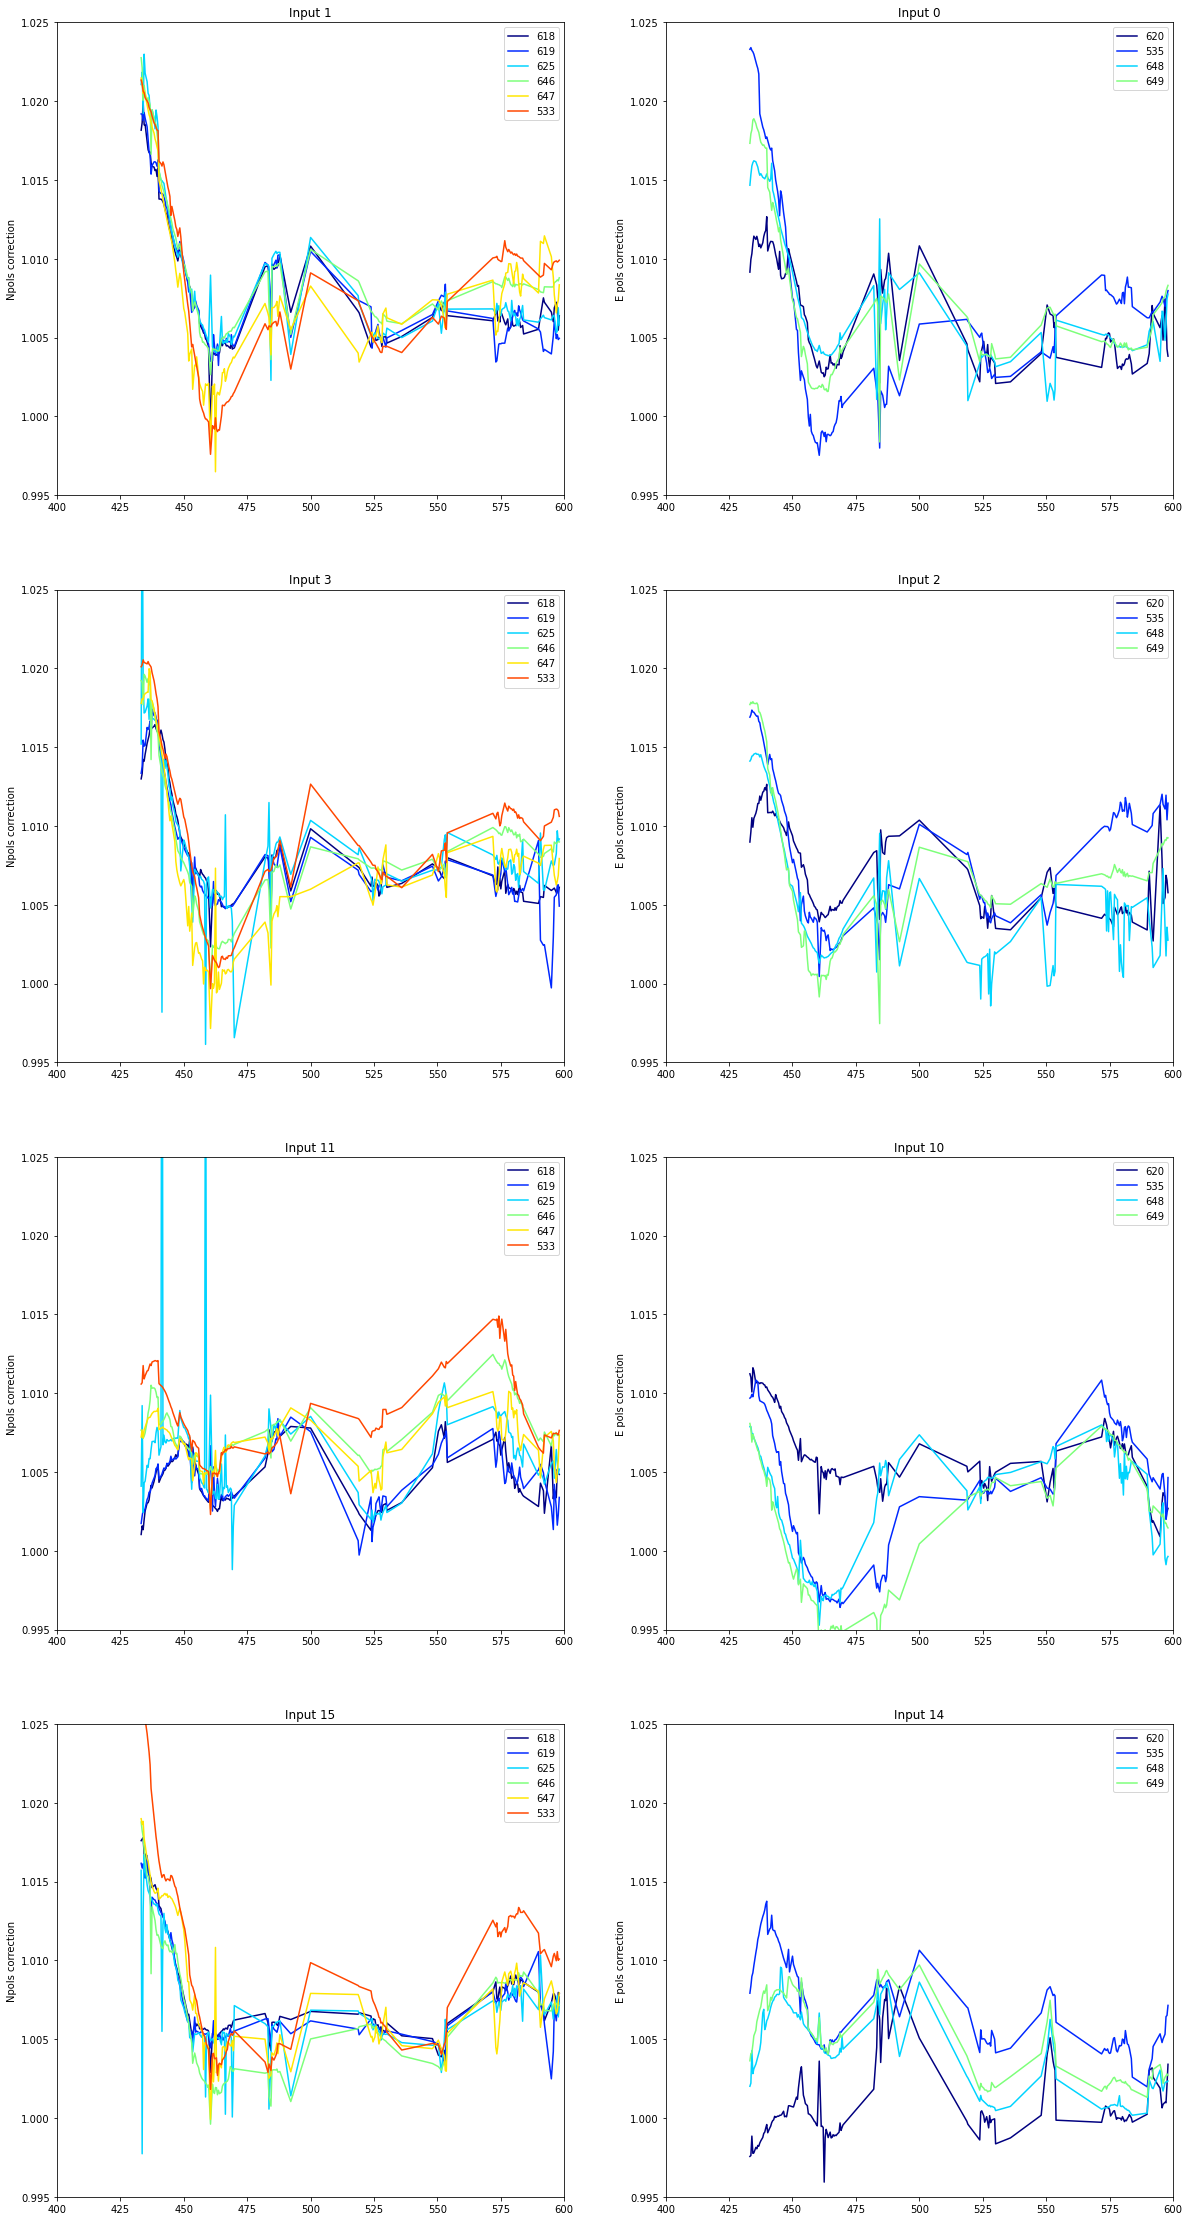

<ipython-input-4-ae272a6cf35a>:61: RuntimeWarning: invalid value encountered in true_divide
  fact = fits['G_popt'][chind,:,0]/(fits['G_popt'][chind,:,0]+fits['G_popt'][chind,:,5])


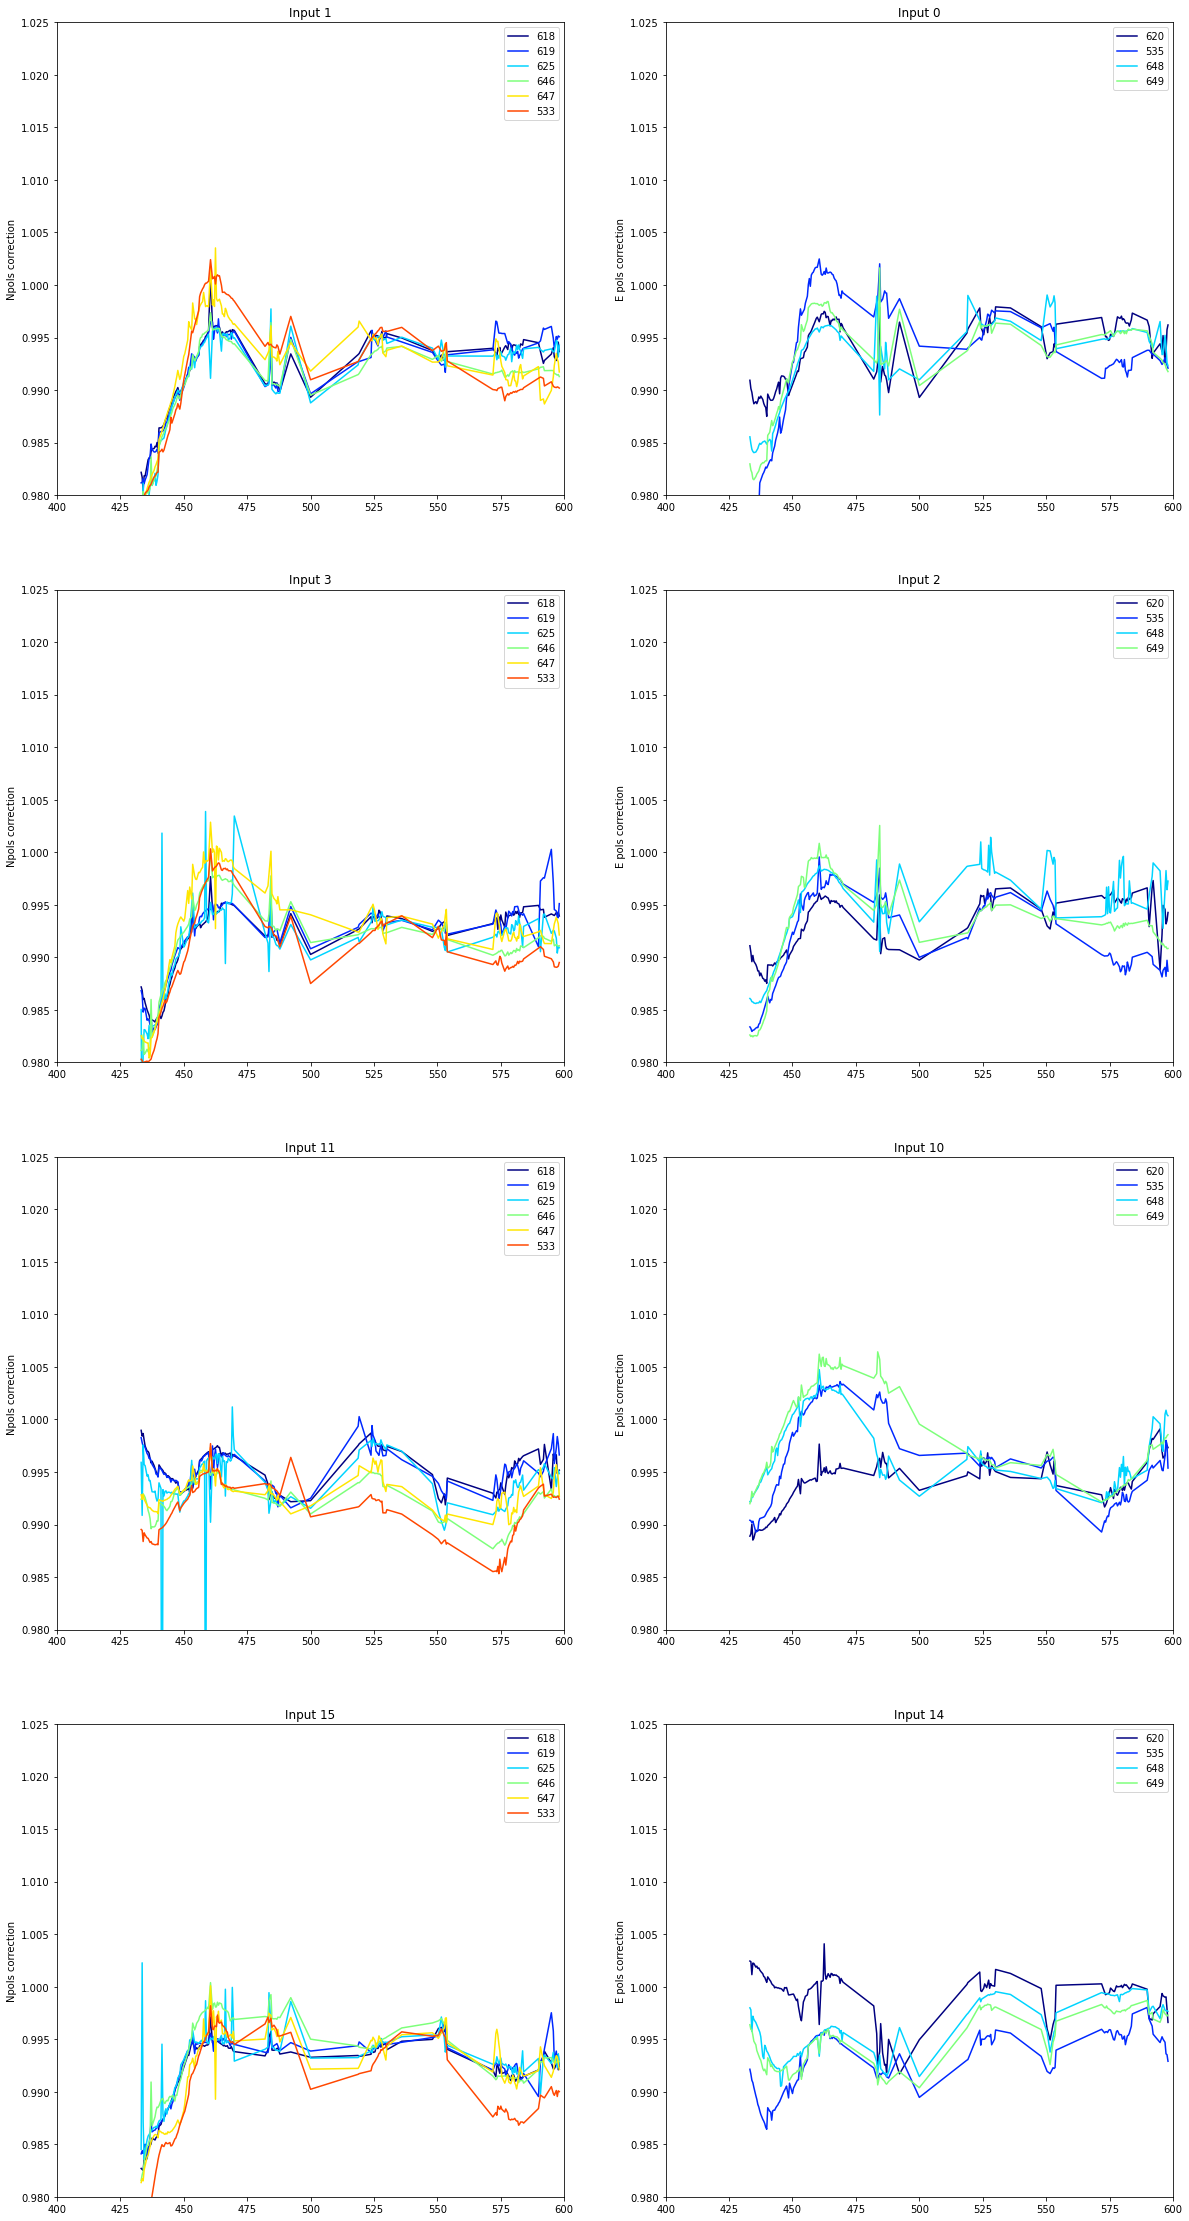

In [4]:
## Understand how much shift to expect if I normalize by 
# amp+off instead of just amp:

flies = ['618','619','625','646', '647','533']
colorf=pu.cm_to_discrete(cm.jet, 6)

fig,axs = plt.subplots(4,2,figsize=(20,40))
for f,fly in enumerate(flies):
        ffile = glob.glob(fitdir+'*'+fly+'*')[0]
        fits = np.load(ffile)
        for i,chind in enumerate(N_pols):
            fact = (fits['G_popt'][chind,:,0]+fits['G_popt'][chind,:,5])/fits['G_popt'][chind,:,0]
            axs[i,0].plot(freqs[good_freqs],fact[good_freqs],color=colorf[f],label=fly)
            axs[i,0].set_ylabel('Npols correction')
            axs[i,0].set_title('Input '+str(chind))
            axs[i,0].legend()
            axs[i,0].set_xlim(400,600)
            axs[i,0].set_ylim(0.995,1.025)

flies = ['620','535','648','649']

for f,fly in enumerate(flies):
        ffile = glob.glob(fitdir+'*'+fly+'*')[0]
        fits = np.load(ffile)
        for i,chind in enumerate(E_pols):
            fact = (fits['G_popt'][chind,:,0]+fits['G_popt'][chind,:,5])/fits['G_popt'][chind,:,0]
            axs[i,1].plot(freqs[good_freqs],fact[good_freqs],color=colorf[f],label=fly)
            axs[i,1].set_ylabel('E pols correction')
            axs[i,1].set_title('Input '+str(chind))
            axs[i,1].legend()
            axs[i,1].set_xlim(400,600)
            axs[i,1].set_ylim(0.995,1.025)
plt.show()


## Understand how much shift to expect if I normalize by 
# amp+off instead of just amp:

flies = ['618','619','625','646', '647','533']
colorf=pu.cm_to_discrete(cm.jet, 6)

fig,axs = plt.subplots(4,2,figsize=(20,40))
for f,fly in enumerate(flies):
        ffile = glob.glob(fitdir+'*'+fly+'*')[0]
        fits = np.load(ffile)
        for i,chind in enumerate(N_pols):
            fact = fits['G_popt'][chind,:,0]/(fits['G_popt'][chind,:,0]+fits['G_popt'][chind,:,5])
            axs[i,0].plot(freqs[good_freqs],fact[good_freqs],color=colorf[f],label=fly)
            axs[i,0].set_ylabel('Npols correction')
            axs[i,0].set_title('Input '+str(chind))
            axs[i,0].legend()
            axs[i,0].set_xlim(400,600)
            axs[i,0].set_ylim(0.98,1.025)

flies = ['620','535','648','649']

for f,fly in enumerate(flies):
        ffile = glob.glob(fitdir+'*'+fly+'*')[0]
        fits = np.load(ffile)
        for i,chind in enumerate(E_pols):
            fact = fits['G_popt'][chind,:,0]/(fits['G_popt'][chind,:,0]+fits['G_popt'][chind,:,5])
            axs[i,1].plot(freqs[good_freqs],fact[good_freqs],color=colorf[f],label=fly)
            axs[i,1].set_ylabel('E pols correction')
            axs[i,1].set_title('Input '+str(chind))
            axs[i,1].legend()
            axs[i,1].set_xlim(400,600)
            axs[i,1].set_ylim(0.98,1.025)
plt.show()
 # pretty small potatoes change. Can use but this won't shift anything much

In [6]:
coadded_old = np.load('/hirax/GBO_Analysis_Outputs/Coadded_2dGauss_and_Airy_Param_w_errs_02_28_2024.npz')
coadded = np.load('/hirax/GBO_Analysis_Outputs/Coadded_2dGauss_and_Airy_Param_w_errs_03_09_2024.npz')
list(coadded.keys())
#print(coadded['G_popt'][1,900,:,0]) # ch,fr,param



['G_popt']

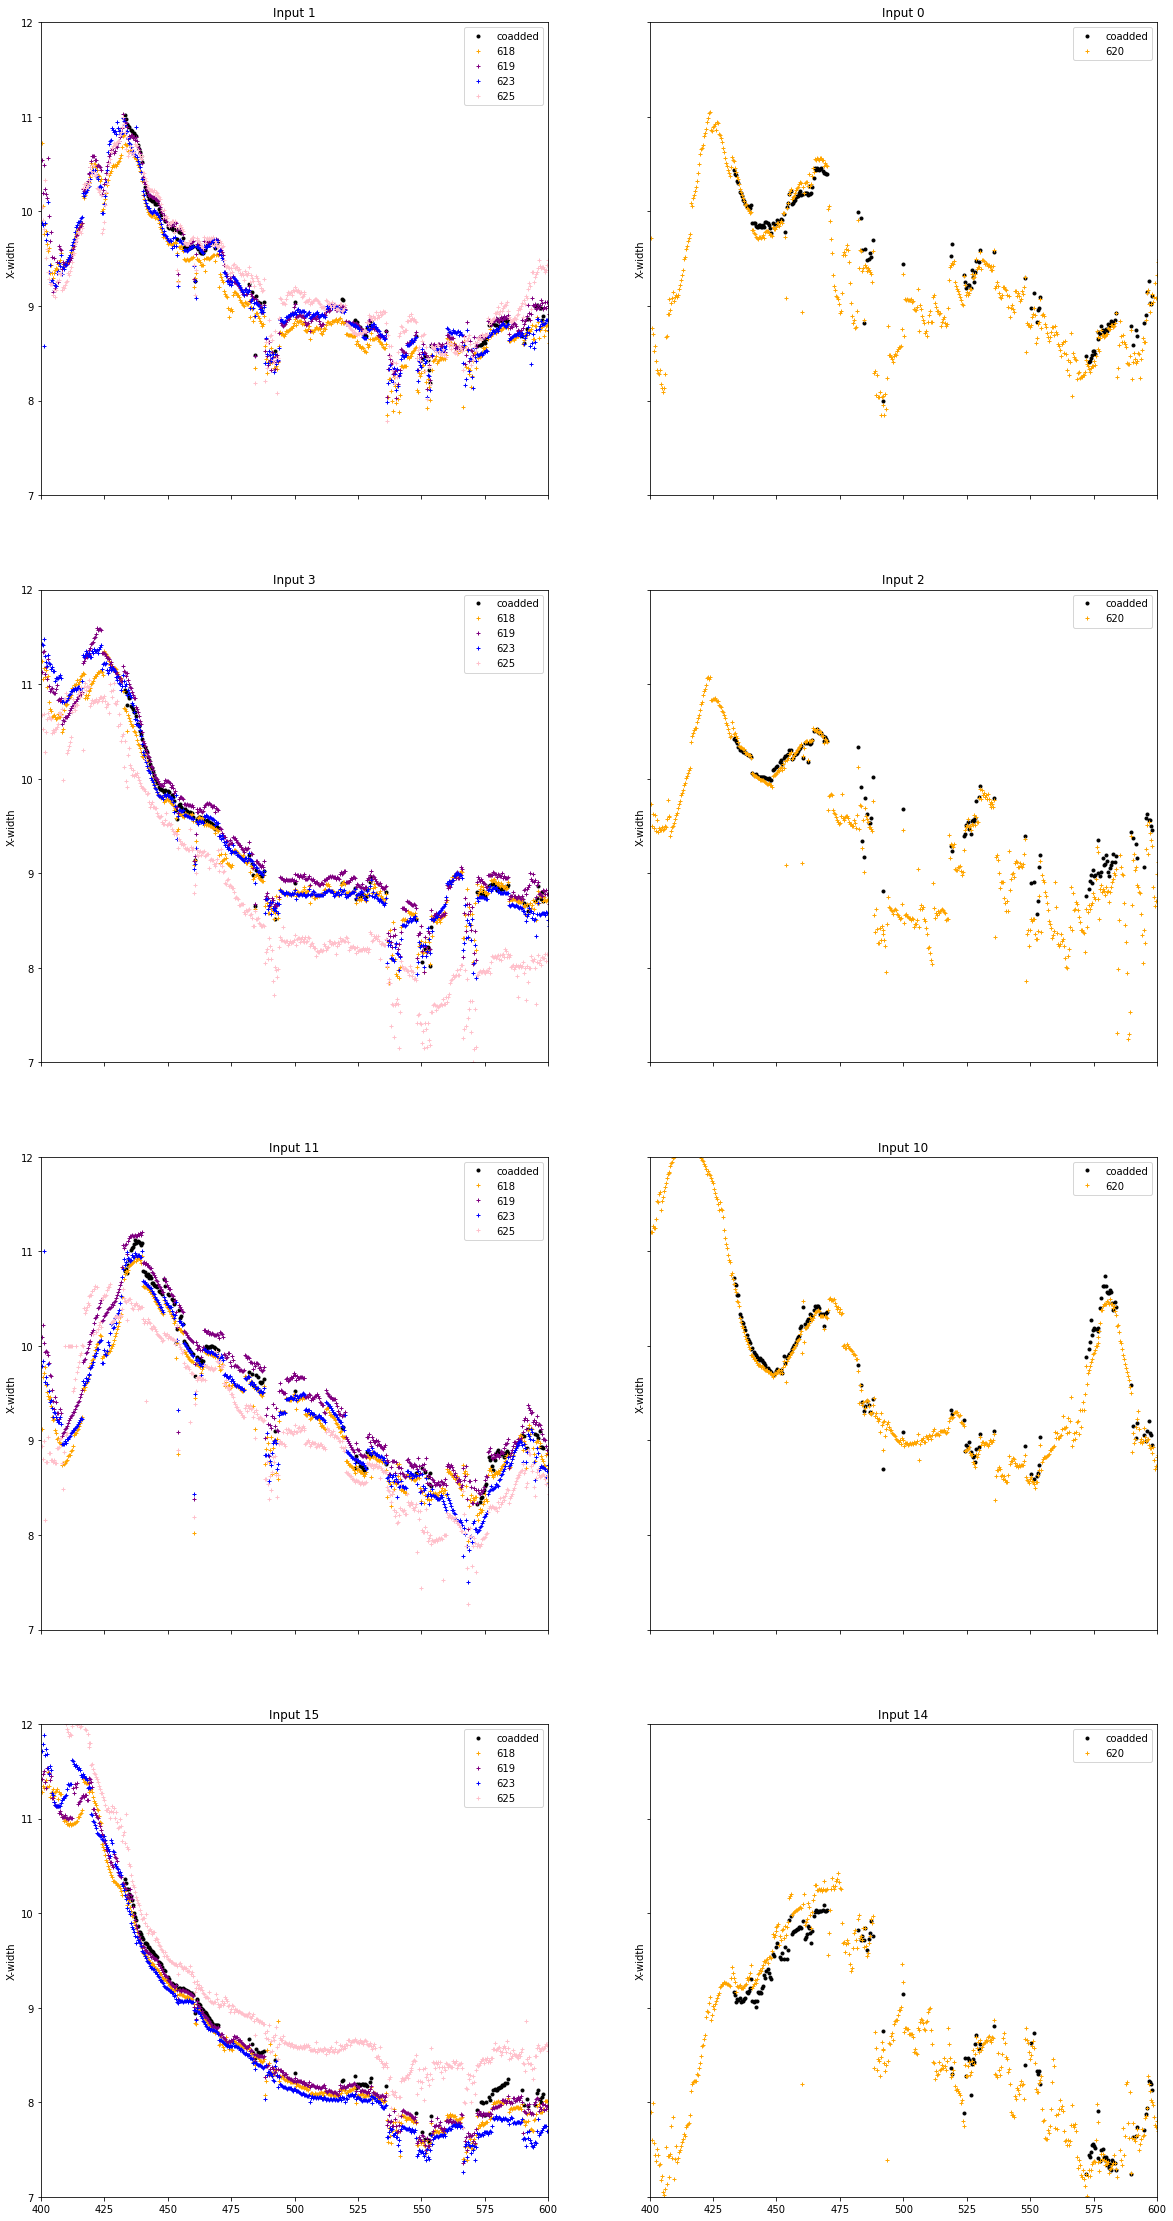

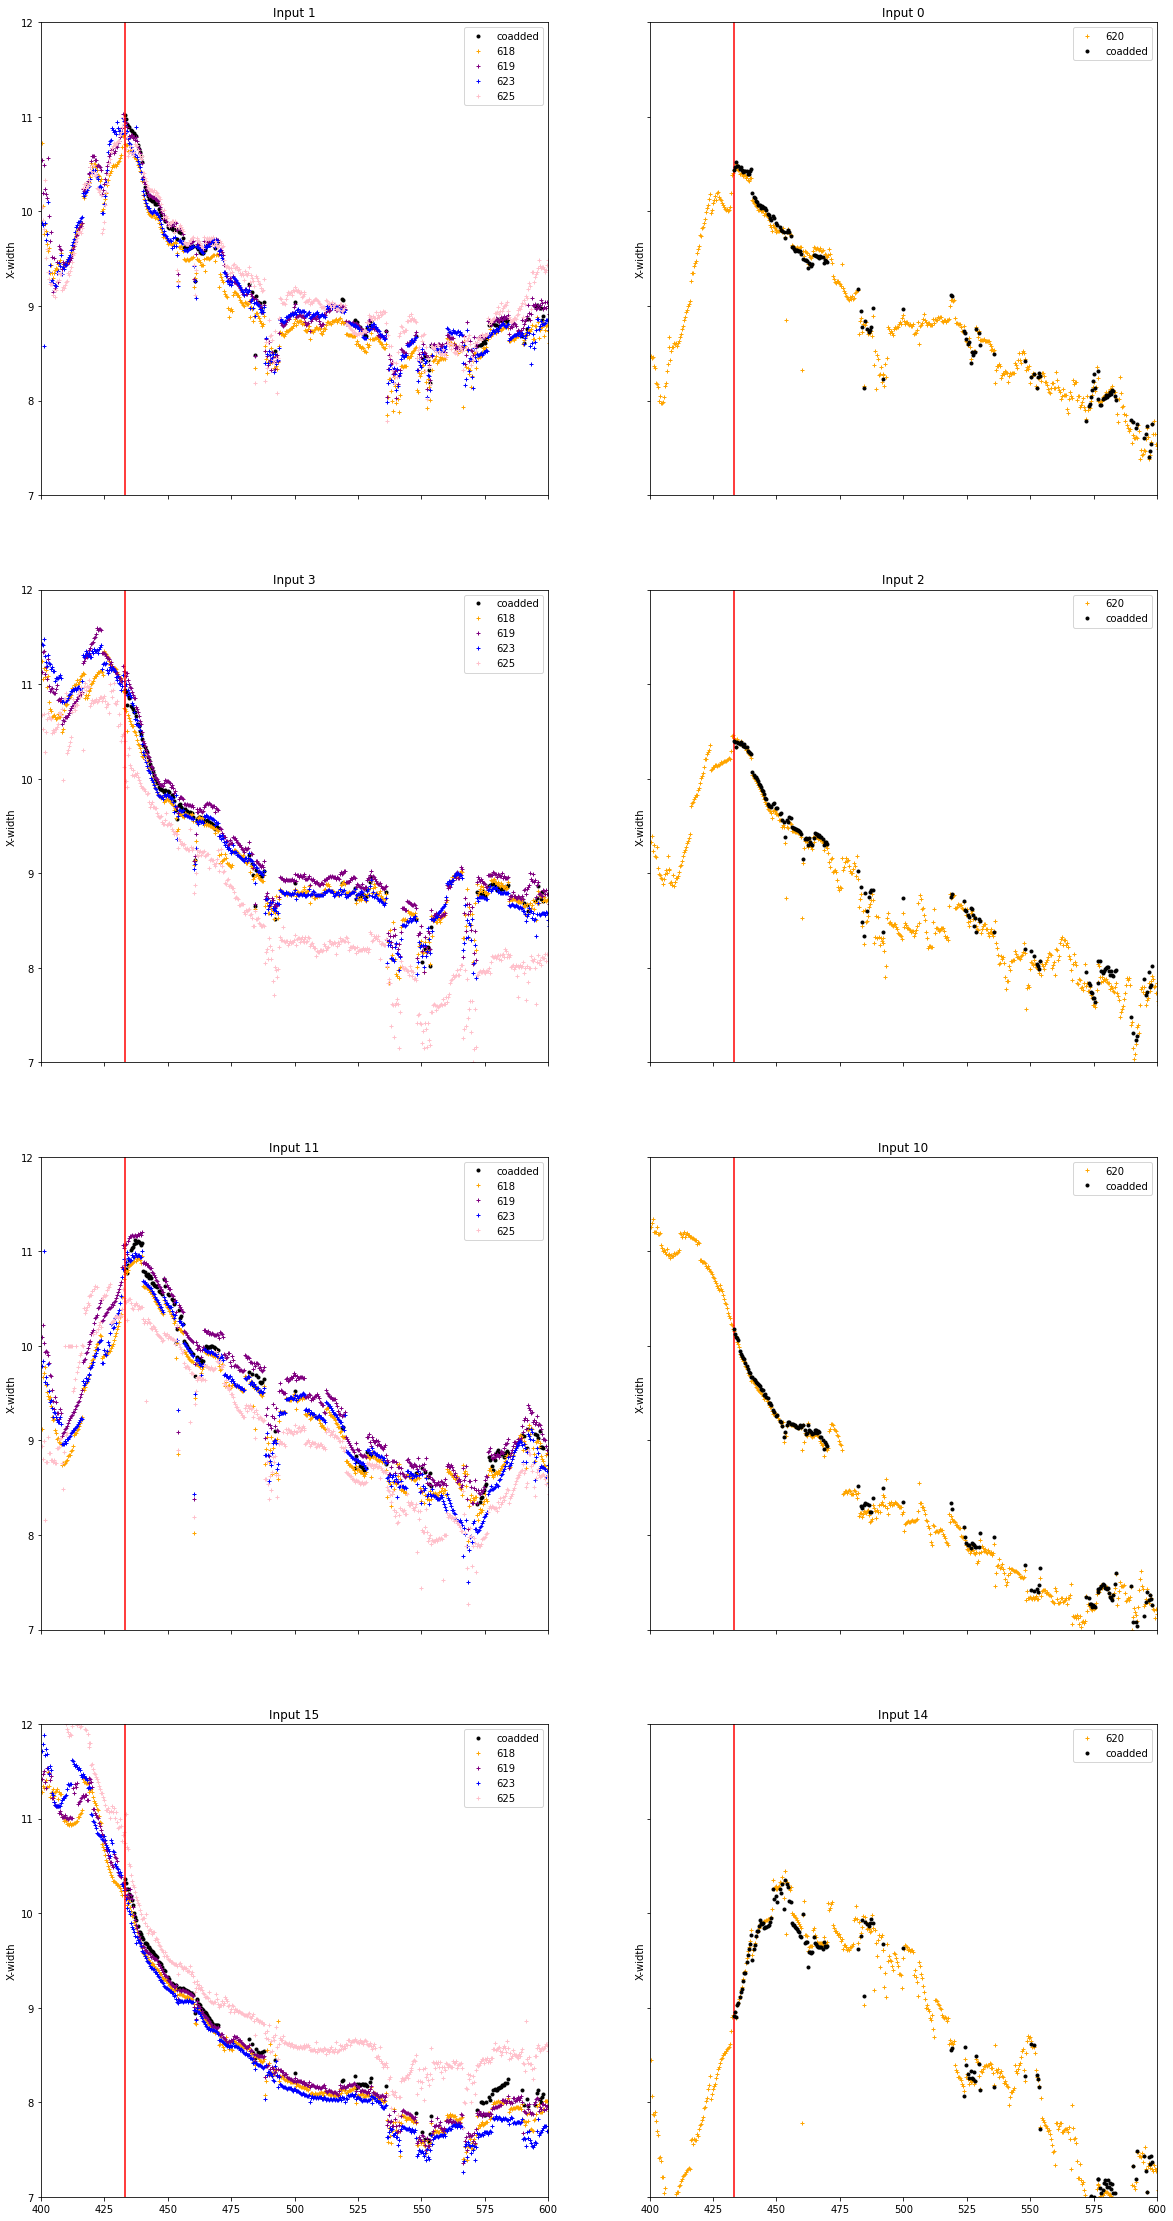

In [7]:
colorz=pu.cm_to_discrete(ccm, 16)
colorf=['orange','purple','blue','pink']
fig,axs = plt.subplots(4,2, sharex=True,sharey=True,figsize=(20,40))

for i,chind in enumerate(N_pols):
    axs[i,0].plot(freqs[good_freqs],coadded['G_popt'][chind,good_freqs,2,0],marker='.',linestyle='None',color='black',label='coadded')
    for f,fly in enumerate(['618','619','623','625']):
        ffile = glob.glob(fitdir+'*'+fly+'*')[0]
        fits = np.load(ffile)
        axs[i,0].plot(freqs,fits['G_popt'][chind,:,2],
                 markersize=4,marker='+',color=colorf[f],linestyle='None',label=fly)
    axs[i,0].legend()
    axs[i,0].set_title('Input '+str(chind))
    axs[i,0].set_ylabel('X-width')
    axs[i,0].set_ylim(7,12)
    axs[i,0].set_xlim(400,600)
    #plt.show()
    
for i,chind in enumerate(E_pols):
    axs[i,1].plot(freqs[good_freqs],coadded['G_popt'][chind,good_freqs,2,0],marker='.',linestyle='None',color='black',label='coadded')
    for f,fly in enumerate(['620']):
        ffile = glob.glob(fitdir+'*'+fly+'*')[0]
        fits = np.load(ffile)
        axs[i,1].plot(freqs,fits['G_popt'][chind,:,2],
                 markersize=4,marker='+',color=colorf[f],linestyle='None',label=fly)
    axs[i,1].legend()
    axs[i,1].set_title('Input '+str(chind))
    axs[i,1].set_ylabel('X-width')
    axs[i,1].set_ylim(7,12)
    axs[i,1].set_xlim(400,600)
plt.show()


fig,axs = plt.subplots(4,2, sharex=True,sharey=True,figsize=(20,40))
for i,chind in enumerate(N_pols):
    axs[i,0].plot(freqs[good_freqs],coadded['G_popt'][chind,good_freqs,2,0],marker='.',linestyle='None',color='black',label='coadded')
    for f,fly in enumerate(['618','619','623','625']):
        ffile = glob.glob(fitdir+'*'+fly+'*')[0]
        fits = np.load(ffile)
        axs[i,0].plot(freqs,fits['G_popt'][chind,:,2],
                 markersize=4,marker='+',color=colorf[f],linestyle='None',label=fly)
    axs[i,0].legend()
    axs[i,0].set_title('Input '+str(chind))
    axs[i,0].set_ylabel('X-width')
    axs[i,0].set_ylim(7,12)
    axs[i,0].set_xlim(400,600)
    #plt.show()
    
for i,chind in enumerate(E_pols):
    axs[i,1].errorbar(freqs[good_freqs],coadded['G_popt'][chind,good_freqs,4,0],marker='.',linestyle='None',color='black',label='coadded')
    for f,fly in enumerate(['620']):
        ffile = glob.glob(fitdir+'*'+fly+'*')[0]
        fits = np.load(ffile)
        axs[i,1].plot(freqs,fits['G_popt'][chind,:,4],
                 markersize=4,marker='+',color=colorf[f],linestyle='None',label=fly)
    axs[i,1].axvline(freqs[find],color='red')
    axs[i,0].axvline(freqs[find],color='red')
    axs[i,1].legend()
    axs[i,1].set_title('Input '+str(chind))
    axs[i,1].set_ylabel('X-width')
    axs[i,1].set_ylim(7,12)
    axs[i,0].set_xlim(400,600)
plt.show()

646 N [1, 3, 11, 15] [0, 2, 10, 14] 40
<_io.BufferedReader name='/hirax/GBO_Analysis_Outputs/flight_pickles/FLY646_20211022T183659Z_ver_20231012T022932_concat.pkl'>
[ 1.30453329e-07 -1.15261598e+01  1.48350951e+01  2.49621048e+00
  1.44109363e+01  2.24577214e-10  0.00000000e+00]
height:  178.4366733242003


<ipython-input-5-566ec05940bc>:39: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  axs[i,0].scatter(x,y,c=z,cmap=cm.gnuplot2,norm=LogNorm(),vmin=1E-4,vmax=1)


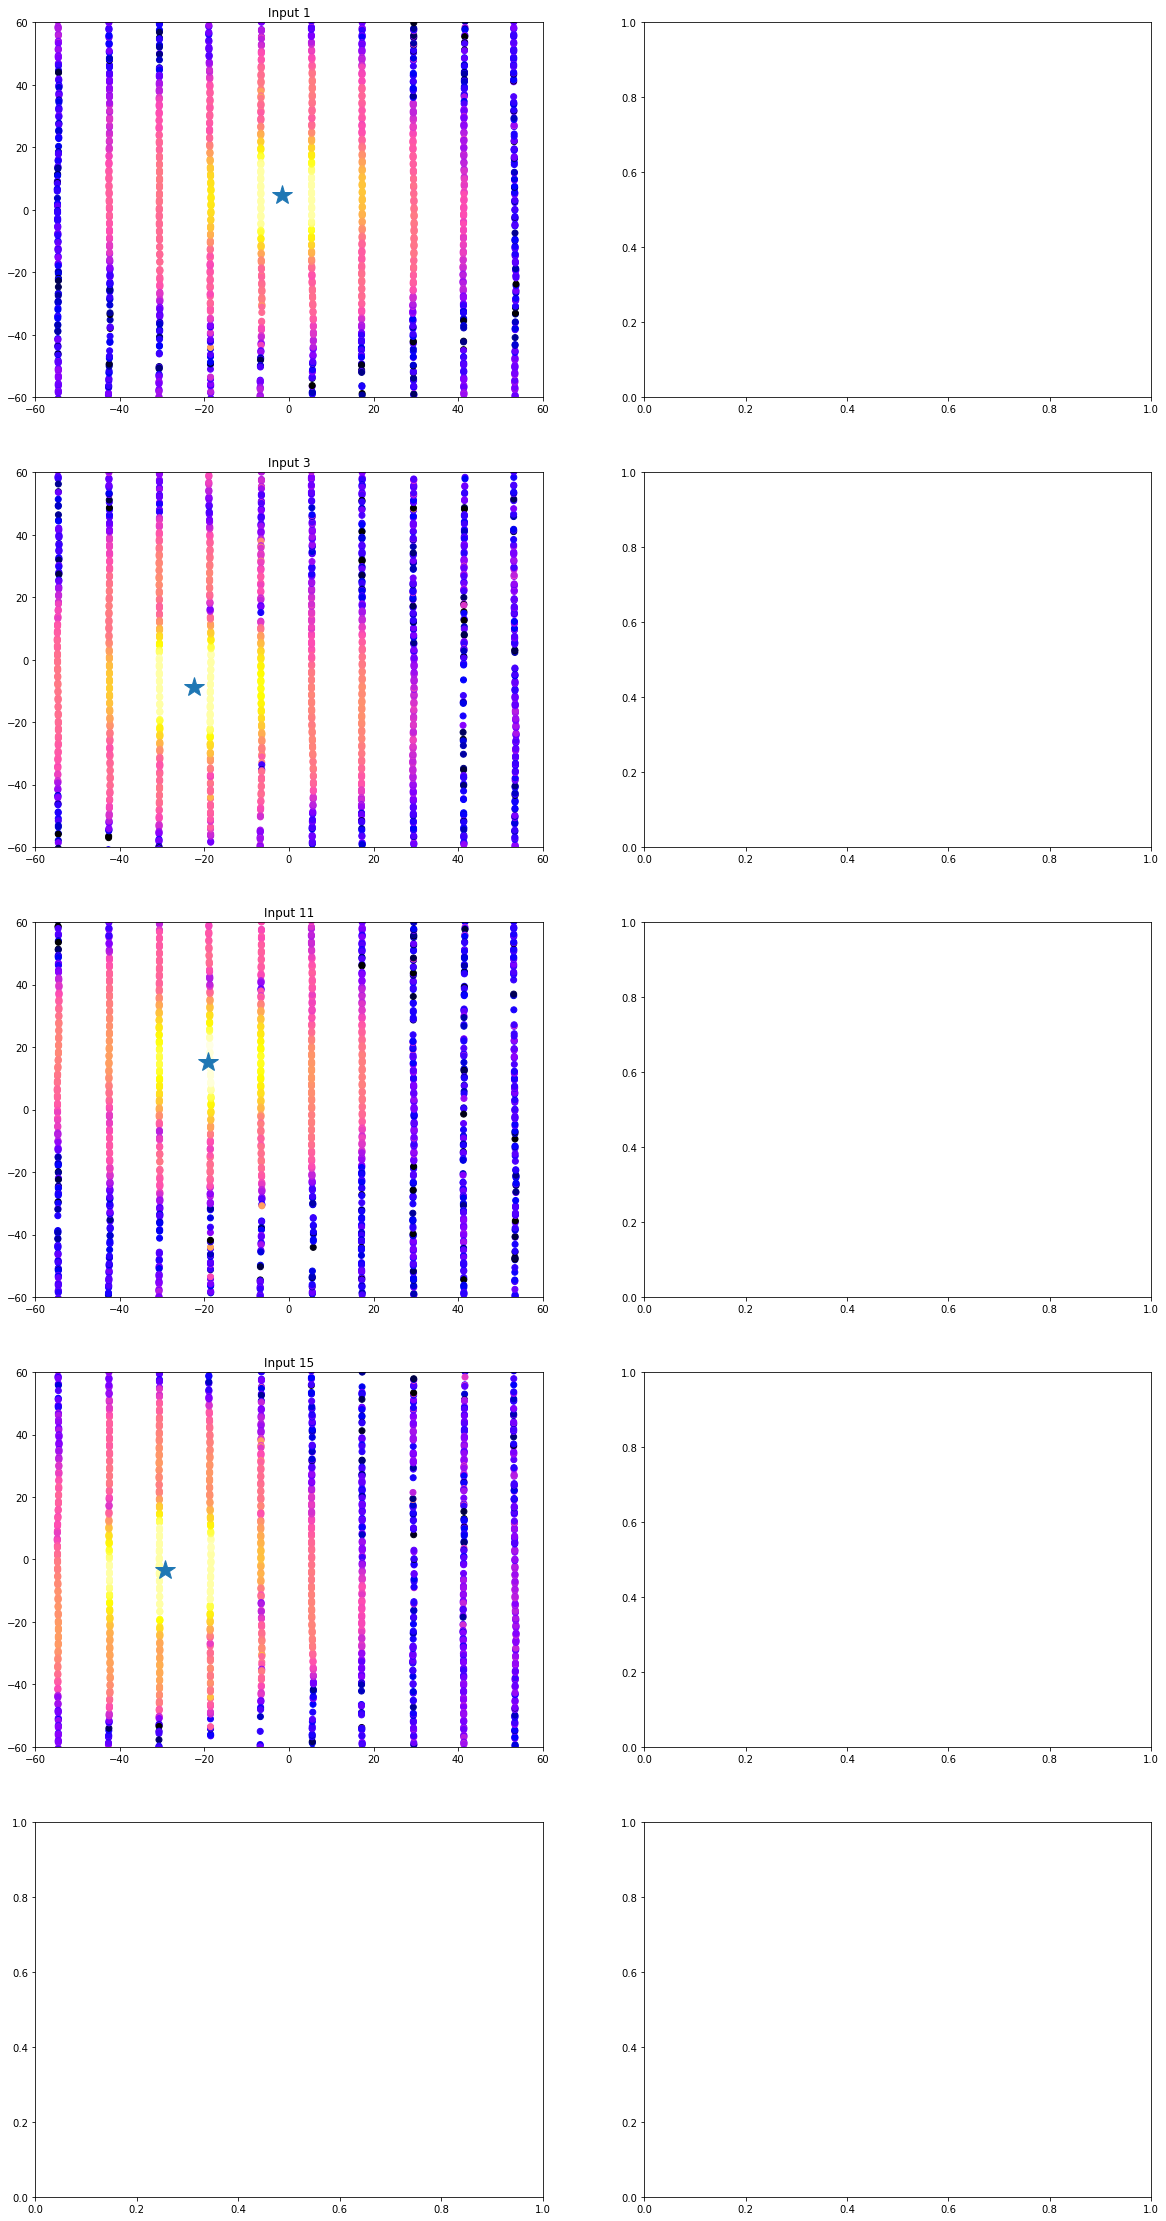

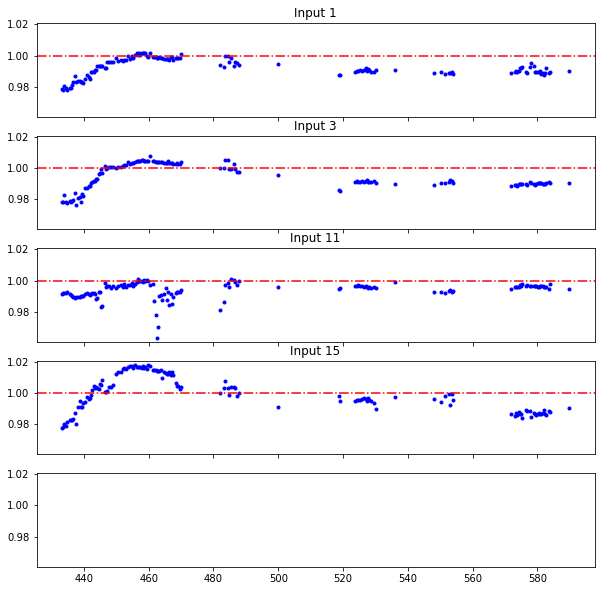

In [5]:
# Pick flight 619 and see what happens

fly = '646'
pol, pols, cpols, attn, fi = get_flightinfo(fly)
print(fly,pol,pols,cpols, attn)

# initial settings
find = 900
chind=9

# Choose which dish here

with open(glob.glob(pckldir+'*'+fly+'*')[0], 'rb') as pfile:
    print(pfile)
    fl625=pickle.load(pfile)
t_cut_625=fl625.inds_on  

# Plot the 2D data and see if its bascially sensible


print(fl625.G_popt[chind,find,:])

x = fl625.drone_xyz_LC_interp[t_cut_625,0]
y = fl625.drone_xyz_LC_interp[t_cut_625,1]
z = fl625.V_bgsub[t_cut_625,find,chind] 

print('height: ', np.nanmedian(fl625.drone_xyz_per_dish_interp[chind,t_cut_625,2]))
colorz=pu.cm_to_discrete(ccm, 16)
fig,axs = plt.subplots(5,2,figsize=(20,40))
for i, chind in enumerate(pols):


    x = fl625.drone_xyz_LC_interp[t_cut_625,0]  
    y = fl625.drone_xyz_LC_interp[t_cut_625,1]
    z = fl625.V_bgsub[t_cut_625,find,chind]/ fl625.G_popt[chind,find,0]


    # plot scatter plot and beam map
    axs[i,0].scatter(x,y,c=z,cmap=cm.gnuplot2,norm=LogNorm(),vmin=1E-4,vmax=1)
    axs[i,0].plot(fl625.G_popt[chind,find,1],fl625.G_popt[chind,find,3],marker='*',markersize=20)
    axs[i,0].set_ylim(-60,60)
    axs[i,0].set_xlim(-60,60)
    axs[i,0].set_title('Input '+str(chind))
plt.show()


# Refit and look at amplitude

Gpopt_new = np.zeros([16,1024,6])


for i,chind in enumerate(N_pols):
    x = fl625.drone_xyz_per_dish_interp[chind,t_cut_625,0]
    y = fl625.drone_xyz_per_dish_interp[chind,t_cut_625,1]
    
    for find in good_freqs:
        z = fl625.V_bgsub[t_cut_625,find,chind]/ (fl625.G_popt[chind,find,0] + fl625.G_popt[chind,find,5])

        mbx = x
        mby = y
        mbV = z

        gi = np.where((np.isfinite(mbV)))[0]
        #restr = 10
        #gi = np.where((np.isfinite(mbV)) & (np.abs(mbx) < restr) & (np.abs(mby) < restr))[0]
        input_data=np.array([mbx[gi],mby[gi],mbV[gi]])
        #pG = fl625.G_popt[chind,find,0:6]
        pG = [1E-8,0.0, 8.0, 0.0, 8.0, 1E-11]
        #print('old ',pG)

        Gpopt_new[chind,find,:] = least_squares(fu.Gauss_2d_LC_opt,x0=pG,method='trf',args=input_data).x


colorz=pu.cm_to_discrete(ccm, 16)
fig,axs = plt.subplots(5, sharex=True,sharey=True,figsize=(10,10))

for i,chind in enumerate(N_pols):
    axs[i].plot(freqs[good_freqs],Gpopt_new[chind,good_freqs,0],'b.')
    axs[i].axhline(1.0,color='red',linestyle='-.')
    axs[i].set_title('Input '+str(chind))
plt.show()       

# Re-check if gridding is doing something funny as I co-add

618 N [1, 3, 11, 15] [0, 2, 10, 14] 46
<_io.BufferedReader name='/hirax/GBO_Analysis_Outputs/flight_pickles/FLY618_20211021T183430Z_ver_20231012T003521_concat.pkl'>
input:  1 fits widths  8.81658636273791 8.577344714421365
input:  3 fits widths  8.853413998226173 8.206243620889245
input:  11 fits widths  8.734870063289724 10.931356402171877
input:  15 fits widths  8.02426901834557 8.396195200391887


<ipython-input-5-55e808fba28b>:52: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  axs[i,1].scatter(x,y,c=z,cmap=cm.gnuplot2,norm=LogNorm(),vmin=1E-4,vmax=1)
<ipython-input-5-55e808fba28b>:52: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  axs[i,1].scatter(x,y,c=z,cmap=cm.gnuplot2,norm=LogNorm(),vmin=1E-4,vmax=1)
<ipython-input-5-55e808fba28b>:52: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  axs[i,1].scatter(x,y,c=z,cmap=cm.gnuplot2,norm=LogNorm(),vmin=1E-4,vmax=1)
<ipytho

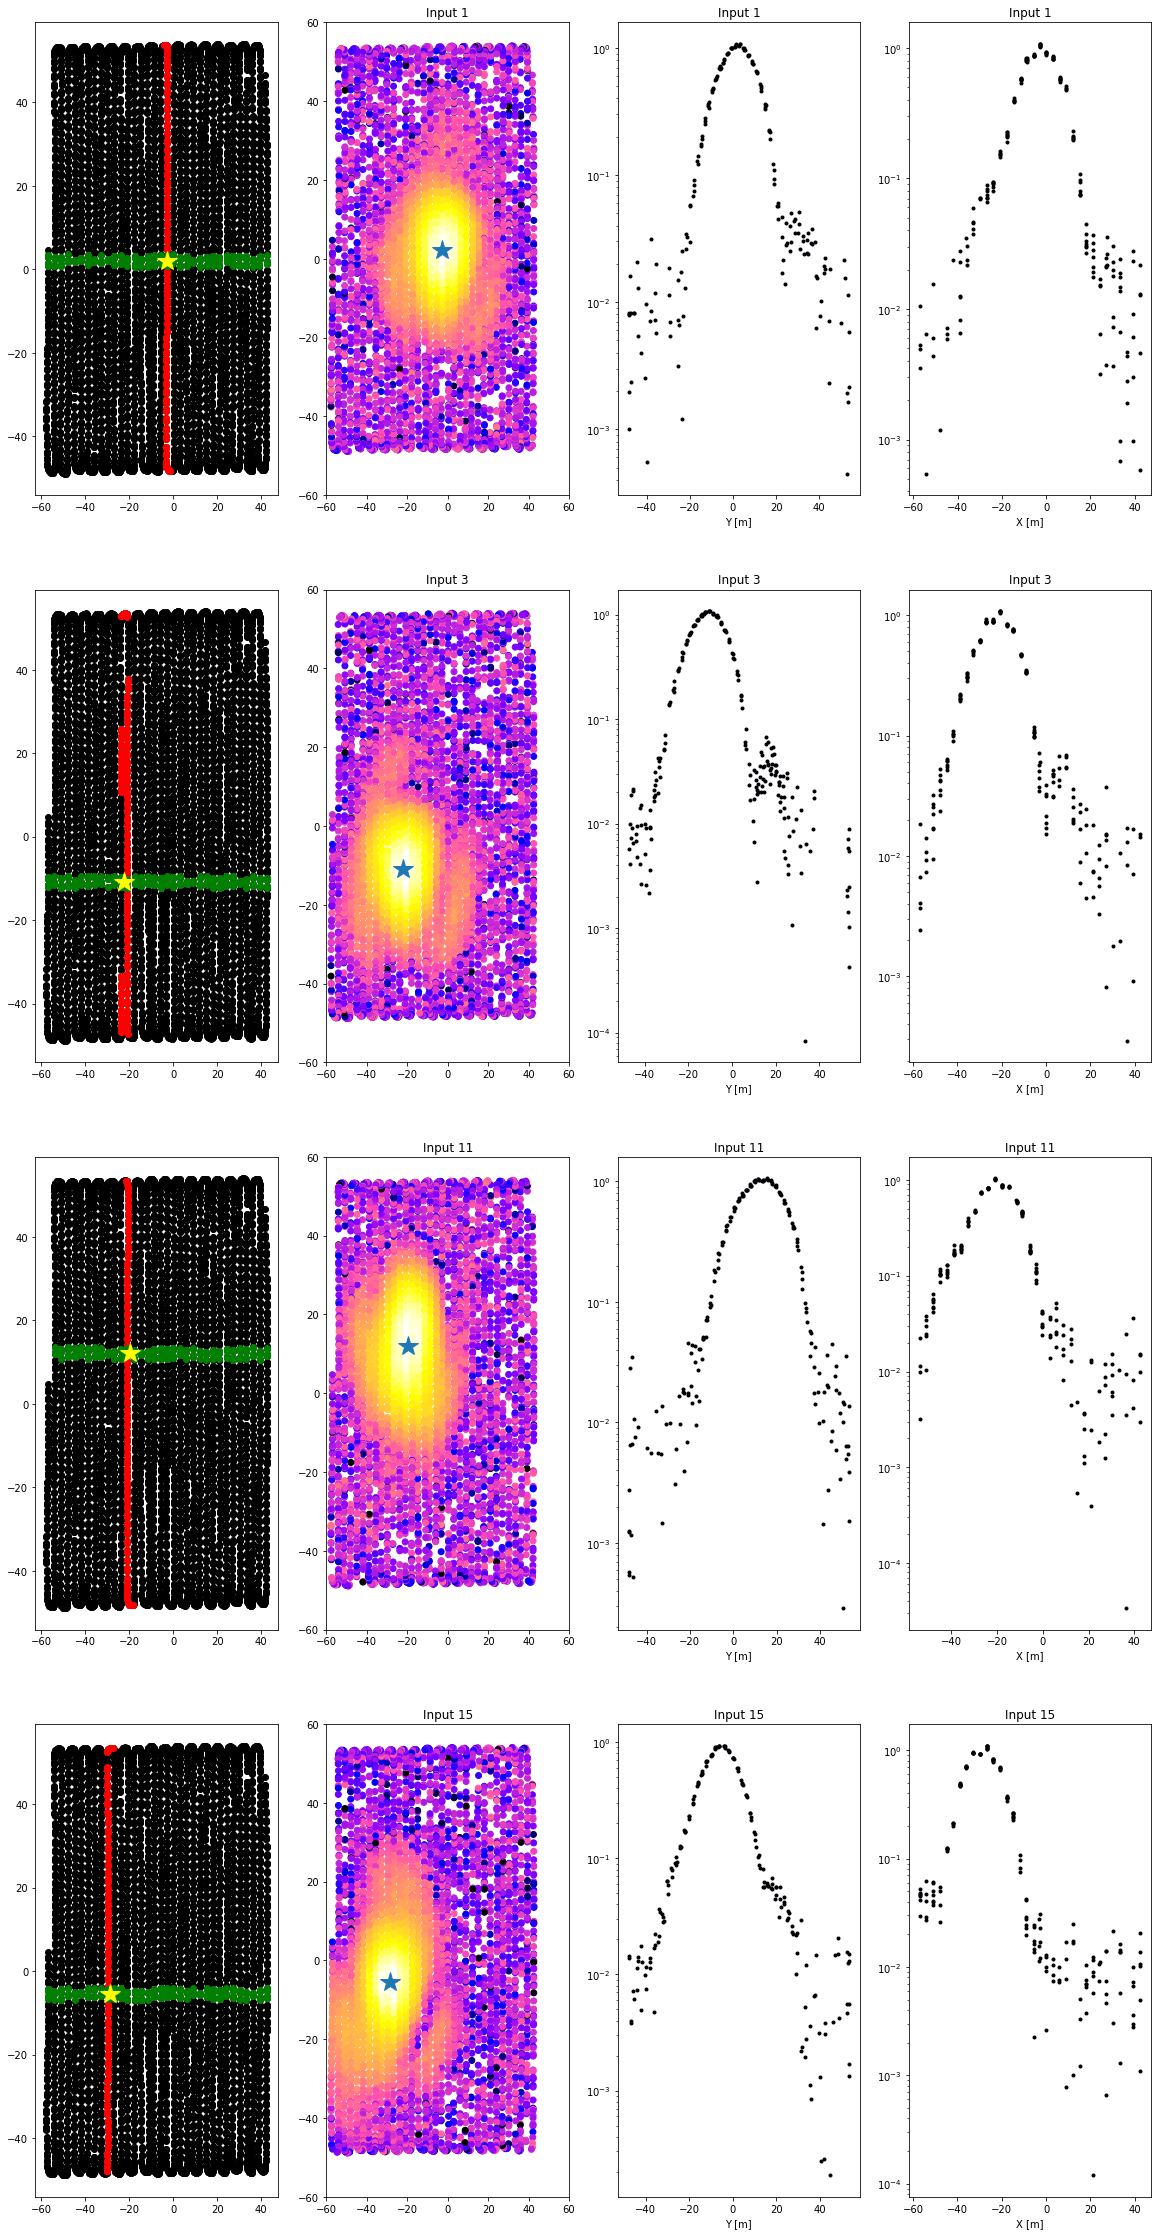

In [5]:
# make grid of beam, compare slices:

###### Read in raw data without grid, plot slices:

fly = '618'
pol, pols, cpols, attn, fi = get_flightinfo(fly)
print(fly,pol,pols,cpols, attn)

# initial settings
find = good_freqs[4]
chind=pols[0]

# Choose which dish here

with open(glob.glob(pckldir+'*'+fly+'*')[0], 'rb') as pfile:
    print(pfile)
    fl625=pickle.load(pfile)
t_cut_625=fl625.inds_on  


x = fl625.drone_xyz_LC_interp[t_cut_625,0]
y = fl625.drone_xyz_LC_interp[t_cut_625,1]
z = fl625.V_bgsub[t_cut_625,find,chind] 


colorz=pu.cm_to_discrete(ccm, 16)
fig,axs = plt.subplots(4,4,figsize=(20,40))
for i, chind in enumerate(pols):

    x = fl625.drone_xyz_LC_interp[t_cut_625,0]  
    y = fl625.drone_xyz_LC_interp[t_cut_625,1]
    z = fl625.V_bgsub[t_cut_625,find,chind]/ fl625.G_popt[chind,find,0]
    
    # Fit a Gaussian and get the offset
    z = fl625.V_bgsub[t_cut_625,find,chind]/ (fl625.G_popt[chind,find,0])

    mbx = x
    mby = y
    mbV = z

    gi = np.where((np.isfinite(mbV)))[0]
    #restr = 10
    #gi = np.where((np.isfinite(mbV)) & (np.abs(mbx) < restr) & (np.abs(mby) < restr))[0]
    input_data=np.array([mbx[gi],mby[gi],mbV[gi]])
    pG = [1E-8,0.0, 8.0, 0.0, 8.0, 1E-11]
    fit = least_squares(fu.Gauss_2d_LC_opt,x0=pG,method='trf',args=input_data).x
    print('input: ',chind, 'fits widths ', fit[2],fit[4])
    xcent = fit[1]
    ycent = fit[3]
    # grab a slice and plot it

    axs[i,1].scatter(x,y,c=z,cmap=cm.gnuplot2,norm=LogNorm(),vmin=1E-4,vmax=1)
    #axs[i,1].plot(fl625.G_popt[chind,find,1],fl625.G_popt[chind,find,3],marker='*',markersize=20)
    axs[i,1].plot(xcent,ycent,marker='*',markersize=20)
    axs[i,1].set_ylim(-60,60)
    axs[i,1].set_xlim(-60,60)
    axs[i,1].set_title('Input '+str(chind))
    
    ixx = get_slice_xy(x,y,xcent,ax='x') # grabbed x slice
    axs[i,2].semilogy(y[ixx],z[ixx],color=colorz[0],marker='.',linestyle='None',label='Data')
    axs[i,2].set_xlabel('Y [m]')
    axs[i,2].set_title('Input '+str(chind))
    
    iyy = get_slice_xy(x,y,ycent,ax='y') # grabbed x slice
    axs[i,3].semilogy(x[iyy],z[iyy],color=colorz[0],marker='.',linestyle='None',label='Data')
    axs[i,3].set_xlabel('X [m]')
    axs[i,3].set_title('Input '+str(chind))
    
    axs[i,0].scatter(x,y,color='black')
    axs[i,0].scatter(x[ixx],y[ixx],color='red')
    axs[i,0].scatter(x[iyy],y[iyy],color='green')
    axs[i,0].plot(xcent,ycent,marker='*',markersize=20,color='yellow')
    
    
plt.show()



Working on Frequency:  557 582.421875
start of big ass loop is: 2024-03-07 15:29:10.994199
618 /hirax/GBO_Analysis_Outputs/main_beam_fits/FLY618_20211021T183430Z_2dGauss_and_Airy_Params.npz
619 /hirax/GBO_Analysis_Outputs/main_beam_fits/FLY619_20211021T185805Z_2dGauss_and_Airy_Params.npz
end of bigass loop is: 2024-03-07 15:29:13.675048   


/home/ln267/anaconda3/lib/python3.8/site-packages/beamcals/beam_autoprocessing.py:214: RuntimeWarning: invalid value encountered in true_divide
  self.V_LC_operation = np.nansum(self.V_LC_sum,axis=4)/self.V_LC_operation_count


input: 1 widths:  8.659916438581435 8.464918843743709
input: 3 widths:  9.0001048117409 8.299802601179472
input: 11 widths:  8.744366187825845 10.849351092837129
input: 15 widths:  8.051295347325496 8.424641898475745


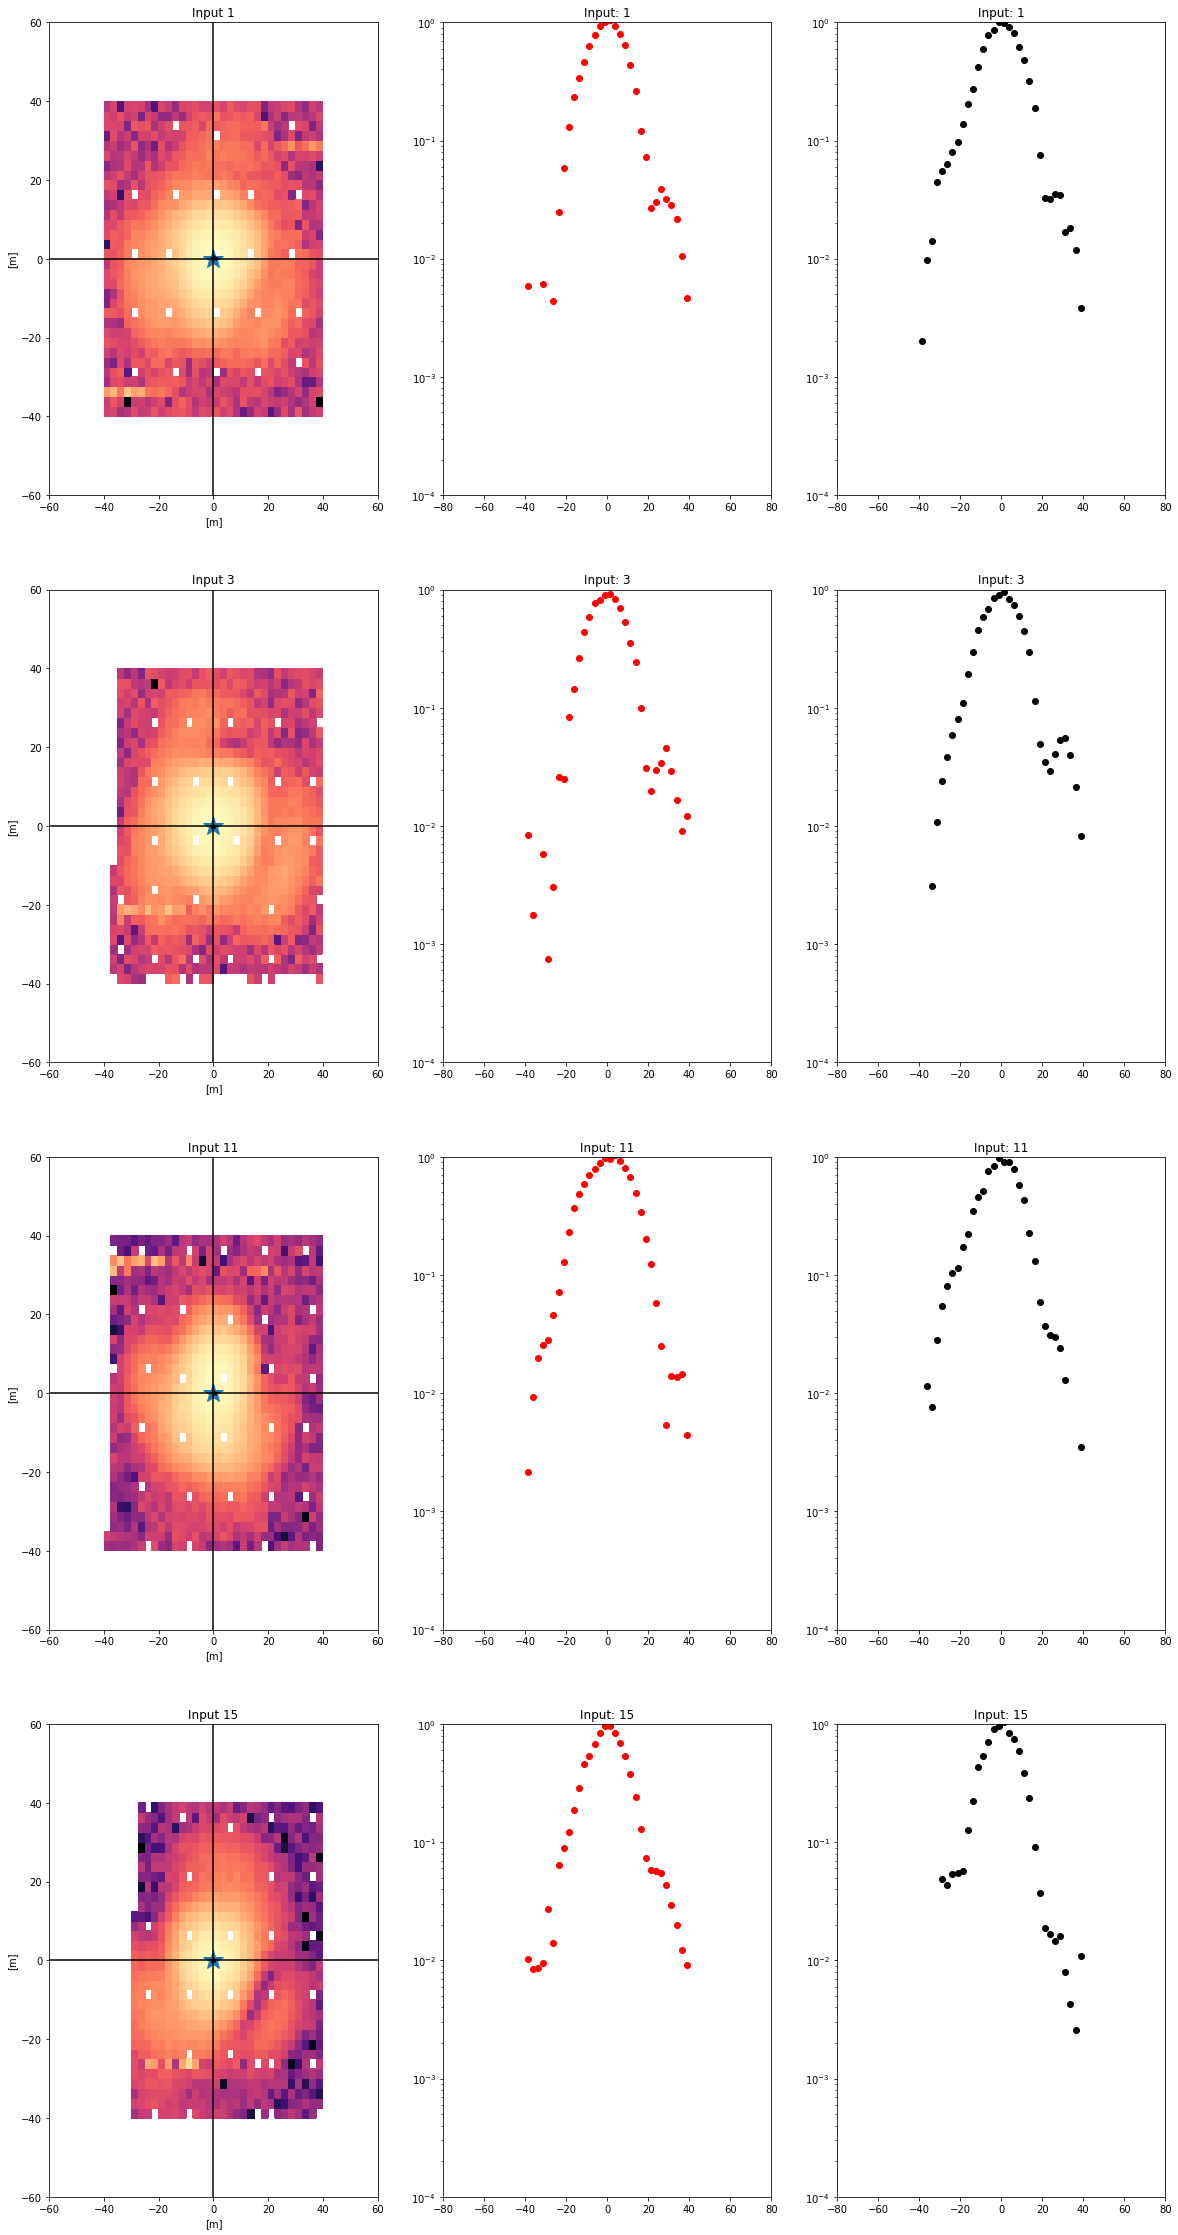

In [6]:
# Make a beammap and plot the same thing

print('Working on Frequency: ',find,freqs[find])
pols = N_pols

flights = ['618','619']
concytest=[glob.glob(pckldir+'*'+fly+'*')[0] for fly in flights]

beam=ba.Beammap_forautoprocessing(concatlist=concytest,
        normalization='Gauss_wcorr',operation='coadd',mask=True,d0args=[-1*sz,sz,2.5],
        d1args=[-1*sz,sz,2.5],Fargs=[find,find+1,1])
    
    
## Look at the grids and check it looks centered

# Npol flights
fig,axs = plt.subplots(4,3,figsize=(20,40))
for i,chind in enumerate(pols):
    
    axs[i,0].pcolormesh(beam.d0_edges_grid[:,:,chind],
                        beam.d1_edges_grid[:,:,chind],
                        np.abs(beam.V_LC_operation[:,:,0,chind]),cmap=cm.magma,norm=LogNorm())#,edgecolors='k')
    axs[i,0].plot(0,0,marker='*',markersize=20)
    axs[i,0].axvline(0,c='k')
    axs[i,0].axhline(0,c='k')
    axs[i,0].set_xlim(-60,60)
    axs[i,0].set_ylim(-60,60)
    axs[i,0].set_title('Input '+str(chind))
    axs[i,0].set_xlabel('[m]')
    axs[i,0].set_ylabel('[m]')
    
    mbx = beam.d0_centers_grid[:,:,chind].flatten()
    mby = beam.d1_centers_grid[:,:,chind].flatten()
    mbV = beam.V_LC_operation[:,:,0,chind].flatten()
    gi = np.where(np.isfinite(mbV))[0]
    input_data=np.array([mbx[gi],mby[gi],mbV[gi]])
    fits = least_squares(fu.Gauss_2d_LC_opt,x0=pG,method='trf',args=input_data).x
    axs[i,0].plot(fits[1],fits[3],marker='*',color='black')
    
    print('input:', chind, 'widths: ',fits[2],fits[4])

    xx = 0
    colx = get_slice(beam.d0_centers_grid[:,:,chind],beam.d1_centers_grid[:,:,chind],
                 beam.V_LC_operation[:,:,0,chind],xx,'v')
    coly = get_slice(beam.d0_centers_grid[:,:,chind],beam.d1_centers_grid[:,:,chind],
                 beam.V_LC_operation[:,:,0,chind],xx,'h')

    # colx: use for constant x, let y vary: vertical slice 
    # coly: use for constany y, let x vary: horizontal slice


    colx = get_slice(beam.d0_centers_grid[:,:,chind],beam.d1_centers_grid[:,:,chind],
                 beam.V_LC_operation[:,:,0,chind],xx,'v')
    coly = get_slice(beam.d0_centers_grid[:,:,chind],beam.d1_centers_grid[:,:,chind],
                 beam.V_LC_operation[:,:,0,chind],xx,'h')

    axs[i,1].semilogy(beam.d1_centers_grid[colx,:,chind],beam.V_LC_operation[colx,:,0,chind],'o',
             label='Coadd x :'+str(beam.d0_centers_grid[colx,0,0]),color='red')
    axs[i,1].set_title('Input: '+str(chind))
    axs[i,1].set_ylim(0.0001,1)
    axs[i,1].set_xlim(-1*sz,sz)
    #plt.legend(loc='lower center')
    axs[i,2].semilogy(beam.d0_centers_grid[:,coly,0],beam.V_LC_operation[:,coly,0,chind],'o',
             label='Coadd  y :'+str(beam.d1_centers_grid[0,coly,0]),color='black')
    axs[i,2].set_ylim(0.0001,1)
    axs[i,2].set_xlim(-1*sz,sz)
    axs[i,2].set_title('Input: '+str(chind))
    #plt.legend(loc='lower center')
plt.show()
    

In [16]:
print(Npolflights)

['618', '619', '625', '646', '647', '533', '536']


In [16]:
flights = ['618','619']
concytest=[glob.glob(pckldir+'*'+fly+'*')[0] for fly in flights]

beam_fits = np.zeros([16,1024,6])

for f, find in enumerate(good_freqs[::5]):
    beam=ba.Beammap_forautoprocessing(concatlist=concytest,
        normalization='Gauss_wcorr',operation='coadd',mask=True,d0args=[-1*sz,sz,2.0],
        d1args=[-1*sz,sz,2.0],Fargs=[find,find+1,1])
    for c,chind in enumerate(pols):
        mbx = beam.d0_centers_grid[:,:,chind].flatten()
        mby = beam.d1_centers_grid[:,:,chind].flatten()
        mbV = beam.V_LC_operation[:,:,0,chind].flatten()
        gi = np.where(np.isfinite(mbV))[0]
        input_data=np.array([mbx[gi],mby[gi],mbV[gi]])
        beam_fits[chind,find,:] = least_squares(fu.Gauss_2d_LC_opt,x0=pG,method='trf',args=input_data).x


start of big ass loop is: 2024-03-07 16:16:08.453682
618 /hirax/GBO_Analysis_Outputs/main_beam_fits/FLY618_20211021T183430Z_2dGauss_and_Airy_Params.npz
619 /hirax/GBO_Analysis_Outputs/main_beam_fits/FLY619_20211021T185805Z_2dGauss_and_Airy_Params.npz
end of bigass loop is: 2024-03-07 16:16:11.143313   


/home/ln267/anaconda3/lib/python3.8/site-packages/beamcals/beam_autoprocessing.py:214: RuntimeWarning: invalid value encountered in true_divide
  self.V_LC_operation = np.nansum(self.V_LC_sum,axis=4)/self.V_LC_operation_count


start of big ass loop is: 2024-03-07 16:16:13.703602
618 /hirax/GBO_Analysis_Outputs/main_beam_fits/FLY618_20211021T183430Z_2dGauss_and_Airy_Params.npz
619 /hirax/GBO_Analysis_Outputs/main_beam_fits/FLY619_20211021T185805Z_2dGauss_and_Airy_Params.npz
end of bigass loop is: 2024-03-07 16:16:16.389972   
start of big ass loop is: 2024-03-07 16:16:18.954532
618 /hirax/GBO_Analysis_Outputs/main_beam_fits/FLY618_20211021T183430Z_2dGauss_and_Airy_Params.npz
619 /hirax/GBO_Analysis_Outputs/main_beam_fits/FLY619_20211021T185805Z_2dGauss_and_Airy_Params.npz
end of bigass loop is: 2024-03-07 16:16:21.645465   
start of big ass loop is: 2024-03-07 16:16:24.113474
618 /hirax/GBO_Analysis_Outputs/main_beam_fits/FLY618_20211021T183430Z_2dGauss_and_Airy_Params.npz
619 /hirax/GBO_Analysis_Outputs/main_beam_fits/FLY619_20211021T185805Z_2dGauss_and_Airy_Params.npz
end of bigass loop is: 2024-03-07 16:16:26.794640   
start of big ass loop is: 2024-03-07 16:16:29.335655
618 /hirax/GBO_Analysis_Outputs/mai

start of big ass loop is: 2024-03-07 16:18:36.634077
618 /hirax/GBO_Analysis_Outputs/main_beam_fits/FLY618_20211021T183430Z_2dGauss_and_Airy_Params.npz
619 /hirax/GBO_Analysis_Outputs/main_beam_fits/FLY619_20211021T185805Z_2dGauss_and_Airy_Params.npz
end of bigass loop is: 2024-03-07 16:18:39.249065   
start of big ass loop is: 2024-03-07 16:18:41.787666
618 /hirax/GBO_Analysis_Outputs/main_beam_fits/FLY618_20211021T183430Z_2dGauss_and_Airy_Params.npz
619 /hirax/GBO_Analysis_Outputs/main_beam_fits/FLY619_20211021T185805Z_2dGauss_and_Airy_Params.npz
end of bigass loop is: 2024-03-07 16:18:44.469727   


[8.77442174 8.69050332 8.8925841  7.85297469] [8.78917497 8.22433    9.08172907 8.76759047]
[8.77442174 8.69050332 8.8925841  7.85297469] [8.78917497 8.22433    9.08172907 8.76759047]
[8.77442174 8.69050332 8.8925841  7.85297469] [8.78917497 8.22433    9.08172907 8.76759047]
[8.77442174 8.69050332 8.8925841  7.85297469] [8.78917497 8.22433    9.08172907 8.76759047]


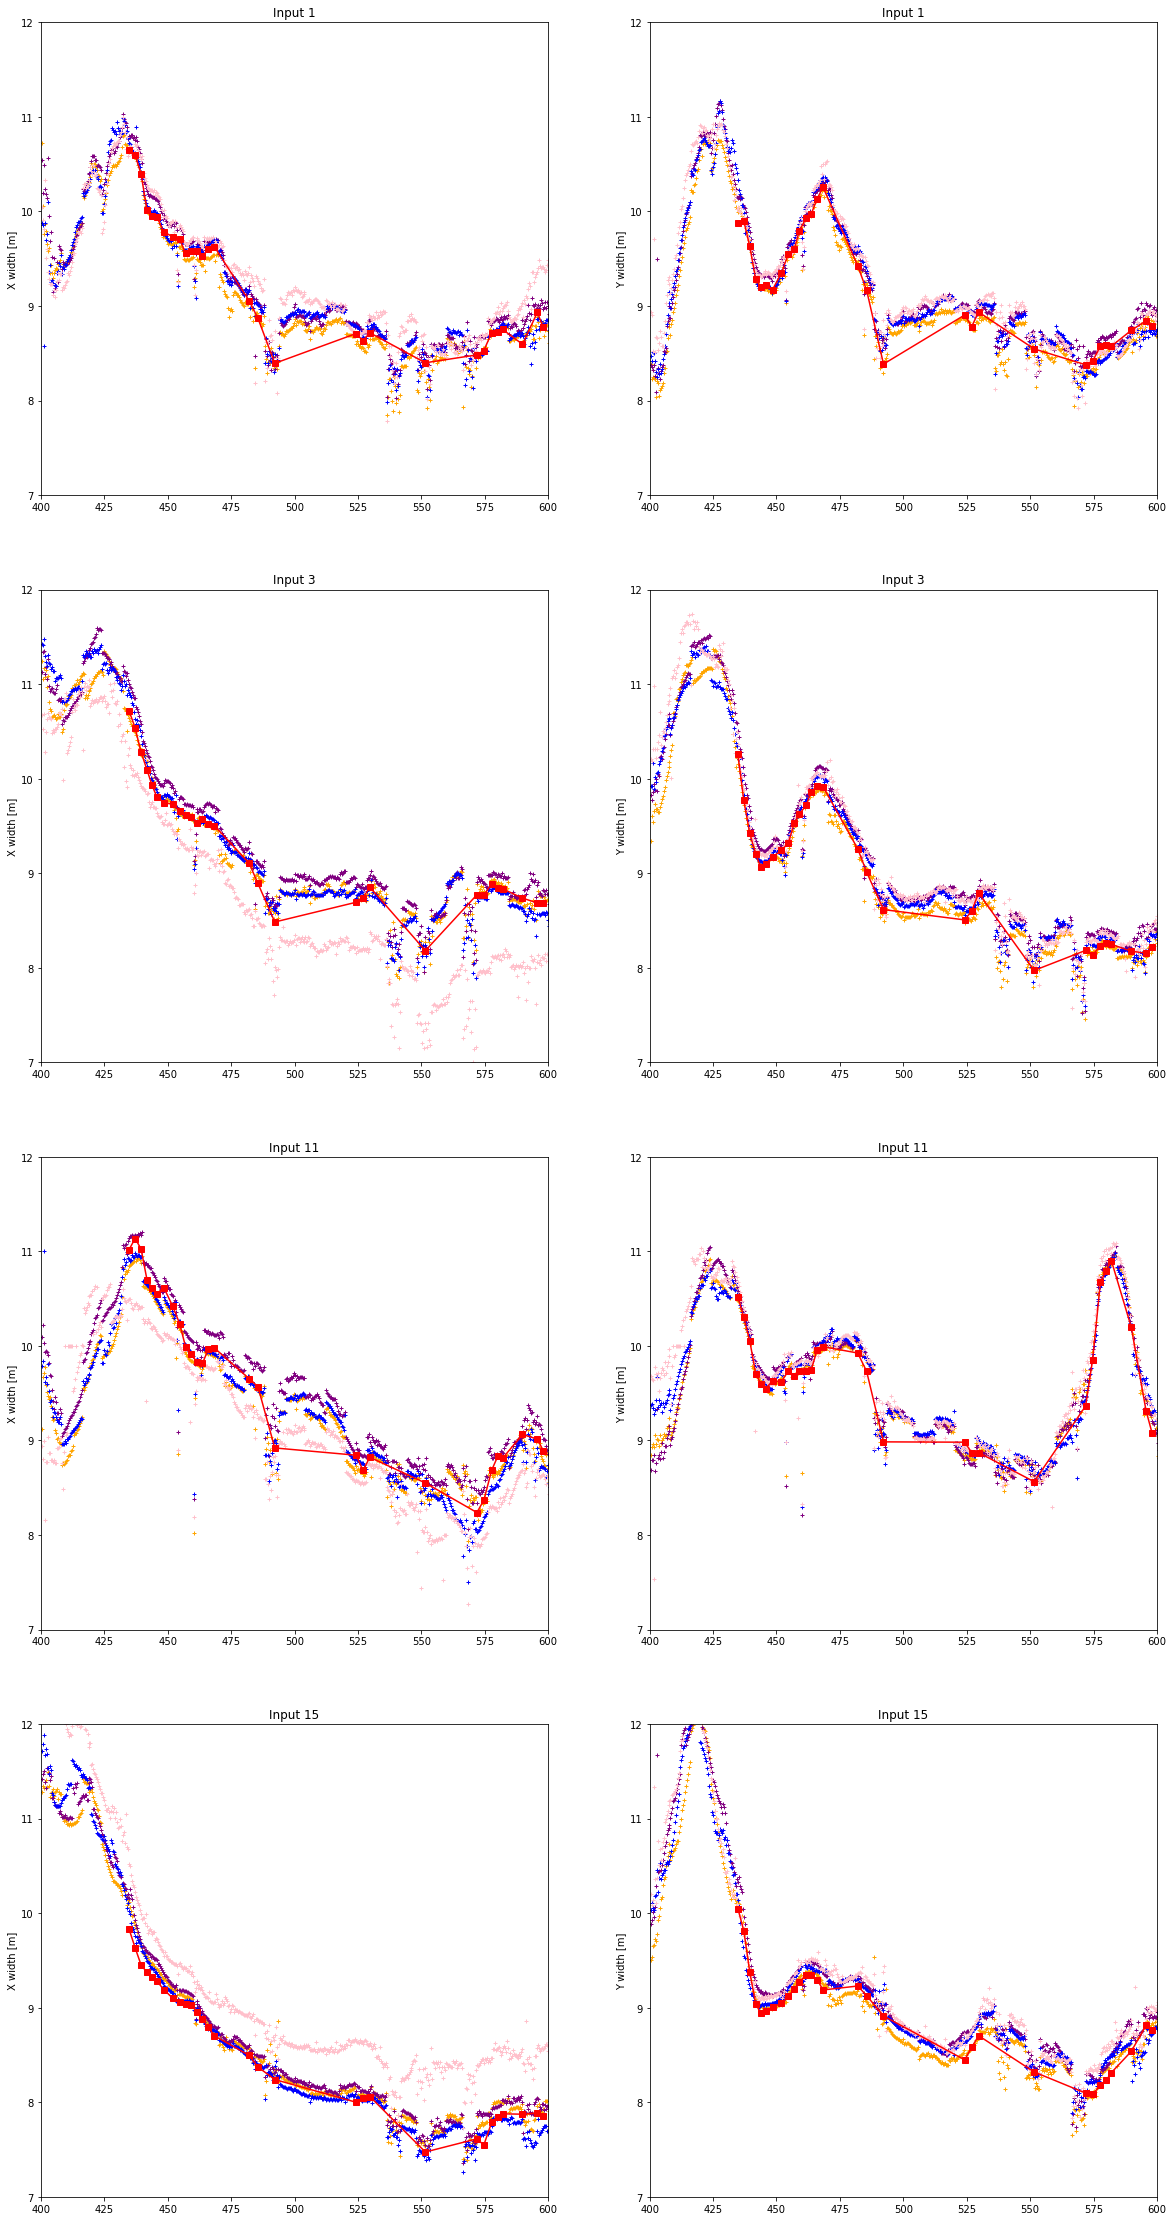

In [17]:
# let's recheck??

fig,axs = plt.subplots(4,2,figsize=(20,40))
for i,chind in enumerate(pols):
    for f,fly in enumerate(['618','619','623','625']):
        ffile = glob.glob(fitdir+'*'+fly+'*')[0]
        ffits = np.load(ffile)
        axs[i,0].plot(freqs,ffits['G_popt'][chind,:,2],
                 markersize=4,marker='+',color=colorf[f],linestyle='None',label=fly)
        axs[i,1].plot(freqs,ffits['G_popt'][chind,:,4],
                 markersize=4,marker='+',color=colorf[f],linestyle='None',label=fly)
    axs[i,0].set_title('Input '+str(chind))
    axs[i,1].set_title('Input '+str(chind))
    axs[i,0].set_ylabel('X width [m]')
    axs[i,1].set_ylabel('Y width [m]')
    axs[i,0].plot(freqs[good_freqs[::5]],abs(beam_fits[chind,good_freqs[::5],2]),color='red',marker='s')
    axs[i,1].plot(freqs[good_freqs[::5]],abs(beam_fits[chind,good_freqs[::5],4]),color='red',marker='s')
    axs[i,0].set_xlim(400,600)
    axs[i,1].set_xlim(400,600)
    axs[i,0].set_ylim(7,12)
    axs[i,1].set_ylim(7,12)
    print(beam_fits[pols,good_freqs[0],2],beam_fits[pols,good_freqs[0],4])
plt.show()

In [10]:
print(Epolflights)
pols = E_pols

['620', '648', '649', '535']


In [11]:
flights = ['620', '648', '649', '535']
concytest=[glob.glob(pckldir+'*'+fly+'*')[0] for fly in flights]

beam_fits = np.zeros([16,1024,6])

for f, find in enumerate(good_freqs[::10]):
    beam=ba.Beammap_forautoprocessing(concatlist=concytest,
        normalization='Gauss_wcorr',operation='coadd',mask=True,d0args=[-1*sz,sz,2.0],
        d1args=[-1*sz,sz,2.0],Fargs=[find,find+1,1])
    for c,chind in enumerate(pols):
        mbx = beam.d0_centers_grid[:,:,chind].flatten()
        mby = beam.d1_centers_grid[:,:,chind].flatten()
        mbV = beam.V_LC_operation[:,:,0,chind].flatten()
        gi = np.where(np.isfinite(mbV))[0]
        input_data=np.array([mbx[gi],mby[gi],mbV[gi]])
        beam_fits[chind,find,:] = least_squares(fu.Gauss_2d_LC_opt,x0=pG,method='trf',args=input_data).x


start of big ass loop is: 2024-03-07 21:22:59.572396
620 /hirax/GBO_Analysis_Outputs/main_beam_fits/FLY620_20211021T192212Z_2dGauss_and_Airy_Params.npz
648 /hirax/GBO_Analysis_Outputs/main_beam_fits/FLY648_20211022T191922Z_2dGauss_and_Airy_Params.npz
649 /hirax/GBO_Analysis_Outputs/main_beam_fits/FLY649_20211022T194308Z_2dGauss_and_Airy_Params.npz
535 /hirax/GBO_Analysis_Outputs/main_beam_fits/FLY535_20210826T192056Z_2dGauss_and_Airy_Params.npz
end of bigass loop is: 2024-03-07 21:23:05.216859   


/home/ln267/anaconda3/lib/python3.8/site-packages/beamcals/beam_autoprocessing.py:214: RuntimeWarning: invalid value encountered in true_divide
  self.V_LC_operation = np.nansum(self.V_LC_sum,axis=4)/self.V_LC_operation_count


start of big ass loop is: 2024-03-07 21:23:10.417161
620 /hirax/GBO_Analysis_Outputs/main_beam_fits/FLY620_20211021T192212Z_2dGauss_and_Airy_Params.npz
648 /hirax/GBO_Analysis_Outputs/main_beam_fits/FLY648_20211022T191922Z_2dGauss_and_Airy_Params.npz
649 /hirax/GBO_Analysis_Outputs/main_beam_fits/FLY649_20211022T194308Z_2dGauss_and_Airy_Params.npz
535 /hirax/GBO_Analysis_Outputs/main_beam_fits/FLY535_20210826T192056Z_2dGauss_and_Airy_Params.npz
end of bigass loop is: 2024-03-07 21:23:16.047173   
start of big ass loop is: 2024-03-07 21:23:21.215790
620 /hirax/GBO_Analysis_Outputs/main_beam_fits/FLY620_20211021T192212Z_2dGauss_and_Airy_Params.npz
648 /hirax/GBO_Analysis_Outputs/main_beam_fits/FLY648_20211022T191922Z_2dGauss_and_Airy_Params.npz
649 /hirax/GBO_Analysis_Outputs/main_beam_fits/FLY649_20211022T194308Z_2dGauss_and_Airy_Params.npz
535 /hirax/GBO_Analysis_Outputs/main_beam_fits/FLY535_20210826T192056Z_2dGauss_and_Airy_Params.npz
end of bigass loop is: 2024-03-07 21:23:26.805924

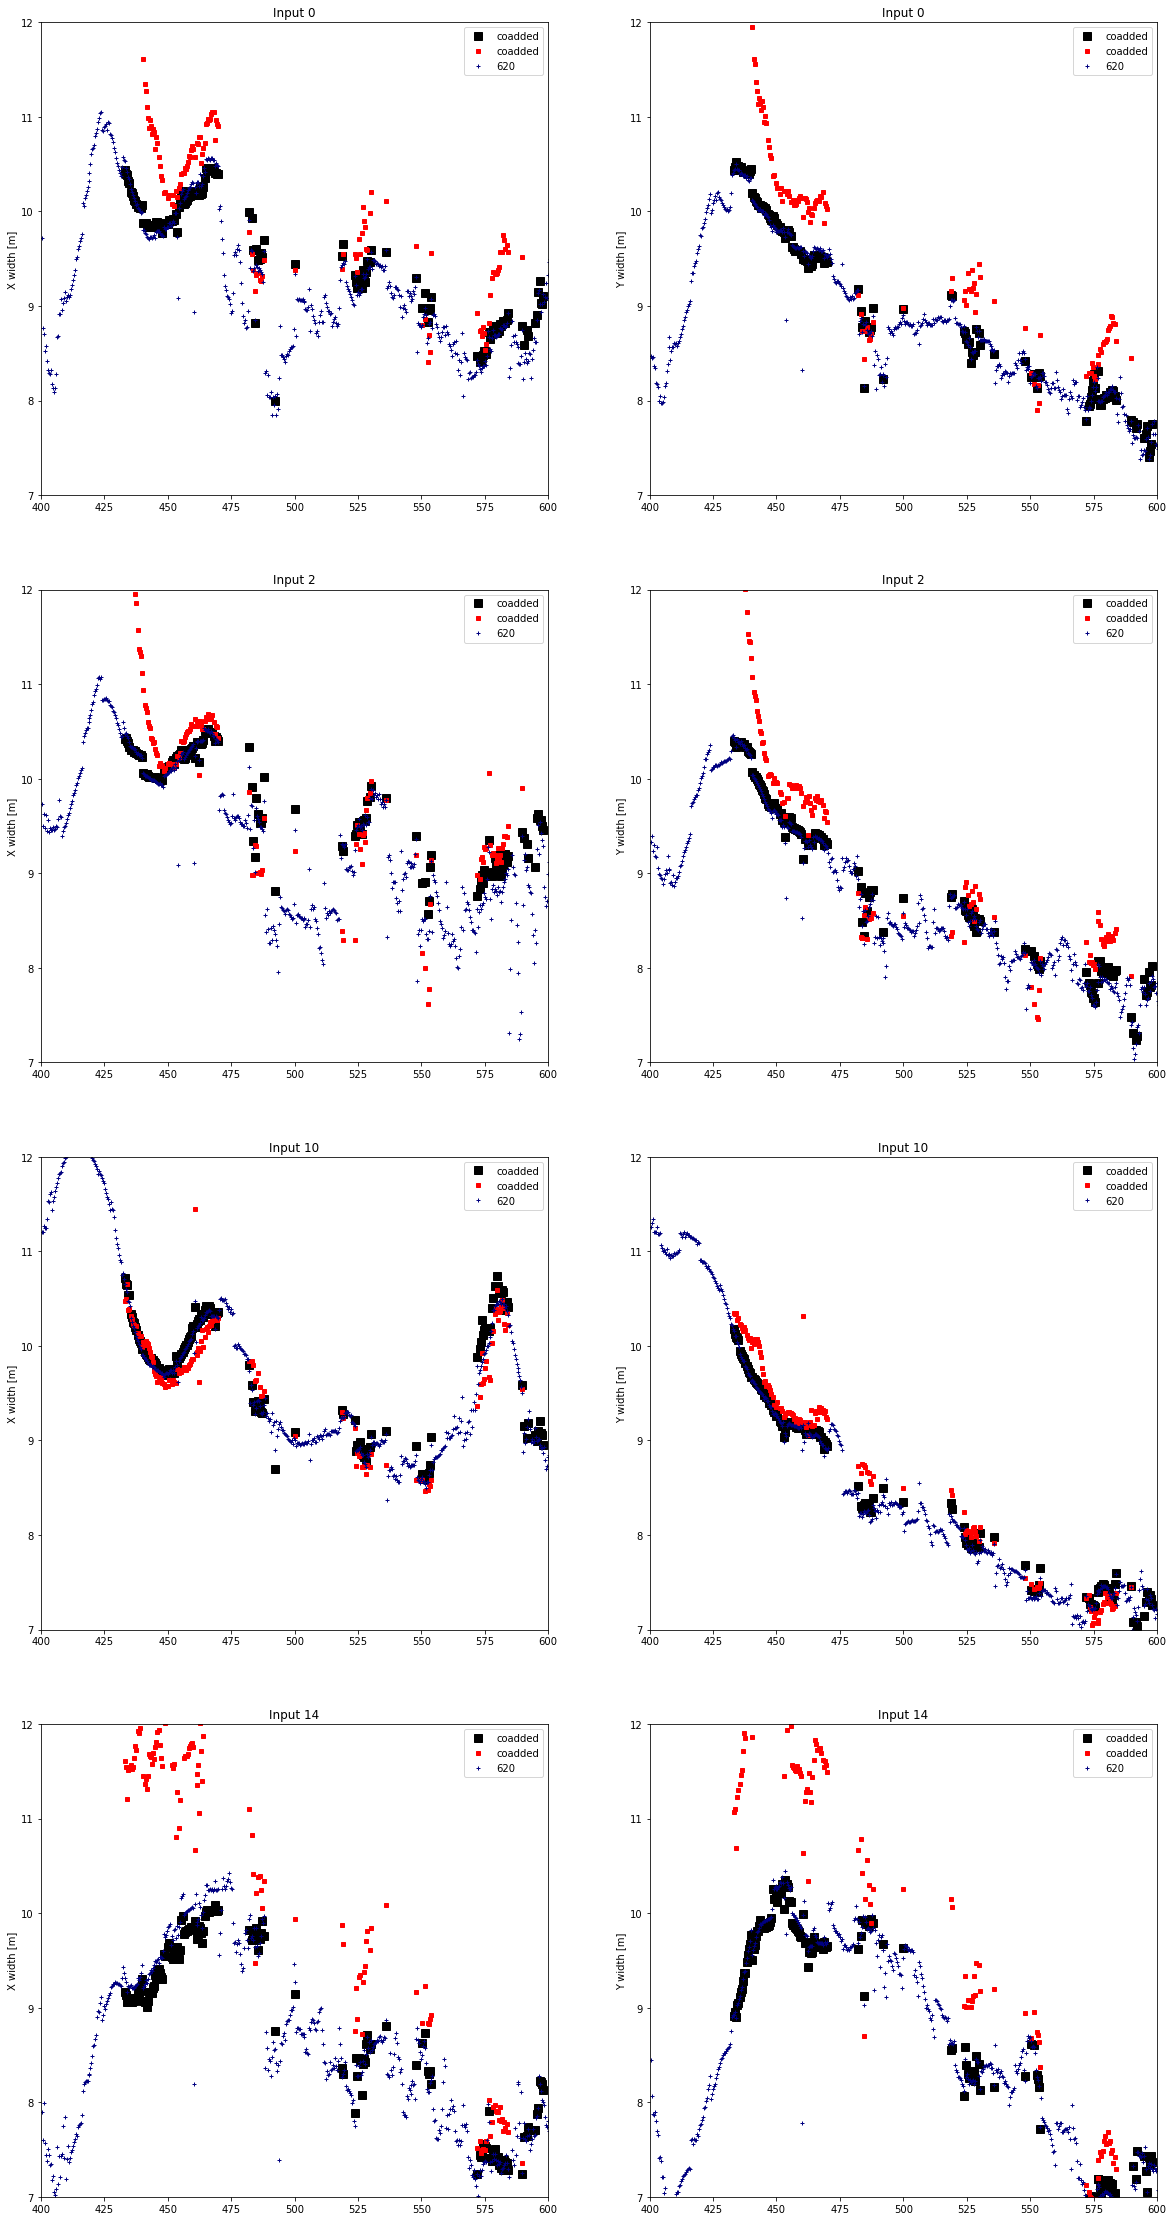

In [15]:
# let's recheck??

fig,axs = plt.subplots(4,2,figsize=(20,40))
for i,chind in enumerate(pols):
    axs[i,0].plot(freqs[good_freqs],coadded['G_popt'][chind,good_freqs,2,0],
                 markersize=8, marker='s',linestyle='None',color='black',label='coadded')
    axs[i,1].plot(freqs[good_freqs],coadded['G_popt'][chind,good_freqs,4,0],
                 markersize=8, marker='s',linestyle='None',color='black',label='coadded')
    
    axs[i,0].plot(freqs[good_freqs],coadded_old['G_popt'][chind,good_freqs,2,0],
                 markersize=4, marker='s',linestyle='None',color='red',label='coadded')
    axs[i,1].plot(freqs[good_freqs],coadded_old['G_popt'][chind,good_freqs,4,0],
                 markersize=4, marker='s',linestyle='None',color='red',label='coadded')
    
    for f,fly in enumerate(['620', '648', '649', '535']):
        ffile = glob.glob(fitdir+'*'+fly+'*')[0]
        ffits = np.load(ffile)
        axs[i,0].plot(freqs,ffits['G_popt'][chind,:,2],
                 markersize=4,marker='+',color=colorf[f],linestyle='None',label=fly)
        axs[i,1].plot(freqs,ffits['G_popt'][chind,:,4],
                 markersize=4,marker='+',color=colorf[f],linestyle='None',label=fly)
        
    axs[i,0].set_title('Input '+str(chind))
    axs[i,1].set_title('Input '+str(chind))
    axs[i,0].set_ylabel('X width [m]')
    axs[i,1].set_ylabel('Y width [m]')
    #axs[i,0].plot(freqs[good_freqs[::10]],abs(beam_fits[chind,good_freqs[::10],2]),color='red',marker='s')
    #axs[i,1].plot(freqs[good_freqs[::10]],abs(beam_fits[chind,good_freqs[::10],4]),color='red',marker='s')
    axs[i,0].set_xlim(400,600)
    axs[i,1].set_xlim(400,600)
    axs[i,0].set_ylim(7,12)
    axs[i,1].set_ylim(7,12)
    #print(beam_fits[pols,good_freqs[0],2],beam_fits[pols,good_freqs[0],4])
    axs[i,0].legend()
    axs[i,1].legend()
plt.show()

In [8]:
coadded = np.load('/hirax/GBO_Analysis_Outputs/Coadded_2dGauss_and_Airy_Param_w_errs_03_07_2024.npz')
list(coadded.keys())
#print(coadded['G_popt'][1,900,:,0]) # ch,fr,param


['G_popt']

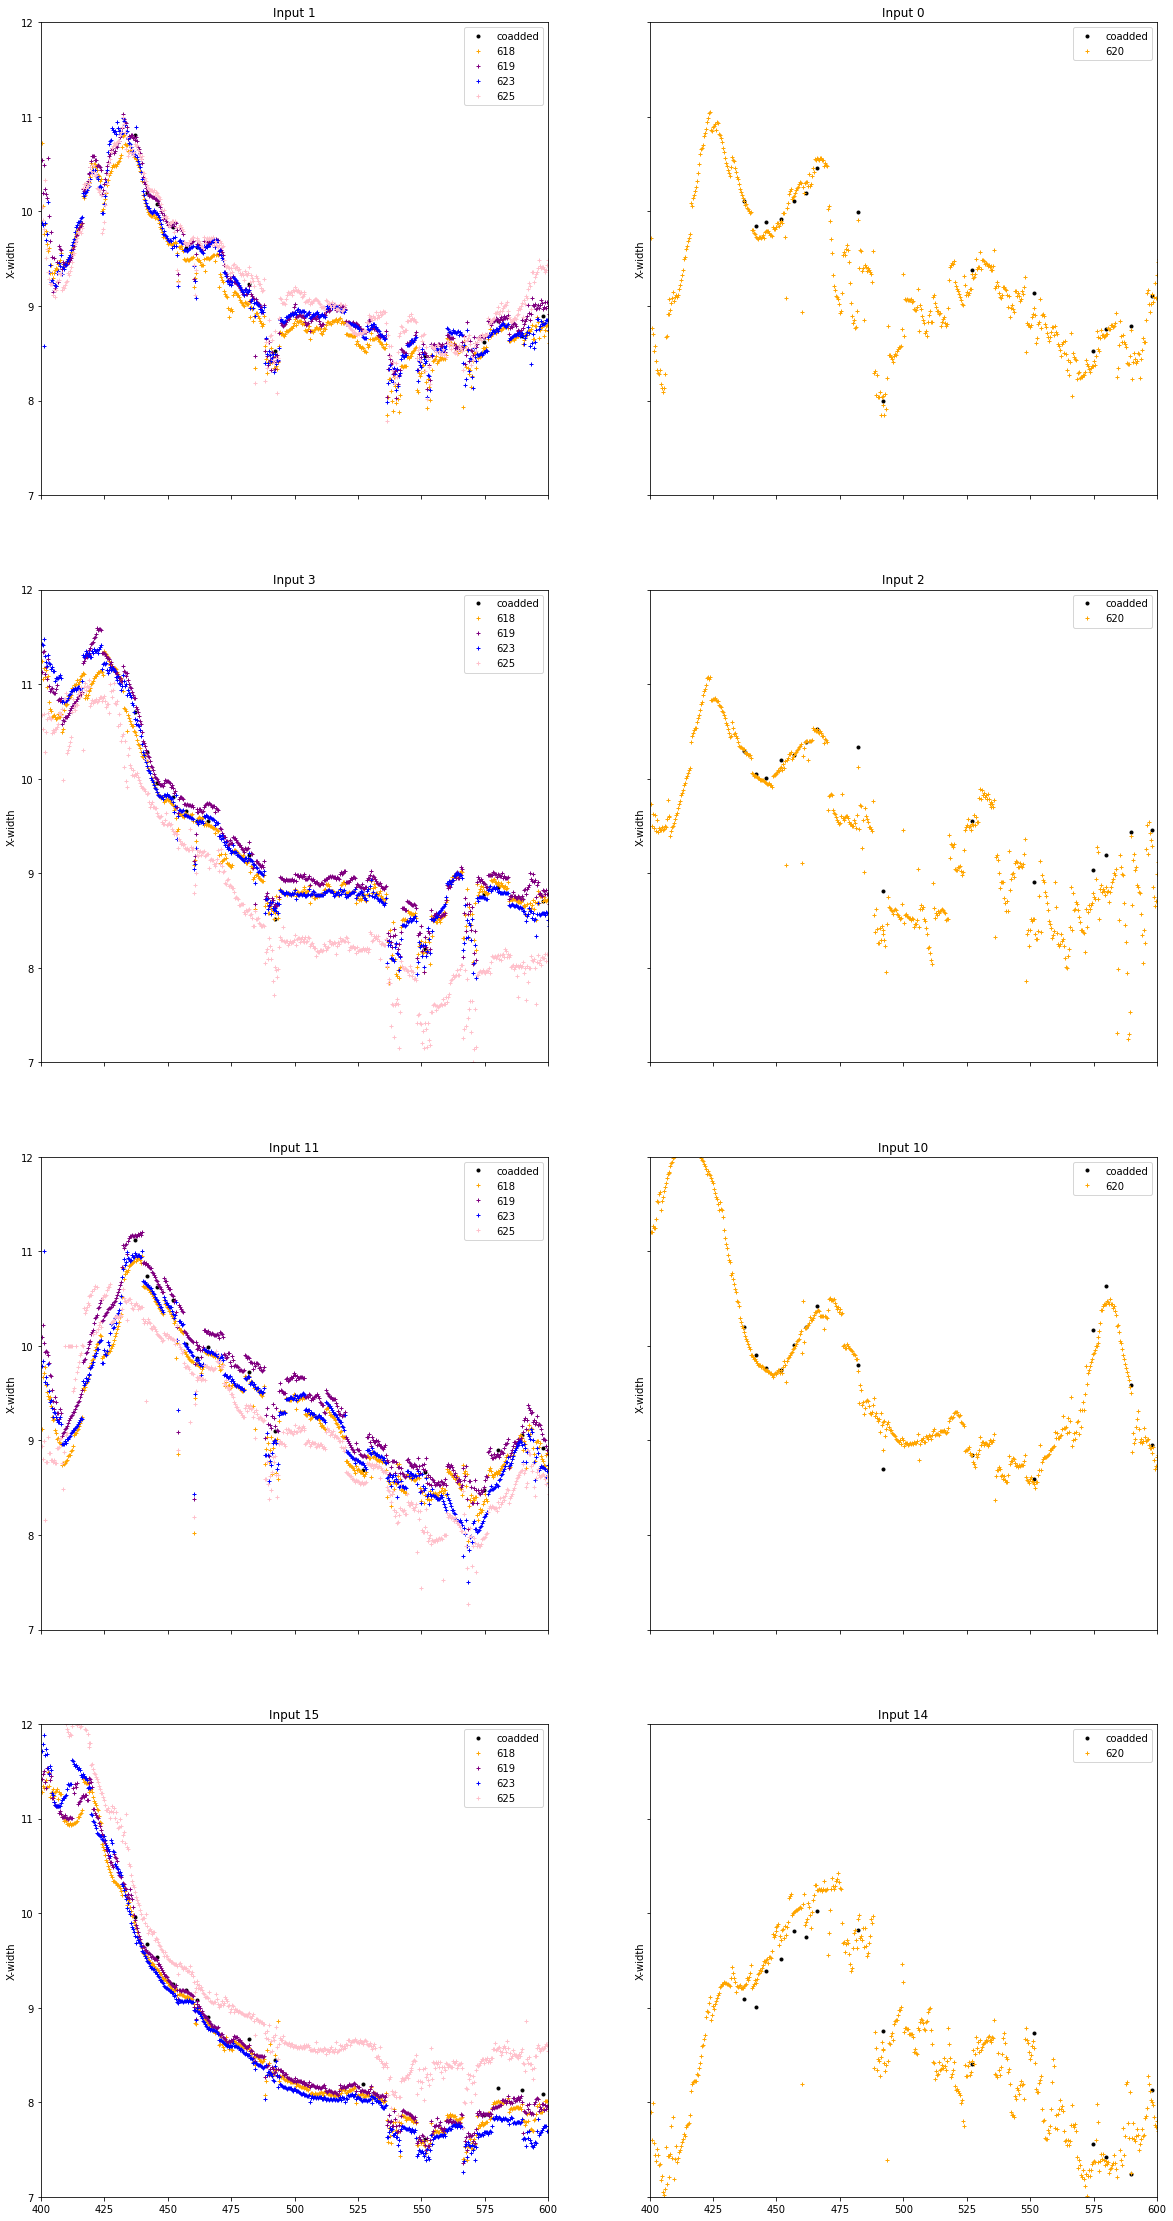

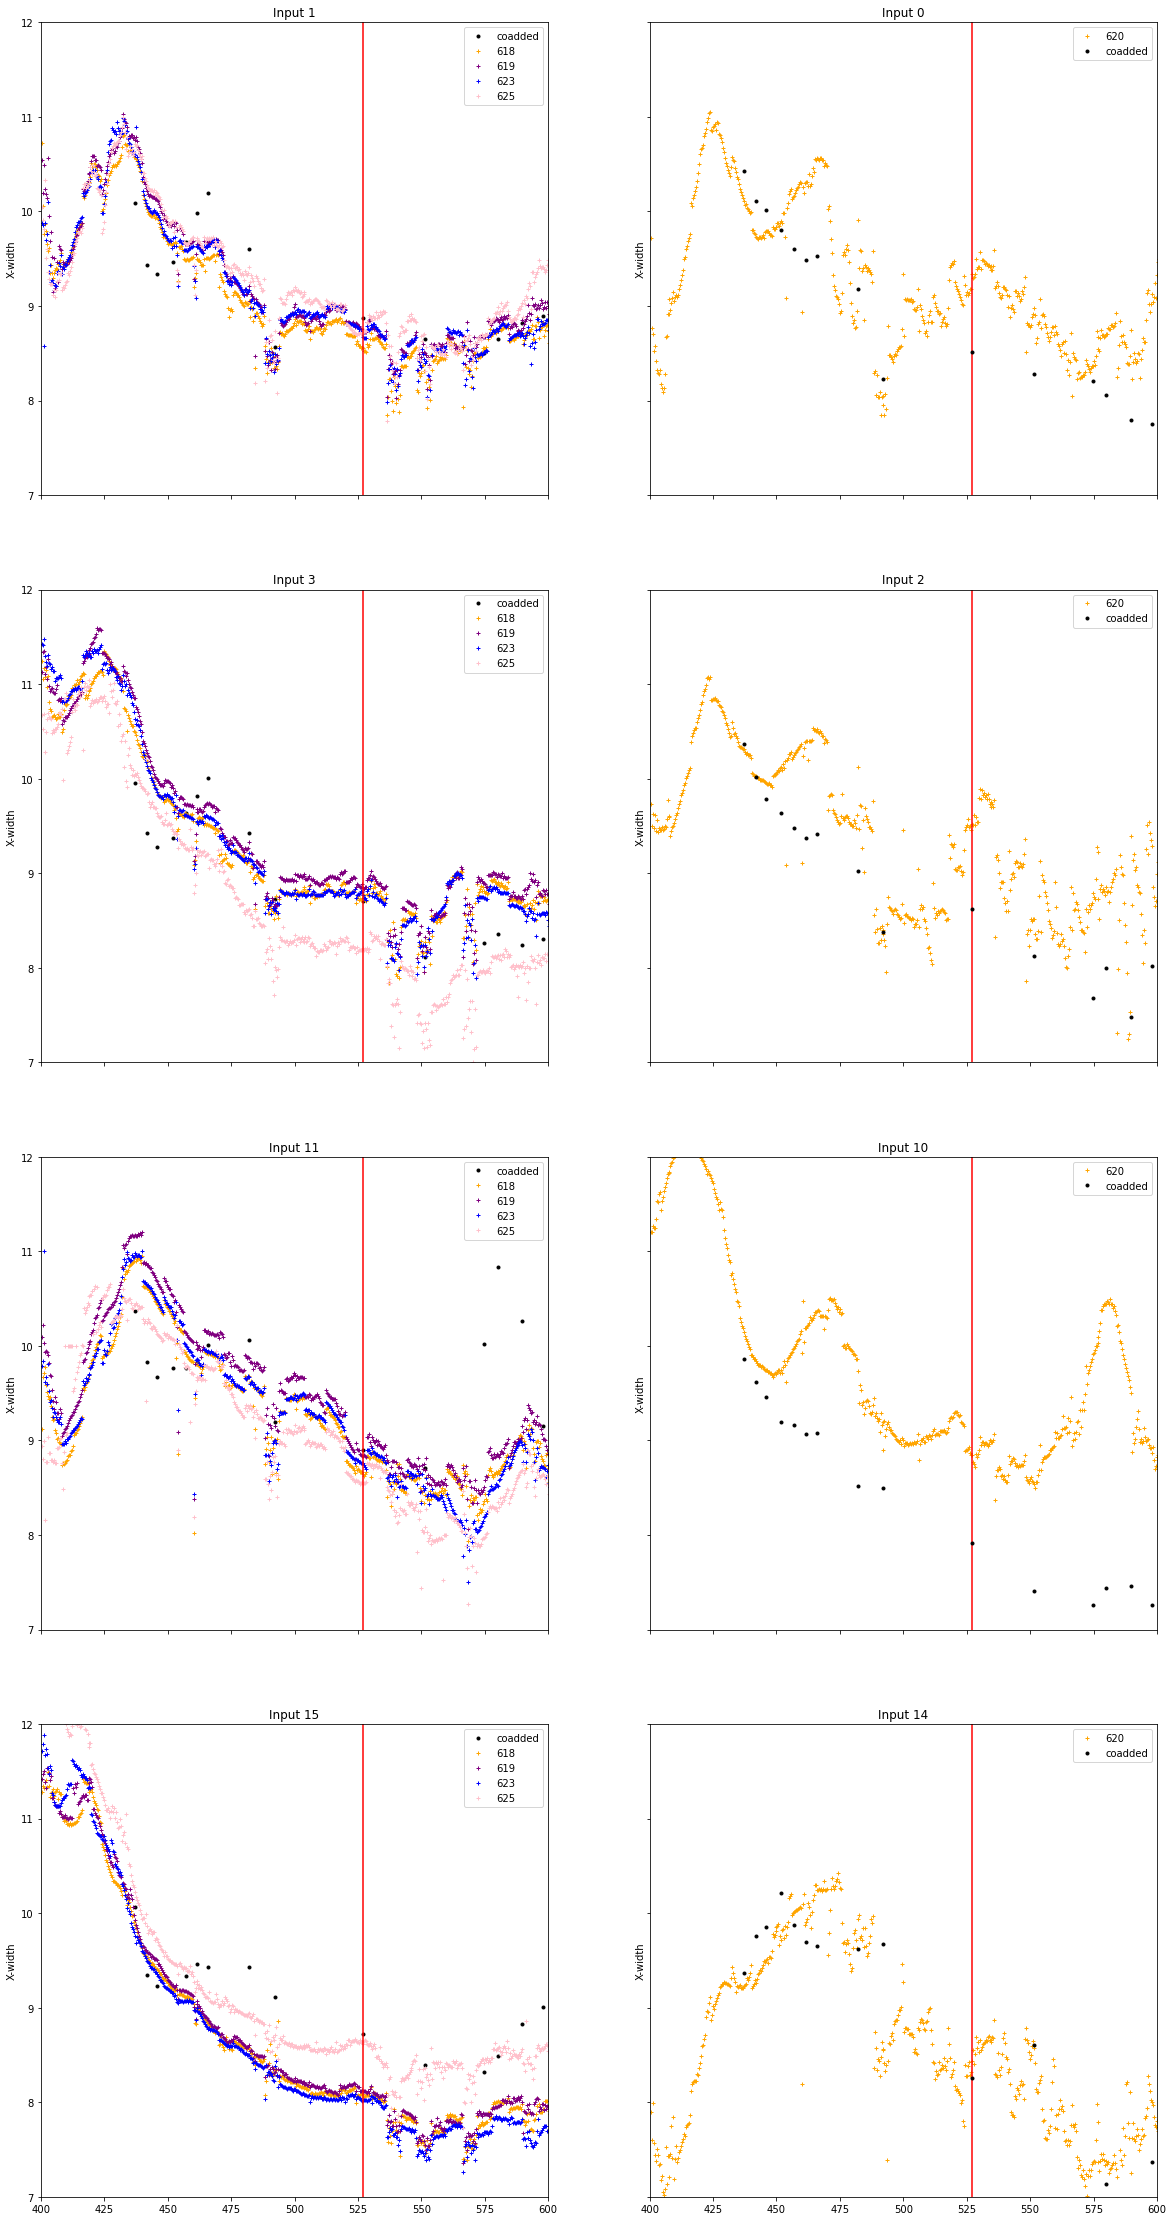

In [9]:
find = good_freqs[50]

colorz=pu.cm_to_discrete(ccm, 16)
colorf=['orange','purple','blue','pink']
fig,axs = plt.subplots(4,2, sharex=True,sharey=True,figsize=(20,40))

for i,chind in enumerate(N_pols):
    axs[i,0].plot(freqs[good_freqs],coadded['G_popt'][chind,good_freqs,2,0],marker='.',linestyle='None',color='black',label='coadded')
    for f,fly in enumerate(['618','619','623','625']):
        ffile = glob.glob(fitdir+'*'+fly+'*')[0]
        fits = np.load(ffile)
        axs[i,0].plot(freqs,fits['G_popt'][chind,:,2],
                 markersize=4,marker='+',color=colorf[f],linestyle='None',label=fly)
    axs[i,0].legend()
    axs[i,0].set_title('Input '+str(chind))
    axs[i,0].set_ylabel('X-width')
    axs[i,0].set_ylim(7,12)
    axs[i,0].set_xlim(400,600)
    #plt.show()
    
for i,chind in enumerate(E_pols):
    axs[i,1].plot(freqs[good_freqs],coadded['G_popt'][chind,good_freqs,2,0],marker='.',linestyle='None',color='black',label='coadded')
    for f,fly in enumerate(['620']):
        ffile = glob.glob(fitdir+'*'+fly+'*')[0]
        fits = np.load(ffile)
        axs[i,1].plot(freqs,fits['G_popt'][chind,:,2],
                 markersize=4,marker='+',color=colorf[f],linestyle='None',label=fly)
    axs[i,1].legend()
    axs[i,1].set_title('Input '+str(chind))
    axs[i,1].set_ylabel('X-width')
    axs[i,1].set_ylim(7,12)
    axs[i,1].set_xlim(400,600)
plt.show()


fig,axs = plt.subplots(4,2, sharex=True,sharey=True,figsize=(20,40))
for i,chind in enumerate(N_pols):
    axs[i,0].plot(freqs[good_freqs],coadded['G_popt'][chind,good_freqs,4,0],marker='.',linestyle='None',color='black',label='coadded')
    for f,fly in enumerate(['618','619','623','625']):
        ffile = glob.glob(fitdir+'*'+fly+'*')[0]
        fits = np.load(ffile)
        axs[i,0].plot(freqs,fits['G_popt'][chind,:,2],
                 markersize=4,marker='+',color=colorf[f],linestyle='None',label=fly)
    axs[i,0].legend()
    axs[i,0].set_title('Input '+str(chind))
    axs[i,0].set_ylabel('X-width')
    axs[i,0].set_ylim(7,12)
    axs[i,0].set_xlim(400,600)
    #plt.show()
    
for i,chind in enumerate(E_pols):
    axs[i,1].errorbar(freqs[good_freqs],coadded['G_popt'][chind,good_freqs,4,0],marker='.',linestyle='None',color='black',label='coadded')
    for f,fly in enumerate(['620']):
        ffile = glob.glob(fitdir+'*'+fly+'*')[0]
        fits = np.load(ffile)
        axs[i,1].plot(freqs,fits['G_popt'][chind,:,2],
                 markersize=4,marker='+',color=colorf[f],linestyle='None',label=fly)
    axs[i,1].axvline(freqs[find],color='red')
    axs[i,0].axvline(freqs[find],color='red')
    axs[i,1].legend()
    axs[i,1].set_title('Input '+str(chind))
    axs[i,1].set_ylabel('X-width')
    axs[i,1].set_ylim(7,12)
    axs[i,0].set_xlim(400,600)
plt.show()

# Fit all coadded maps and write to a file

In [5]:
###### LEAST SQUARES FITTING OF ALL COADDED MAPS #####
###### Only need to run this once!!!! ####
##
##
##print(good_freqs)
pG=np.array([1.0,0.0,9.0,0.0,9.0,1E-4])
fittingParamsWErrors = np.zeros([16, 1024,6,2])
restr = 18 # 30 #39 # 50 was default
#
## set which pol:
copoldir = 'N'
pols = N_pols
#
for f,find in enumerate(good_freqs):#

    picklefile = beamdir+'Beamcoadd_pol_'+copoldir+'_freq_'+str(find)+'.pkl'
    with open(picklefile, 'rb') as inp:
        ptest = pickle.load(inp)#
       
    for j, chind in enumerate(pols):        
        mbx = ptest.d0_centers_grid[:,:,chind].flatten()
        mby = ptest.d1_centers_grid[:,:,chind].flatten()
        mbV = ptest.V_LC_operation[:,:,0,chind].flatten()#

#        gi = np.where((np.isfinite(mbV)) & (np.abs(mbx) < restr) & (np.abs(mby) < restr))[0]
        gi = np.where(np.isfinite(mbV))[0]
        input_data=np.array([mbx[gi],mby[gi],mbV[gi]])
        G_popt = least_squares(fu.Gauss_2d_LC_opt,x0=pG,method='trf',args=input_data)
        fitParams = G_popt.x
        J = G_popt.jac    
        errmat = np.linalg.inv(J.T @ J) * (G_popt.fun.T @ G_popt.fun / (G_popt.fun.size - G_popt.x.size))
        param_errors = 1.95*np.sqrt(np.diag(errmat)) # This gives 95% confidence level
        fittingParamsWErrors[chind, find, :, 0] = fitParams
        fittingParamsWErrors[chind, find, :, 1] = param_errors

copoldir = 'E'
pols = E_pols

for f,find in enumerate(good_freqs):#

    picklefile = beamdir+'Beamcoadd_pol_'+copoldir+'_freq_'+str(find)+'.pkl'
    with open(picklefile, 'rb') as inp:
        ptest = pickle.load(inp)#

    for j, chind in enumerate(pols): 
        mbx = ptest.d0_centers_grid[:,:,chind].flatten()
        mby = ptest.d1_centers_grid[:,:,chind].flatten()
        mbV = ptest.V_LC_operation[:,:,0,chind].flatten()

#        gi = np.where((np.isfinite(mbV)) & (np.abs(mbx) < restr) & (np.abs(mby) < restr))[0]
        gi = np.where(np.isfinite(mbV))[0]
        input_data=np.array([mbx[gi],mby[gi],mbV[gi]])
        G_popt = least_squares(fu.Gauss_2d_LC_opt,x0=pG,method='trf',args=input_data)
        fitParams = G_popt.x
        J = G_popt.jac    
        errmat = np.linalg.inv(J.T @ J) * (G_popt.fun.T @ G_popt.fun / (G_popt.fun.size - G_popt.x.size))
        param_errors = 1.95*np.sqrt(np.diag(errmat)) # This gives 95% confidence level
        fittingParamsWErrors[chind, find, :, 0] = fitParams
        fittingParamsWErrors[chind, find, :, 1] = param_errors
        
tmpfitpath='/hirax/GBO_Analysis_Outputs/Coadded_2dGauss_and_Airy_Param_w_errs_03_09_2024.npz'
np.savez(tmpfitpath,G_popt = fittingParamsWErrors)

30.0

In [7]:
coadded_old = np.load('/hirax/GBO_Analysis_Outputs/Coadded_2dGauss_and_Airy_Param_w_errs_02_28_2024.npz')
coadded = np.load('/hirax/GBO_Analysis_Outputs/Coadded_2dGauss_and_Airy_Param_w_errs_03_08_2024.npz')
list(coadded.keys())
#print(coadded['G_popt'][1,900,:,0]) # ch,fr,param



['G_popt']

[10.97180696 11.03555898 11.03197686 11.09211597 11.15733089 11.13948797
 11.29808337 11.34267412 11.43682964 11.44989515]


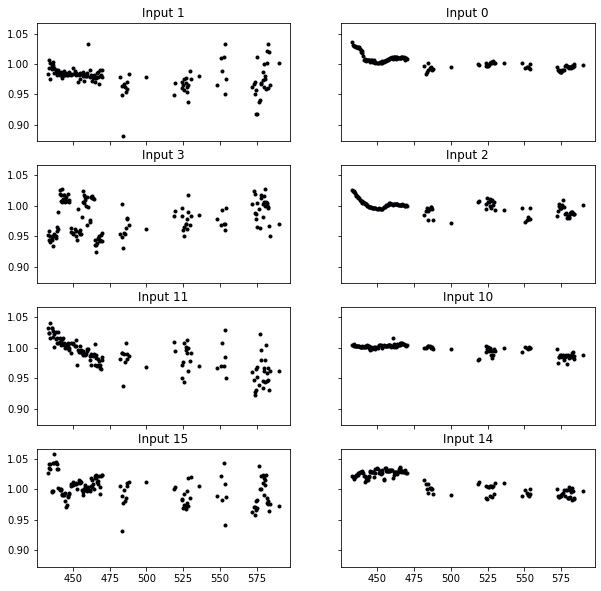

In [35]:
print(coadded['G_popt'][0,good_freqs[-1-10:-1],2,0])

# Basic check of amplitudes

    
colorz=pu.cm_to_discrete(ccm, 16)
fig,axs = plt.subplots(4, 2, sharex=True,sharey=True,figsize=(10,10))

for i,chind in enumerate(N_pols):
    axs[i,0].plot(freqs[good_freqs],coadded['G_popt'][chind,good_freqs,0,0],color=colorz[0],
                  marker='.',linestyle='None')
    #axs[i].axhline(1.0,color='red',linestyle='-.')
    axs[i,0].set_title('Input '+str(chind))
for i,chind in enumerate(E_pols):
    axs[i,1].plot(freqs[good_freqs],coadded['G_popt'][chind,good_freqs,0,0],color=colorz[0],
                  marker='.',linestyle='None')
    #axs[i].axhline(1.0,color='red',linestyle='-.')
    axs[i,1].set_title('Input '+str(chind))
plt.show()

# This checks if the gridding was to blame (keep since its useful for one-off gridding)

Working on Frequency:  563 580.078125
start of big ass loop is: 2024-02-29 14:59:24.463764
646 /hirax/GBO_Analysis_Outputs/main_beam_fits/FLY646_20211022T183659Z_2dGauss_and_Airy_Params.npz
end of bigass loop is: 2024-02-29 14:59:28.587430   


/home/ln267/anaconda3/lib/python3.8/site-packages/beamcals/beam_autoprocessing.py:214: RuntimeWarning: invalid value encountered in true_divide
  self.V_LC_operation = np.nansum(self.V_LC_sum,axis=4)/self.V_LC_operation_count


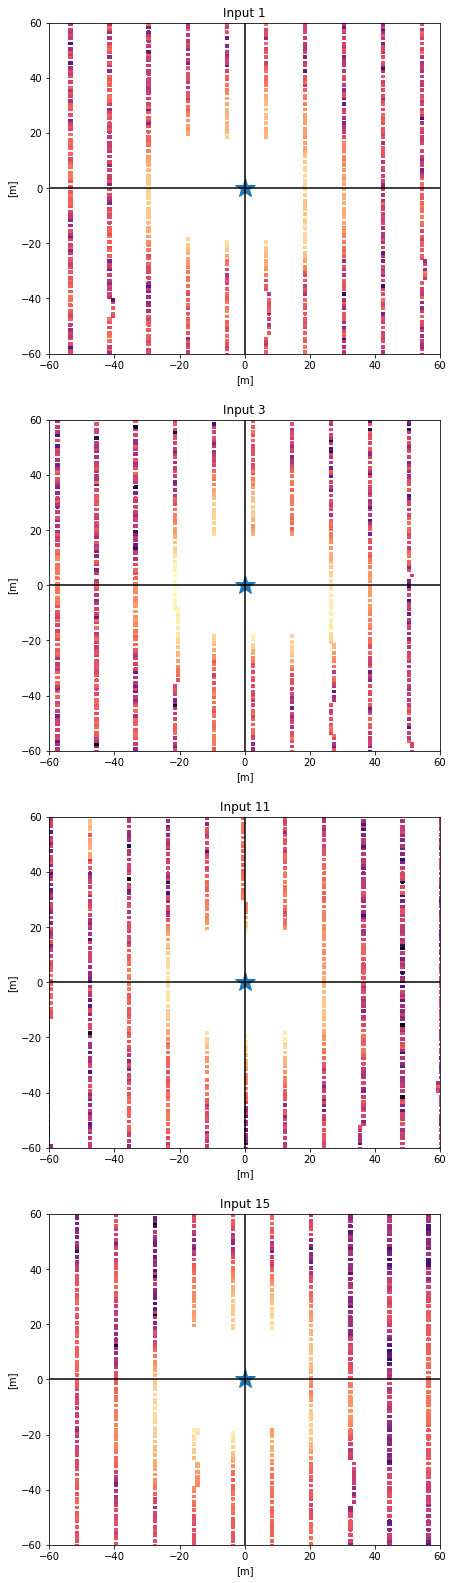

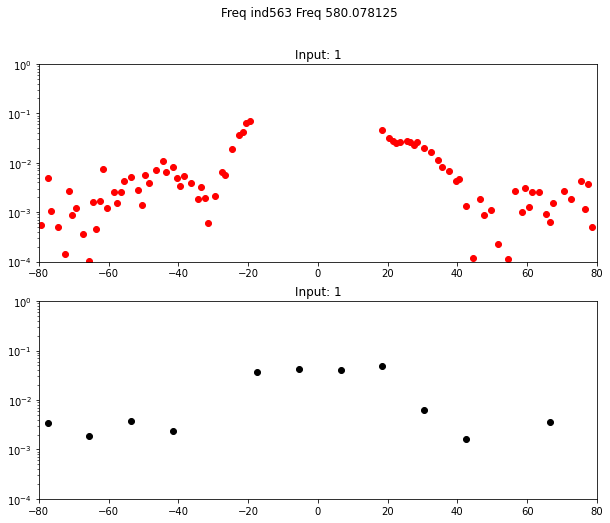

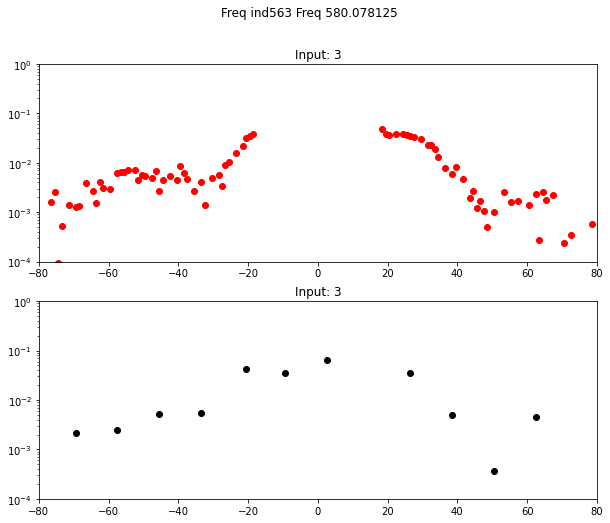

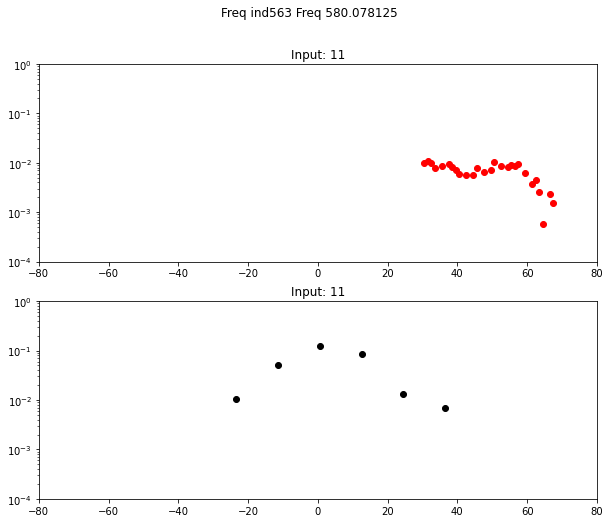

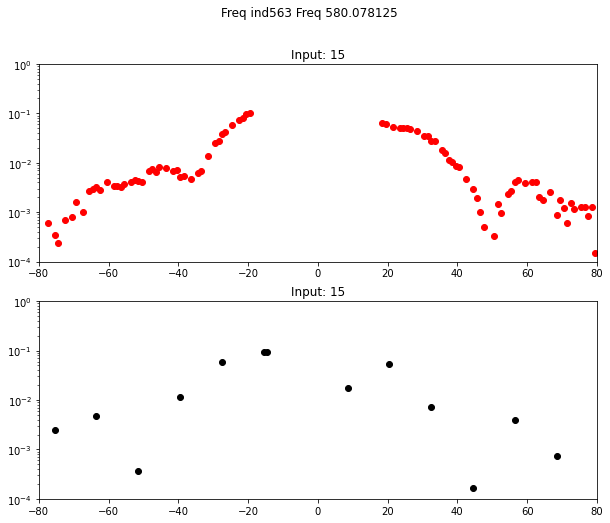

In [67]:
## THIS RUNS ANALYSIS BY MAKING A BEAM FOR A SINGLE FLIGHT #### COMMENTED OUT FOR QUICK RUNNING


## Now grid the data and see what happens, then fit a Gaussian to all frequencies



find = good_freqs[10]
print('Working on Frequency: ',find,freqs[find])
pols = N_pols

flights = ['646']
concytest=[glob.glob(pckldir+'*'+fly+'*')[0] for fly in flights]

beam=ba.Beammap_forautoprocessing(concatlist=concytest,
        normalization='Gauss_wcorr',operation='coadd',mask=True,d0args=[-1*sz,sz,0.5],
        d1args=[-1*sz,sz,0.5],Fargs=[find,find+1,1])
    
    
## Look at the grids and check it looks centered

# Npol flights
fig,axs = plt.subplots(4,1,figsize=(7,28))
for i,chind in enumerate(pols):
    
    axs[i].pcolormesh(beam.d0_edges_grid[:,:,chind],
                        beam.d1_edges_grid[:,:,chind],
                        np.abs(beam.V_LC_operation[:,:,0,chind]),cmap=cm.magma,norm=LogNorm())#,edgecolors='k')
    axs[i].plot(0,0,marker='*',markersize=20)
    axs[i].axvline(0,c='k')
    axs[i].axhline(0,c='k')
    axs[i].set_xlim(-60,60)
    axs[i].set_ylim(-60,60)
    axs[i].set_title('Input '+str(chind))
    axs[i].set_xlabel('[m]')
    axs[i].set_ylabel('[m]')
    
    mbx = beam.x_centers_grid[:,:,chind].flatten()
    mby = beam.y_centers_grid[:,:,chind].flatten()
    mbV = beam.V_LC_operation[:,:,0,chind].flatten()
    gi = np.where(np.isfinite(mbV))[0]
    input_data=np.array([mbx[gi],mby[gi],mbV[gi]])
    fits = least_squares(fu.Gauss_2d_LC_opt,x0=pG,method='trf',args=input_data).x
    print(find, chind, m_to_FWHM(fits[chind,find,2]),m_to_FWHM(fits[chind,find,4])
    
plt.show()


xx = 0
chind = pols[0]
colx = get_slice(beam.d0_centers_grid[:,:,chind],beam.d1_centers_grid[:,:,chind],
                 beam.V_LC_operation[:,:,0,chind],xx,'v')
coly = get_slice(beam.d0_centers_grid[:,:,chind],beam.d1_centers_grid[:,:,chind],
                 beam.V_LC_operation[:,:,0,chind],xx,'h')

# colx: use for constant x, let y vary: vertical slice 
# coly: use for constany y, let x vary: horizontal slice

for chind in pols:

    colx = get_slice(beam.d0_centers_grid[:,:,chind],beam.d1_centers_grid[:,:,chind],
                 beam.V_LC_operation[:,:,0,chind],xx,'v')
    coly = get_slice(beam.d0_centers_grid[:,:,chind],beam.d1_centers_grid[:,:,chind],
                 beam.V_LC_operation[:,:,0,chind],xx,'h')

    fig = plt.figure(figsize=(10,8))
    plt.subplot(2,1,1)
    plt.semilogy(beam.d1_centers_grid[colx,:,chind],beam.V_LC_operation[colx,:,0,chind],'o',
             label='Coadd x :'+str(beam.d0_centers_grid[colx,0,0]),color='red')
    plt.title('Input: '+str(chind))
    plt.ylim(0.0001,1)
    plt.xlim(-1*sz,sz)
    #plt.legend(loc='lower center')
    plt.subplot(2,1,2)
    plt.semilogy(beam.d0_centers_grid[:,coly,0],beam.V_LC_operation[:,coly,0,chind],'o',
             label='Coadd  y :'+str(beam.d1_centers_grid[0,coly,0]),color='black')
    plt.ylim(0.0001,1)
    plt.xlim(-1*sz,sz)
    plt.title('Input: '+str(chind))
    #plt.legend(loc='lower center')
    plt.suptitle('Freq ind'+str(find)+' Freq '+str(freqs[find]))
    plt.show()
    
    
    

    
    
#G_new_coadd = np.zeros([16,1024,6])
#pG=np.array([1.0,0.0,8.0,0.0,8.0,1E-8])
#copoldir = 'N'
#pols = N_pols
#sz=40

#for find in good_freqs:
#    print('Working on Frequency: ',find,freqs[find])
#
#    flights = ['619']
#    concytest=[glob.glob(pckldir+'*'+fly+'*')[0] for fly in flights]
#    beam=ba.Beammap_forautoprocessing(concatlist=concytest,
#                 normalization='Gauss_wcorr',operation='coadd',mask=True,Xargs=[-41,41,2],
#                 Yargs=[-41,41,2],Fargs=[find,find+1,1])

#    for j, chind in enumerate(pols): 
#        mbx = beam.x_centers_grid[:,:,chind].flatten()
#        mby = beam.y_centers_grid[:,:,chind].flatten()
#        mbV = beam.V_LC_operation[:,:,0,chind].flatten()
#        #gi = np.where((np.isfinite(mbV)) & (np.abs(mbx) < restr) & (np.abs(mby) < restr))[0]
#        gi = np.where(np.isfinite(mbV))[0]
#        input_data=np.array([mbx[gi],mby[gi],mbV[gi]])
#        G_new_coadd[chind,find,:] = least_squares(fu.Gauss_2d_LC_opt,x0=pG,method='trf',args=input_data).x
#        #print(find, chind, m_to_FWHM(G_new_coadd[chind,find,2]),m_to_FWHM(G_new_coadd[chind,find,4])
        
#print('DONE!!')


#fig,axs = plt.subplots(5,2, sharex=True,sharey=True,figsize=(20,40))

#for i,chind in enumerate(N_pols):
#    axs[i,0].plot(freqs[good_freqs],m_to_FWHM(fl625.G_popt[chind,good_freqs,2]),color=colorz[0],
#                  marker='.',linestyle='None',label='Original fit')
#    axs[i,1].plot(freqs[good_freqs],m_to_FWHM(fl625.G_popt[chind,good_freqs,4]),color=colorz[0],
#                  marker='.',linestyle='None',label='Original fit')
#    
#    
#    axs[i,0].plot(freqs[good_freqs],m_to_FWHM(abs(Gpopt_new[chind,good_freqs,2])),color=colorz[8],
#                  marker='.',linestyle='None',label='xyz_per_dish fit')        
#    axs[i,1].plot(freqs[good_freqs],m_to_FWHM(abs(Gpopt_new[chind,good_freqs,4])),color=colorz[8],
#                  marker='.',linestyle='None',label='xyz_per_dish fit')
#    
#    axs[i,0].plot(freqs[good_freqs],m_to_FWHM(G_new_coadd[chind,good_freqs,2]),color=colorz[15],
#                  marker='.',linestyle='None',label='after gridding')        
#    axs[i,1].plot(freqs[good_freqs],m_to_FWHM(G_new_coadd[chind,good_freqs,4]),color=colorz[15],
#                  marker='.',linestyle='None',label='after_gridding')
#    
#    axs[i,0].legend()
#    axs[i,0].set_title('Input '+str(chind))
#    axs[i,0].set_ylabel('X-width')
#    axs[i,0].set_ylim(5,9)
#    axs[i,0].set_xlim(400,600)
#    axs[i,1].legend()
#    axs[i,1].set_title('Input '+str(chind))
#    axs[i,1].set_ylabel('Y-width')
#    axs[i,1].set_ylim(5,9)
#    axs[i,1].set_xlim(400,600)
#plt.suptitle('Gridding 2.0m and centered on (0,0), Flight: '+fly)
#plt.show()

563 1 12.665373253962603 10.559742978870032
563 3 12.000866399193193 8.344842121882115
563 11 8.77520085160603 8.203823219505727
563 15 11.523380281090127 12.852459152703542


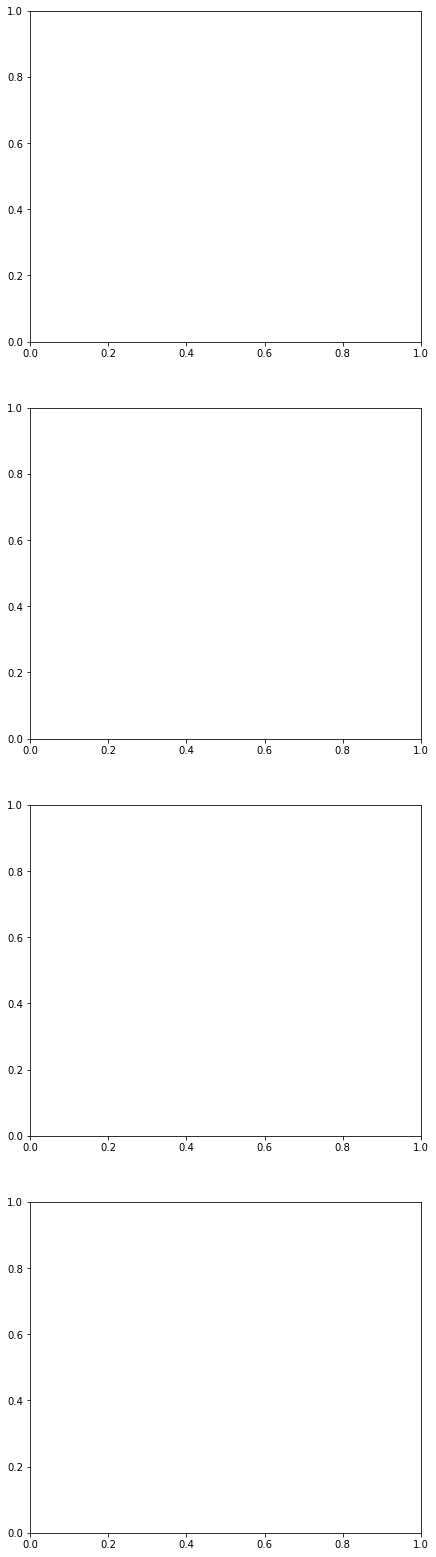

In [74]:
# Npol flights
fig,axs = plt.subplots(4,1,figsize=(7,28))
for i,chind in enumerate(pols):

    mbx = beam.d0_centers_grid[:,:,chind].flatten()
    mby = beam.d1_centers_grid[:,:,chind].flatten()
    mbV = beam.V_LC_operation[:,:,0,chind].flatten()
    gi = np.where(np.isfinite(mbV))[0]
    input_data=np.array([mbx[gi],mby[gi],mbV[gi]])
    fits = least_squares(fu.Gauss_2d_LC_opt,x0=pG,method='trf',args=input_data).x
    print(find, chind, m_to_FWHM(fits[2]),m_to_FWHM(fits[4]))
    



In [30]:
G_new_coadd = np.zeros([16,1024,6])
pG=np.array([1.0,0.0,10.0,0.0,10.0,1E-4])
copoldir = 'N'
pols = N_pols
sz=40
restr = 40 




Npolflights = ['618','619','623','625','646','647','533']
Epolflights = ['620','648','649','535']

fly = '618'
pol, pols, cpols, attn, fi = get_flightinfo(fly)
print(fly,pol,pols,cpols, attn)
concytest=[glob.glob(pckldir+'*'+fly+'*')[0] for x in Npolflights]
print(concytest[fi],pcklarr[[fi]],gfitarr[[fi]])
    
with open(glob.glob(pckldir+'*'+fly+'*')[0], 'rb') as pfile:
    print(pfile)
    concattest1=pickle.load(pfile)
t_cut=concattest1.inds_on



for find in good_freqs[::4]:
    print('Working on Frequency: ',find,freqs[find])

    #beam=ba.Beammap_forautoprocessing(concatlist=concytest,
    #             normalization='Gauss_wcorr',operation='coadd',mask=True,d0args=[-40,40,1],
    #             d1args=[-40,40,1],Fargs=[find,find+1,1])

    beam=bp.Beammap(concatlist=pcklarr[[fi]],gfitlist=gfitarr[[fi]],coordsys='cartesian',
                 normalization='Gauss',operation='coadd',d0args=[-40,40,1.0],
                 d1args=[-40,40,1.0],Fargs=[find,find+1,1],f_index_cc=find,vplot=False)
    
    for j, chind in enumerate(pols): 
        mbx = beam.d0_centers_grid[:,:,chind].flatten()
        mby = beam.d1_centers_grid[:,:,chind].flatten()
        mbV = beam.V_LC_operation[:,:,0,chind].flatten()

        #gi = np.where((np.isfinite(mbV)) & (np.abs(mbx) < restr) & (np.abs(mby) < restr))[0]
        gi = np.where(np.isfinite(mbV))[0]
        input_data=np.array([mbx[gi],mby[gi],mbV[gi]])
        G_new_coadd[chind,find,:] = least_squares(fu.Gauss_2d_LC_opt,x0=pG,method='trf',args=input_data).x
        #print(find, chind, m_to_FWHM(G_new_coadd[chind,find,2]),m_to_FWHM(G_new_coadd[chind,find,4])
        
print('DONE!!')

618 N [1, 3, 11, 15] [0, 2, 10, 14] 46
/hirax/GBO_Analysis_Outputs/flight_pickles/FLY618_20211021T183430Z_ver_20231012T003521_concat.pkl ['FLY618_20211021T183430Z_ver_20231012T003521_concat.pkl'] ['FLY618_20211021T183430Z_2dGauss_and_Airy_Params.npz']
<_io.BufferedReader name='/hirax/GBO_Analysis_Outputs/flight_pickles/FLY618_20211021T183430Z_ver_20231012T003521_concat.pkl'>
Working on Frequency:  538 589.84375
start of concat loop is: 2024-03-03 22:23:26.874426
end of concat loop is: 2024-03-03 22:23:29.351472          


/home/ln267/anaconda3/lib/python3.8/site-packages/beamcals/beammap.py:368: RuntimeWarning: Mean of empty slice
  self.V_LC_operation=np.nanmean(self.V_LC_mean,axis=4)


Working on Frequency:  557 582.421875
start of concat loop is: 2024-03-03 22:23:31.793391
end of concat loop is: 2024-03-03 22:23:34.271634          
Working on Frequency:  561 580.859375
start of concat loop is: 2024-03-03 22:23:36.710173
end of concat loop is: 2024-03-03 22:23:39.211449          
Working on Frequency:  565 579.296875
start of concat loop is: 2024-03-03 22:23:41.554700
end of concat loop is: 2024-03-03 22:23:44.108988          
Working on Frequency:  571 576.953125
start of concat loop is: 2024-03-03 22:23:46.480107
end of concat loop is: 2024-03-03 22:23:48.956986          
Working on Frequency:  577 574.609375
start of concat loop is: 2024-03-03 22:23:51.374646
end of concat loop is: 2024-03-03 22:23:53.853591          
Working on Frequency:  581 573.046875
start of concat loop is: 2024-03-03 22:23:56.269904
end of concat loop is: 2024-03-03 22:23:58.745313          
Working on Frequency:  632 553.125
start of concat loop is: 2024-03-03 22:24:01.085472
end of concat

In [29]:
print(m_to_FWHM(G_new_coadd[N_pols,find,:]),m_to_FWHM(G_new_coadd[N_pols,find,4]))

[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]] [0. 0. 0. 0.]


# Compare fits between flights and coadds

In [22]:
coadded = np.load('/hirax/GBO_Analysis_Outputs/Coadded_2dGauss_and_Airy_Param_w_errs_02_28_2024.npz')
list(coadded.keys())
#print(coadded['G_popt'][1,900,:,0]) # ch,fr,param


['G_popt']

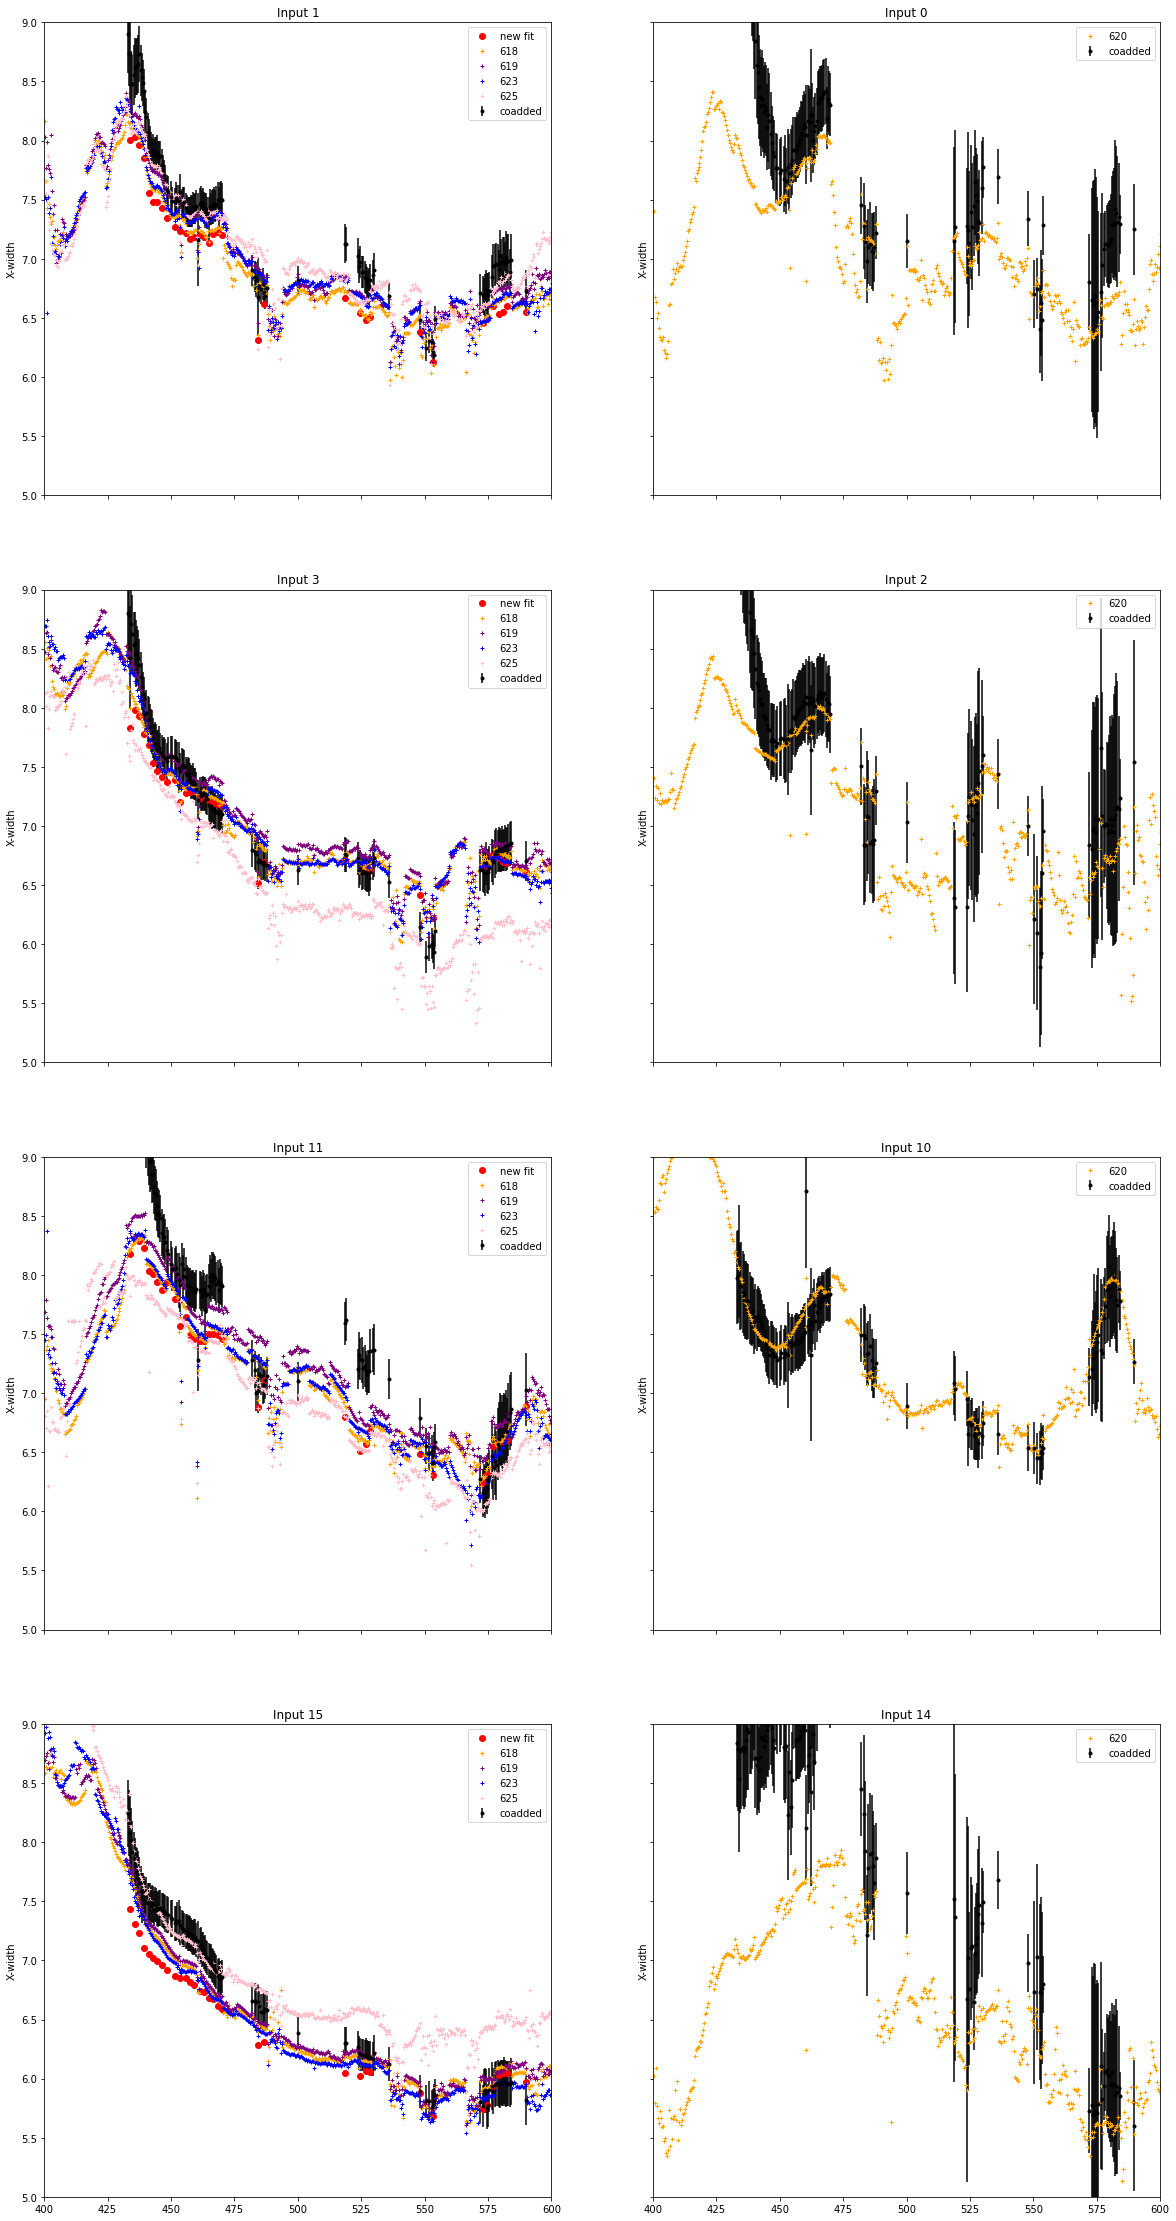

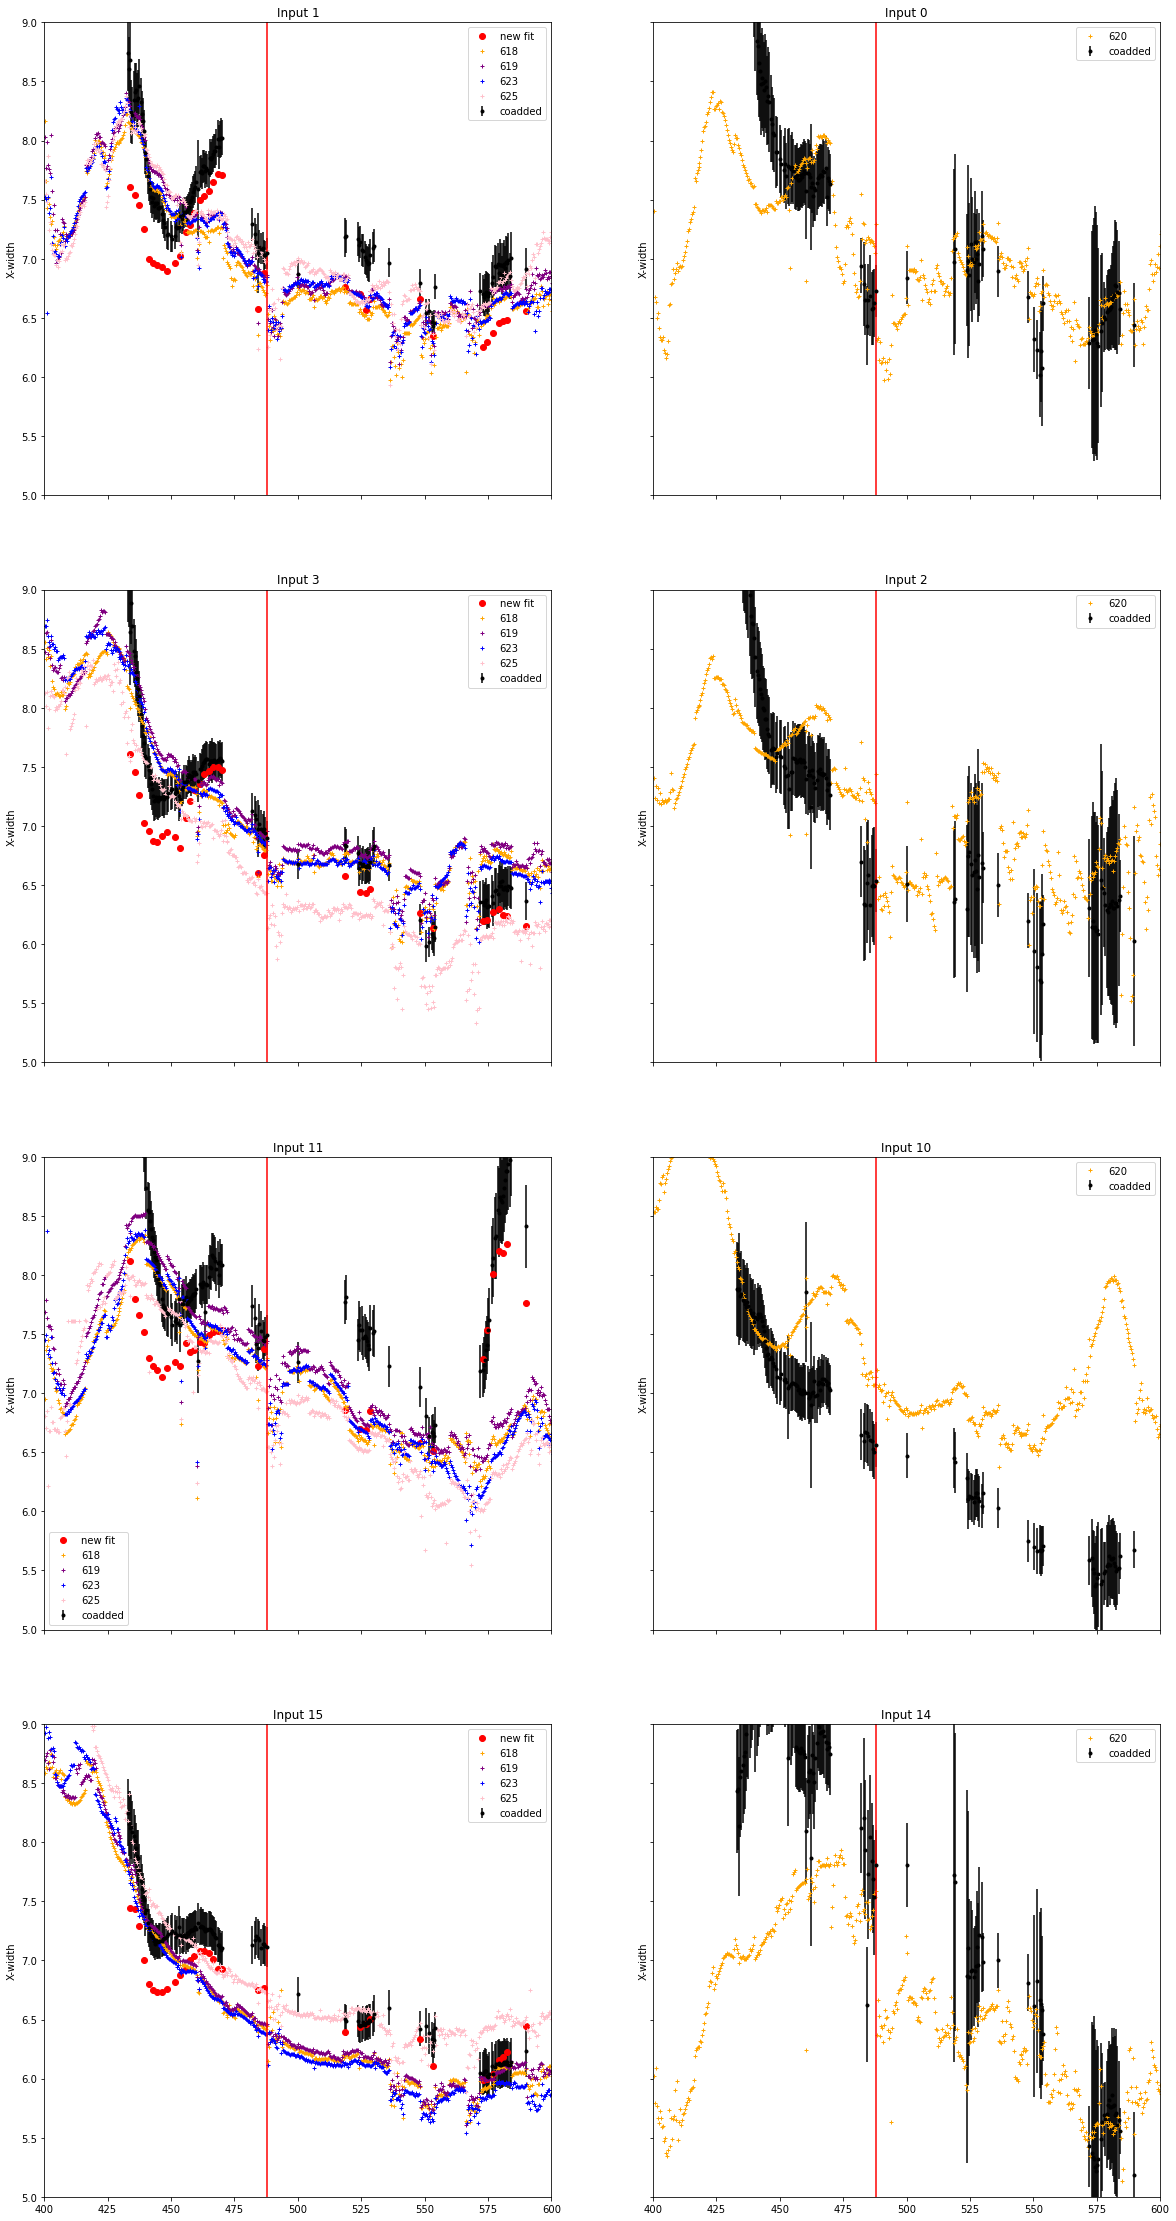

In [31]:
find = good_freqs[50]

colorz=pu.cm_to_discrete(ccm, 16)
colorf=['orange','purple','blue','pink']
fig,axs = plt.subplots(4,2, sharex=True,sharey=True,figsize=(20,40))

for i,chind in enumerate(N_pols):
    yc = m_to_FWHM(coadded['G_popt'][chind,good_freqs,2,0])
    yerrs = m_to_FWHM(coadded['G_popt'][chind,good_freqs,2,1])
    nf = m_to_FWHM(G_new_coadd[chind,:,2])
    axs[i,0].errorbar(freqs[good_freqs],yc,yerr=yerrs,marker='.',linestyle='None',color='black',label='coadded')
    axs[i,0].plot(freqs[good_freqs[::4]],nf[good_freqs[::4]],marker='o',linestyle='None',color='red',label='new fit')
    for f,fly in enumerate(['618','619','623','625']):
        ffile = glob.glob(fitdir+'*'+fly+'*')[0]
        fits = np.load(ffile)
        axs[i,0].plot(freqs,convert_sig_to_FWHM(convert_to_angle(fits['G_popt'][chind,:,2])),
                 markersize=4,marker='+',color=colorf[f],linestyle='None',label=fly)
    axs[i,0].legend()
    axs[i,0].set_title('Input '+str(chind))
    axs[i,0].set_ylabel('X-width')
    axs[i,0].set_ylim(5,9)
    axs[i,0].set_xlim(400,600)
    #plt.show()
    
for i,chind in enumerate(E_pols):
    yc = m_to_FWHM(coadded['G_popt'][chind,good_freqs,2,0])
    yerrs = m_to_FWHM(coadded['G_popt'][chind,good_freqs,2,1])
    axs[i,1].errorbar(freqs[good_freqs],yc,yerr=yerrs,marker='.',linestyle='None',color='black',label='coadded')
    for f,fly in enumerate(['620']):
        ffile = glob.glob(fitdir+'*'+fly+'*')[0]
        fits = np.load(ffile)
        axs[i,1].plot(freqs,convert_sig_to_FWHM(convert_to_angle(fits['G_popt'][chind,:,2])),
                 markersize=4,marker='+',color=colorf[f],linestyle='None',label=fly)
    axs[i,1].legend()
    axs[i,1].set_title('Input '+str(chind))
    axs[i,1].set_ylabel('X-width')
    axs[i,1].set_ylim(5,9)
    axs[i,1].set_xlim(400,600)
plt.show()


fig,axs = plt.subplots(4,2, sharex=True,sharey=True,figsize=(20,40))
for i,chind in enumerate(N_pols):
    yc = m_to_FWHM(coadded['G_popt'][chind,good_freqs,4,0])
    yerrs = m_to_FWHM(coadded['G_popt'][chind,good_freqs,4,1])
    nf = m_to_FWHM(G_new_coadd[chind,:,4])
    axs[i,0].errorbar(freqs[good_freqs],yc,yerr=yerrs,marker='.',linestyle='None',color='black',label='coadded')
    axs[i,0].plot(freqs[good_freqs[::4]],nf[good_freqs[::4]],marker='o',linestyle='None',color='red',label='new fit')
    for f,fly in enumerate(['618','619','623','625']):
        ffile = glob.glob(fitdir+'*'+fly+'*')[0]
        fits = np.load(ffile)
        axs[i,0].plot(freqs,convert_sig_to_FWHM(convert_to_angle(fits['G_popt'][chind,:,2])),
                 markersize=4,marker='+',color=colorf[f],linestyle='None',label=fly)
    axs[i,0].legend()
    axs[i,0].set_title('Input '+str(chind))
    axs[i,0].set_ylabel('X-width')
    axs[i,0].set_ylim(5,9)
    axs[i,0].set_xlim(400,600)
    #plt.show()
    
for i,chind in enumerate(E_pols):
    yc = m_to_FWHM(coadded['G_popt'][chind,good_freqs,4,0])
    yerrs = m_to_FWHM(coadded['G_popt'][chind,good_freqs,4,1])
    axs[i,1].errorbar(freqs[good_freqs],yc,yerr=yerrs,marker='.',linestyle='None',color='black',label='coadded')
    for f,fly in enumerate(['620']):
        ffile = glob.glob(fitdir+'*'+fly+'*')[0]
        fits = np.load(ffile)
        axs[i,1].plot(freqs,convert_sig_to_FWHM(convert_to_angle(fits['G_popt'][chind,:,2])),
                 markersize=4,marker='+',color=colorf[f],linestyle='None',label=fly)
    axs[i,1].axvline(freqs[find],color='red')
    axs[i,0].axvline(freqs[find],color='red')
    axs[i,1].legend()
    axs[i,1].set_title('Input '+str(chind))
    axs[i,1].set_ylabel('X-width')
    axs[i,1].set_ylim(5,9)
    axs[i,0].set_xlim(400,600)
plt.show()

# Compare with Pranav and Sims -- EW transit, should match X width

In [19]:
# pranav
fwhm_pra = np.load('/hirax/GBO_Analysis_Outputs/fwhm_pranav.npz') # fwhm, freq
print(fwhm_pra['fwhm'].shape)
print(fwhm_pra['freq'].shape)
print(fwhm_pra['freq'][846],freqs[900])


# sims
fwhm_freq = [400,450,500,550,600]
fwhm_sim_h_phi90 = [8.9,7.9,6.7,6.1,5.5]
fwhm_sim_h_phi0 = [7.7, 6.9, 6.3, 5.8, 5.3]

(2, 970)
(970,)
448.4375 448.4375


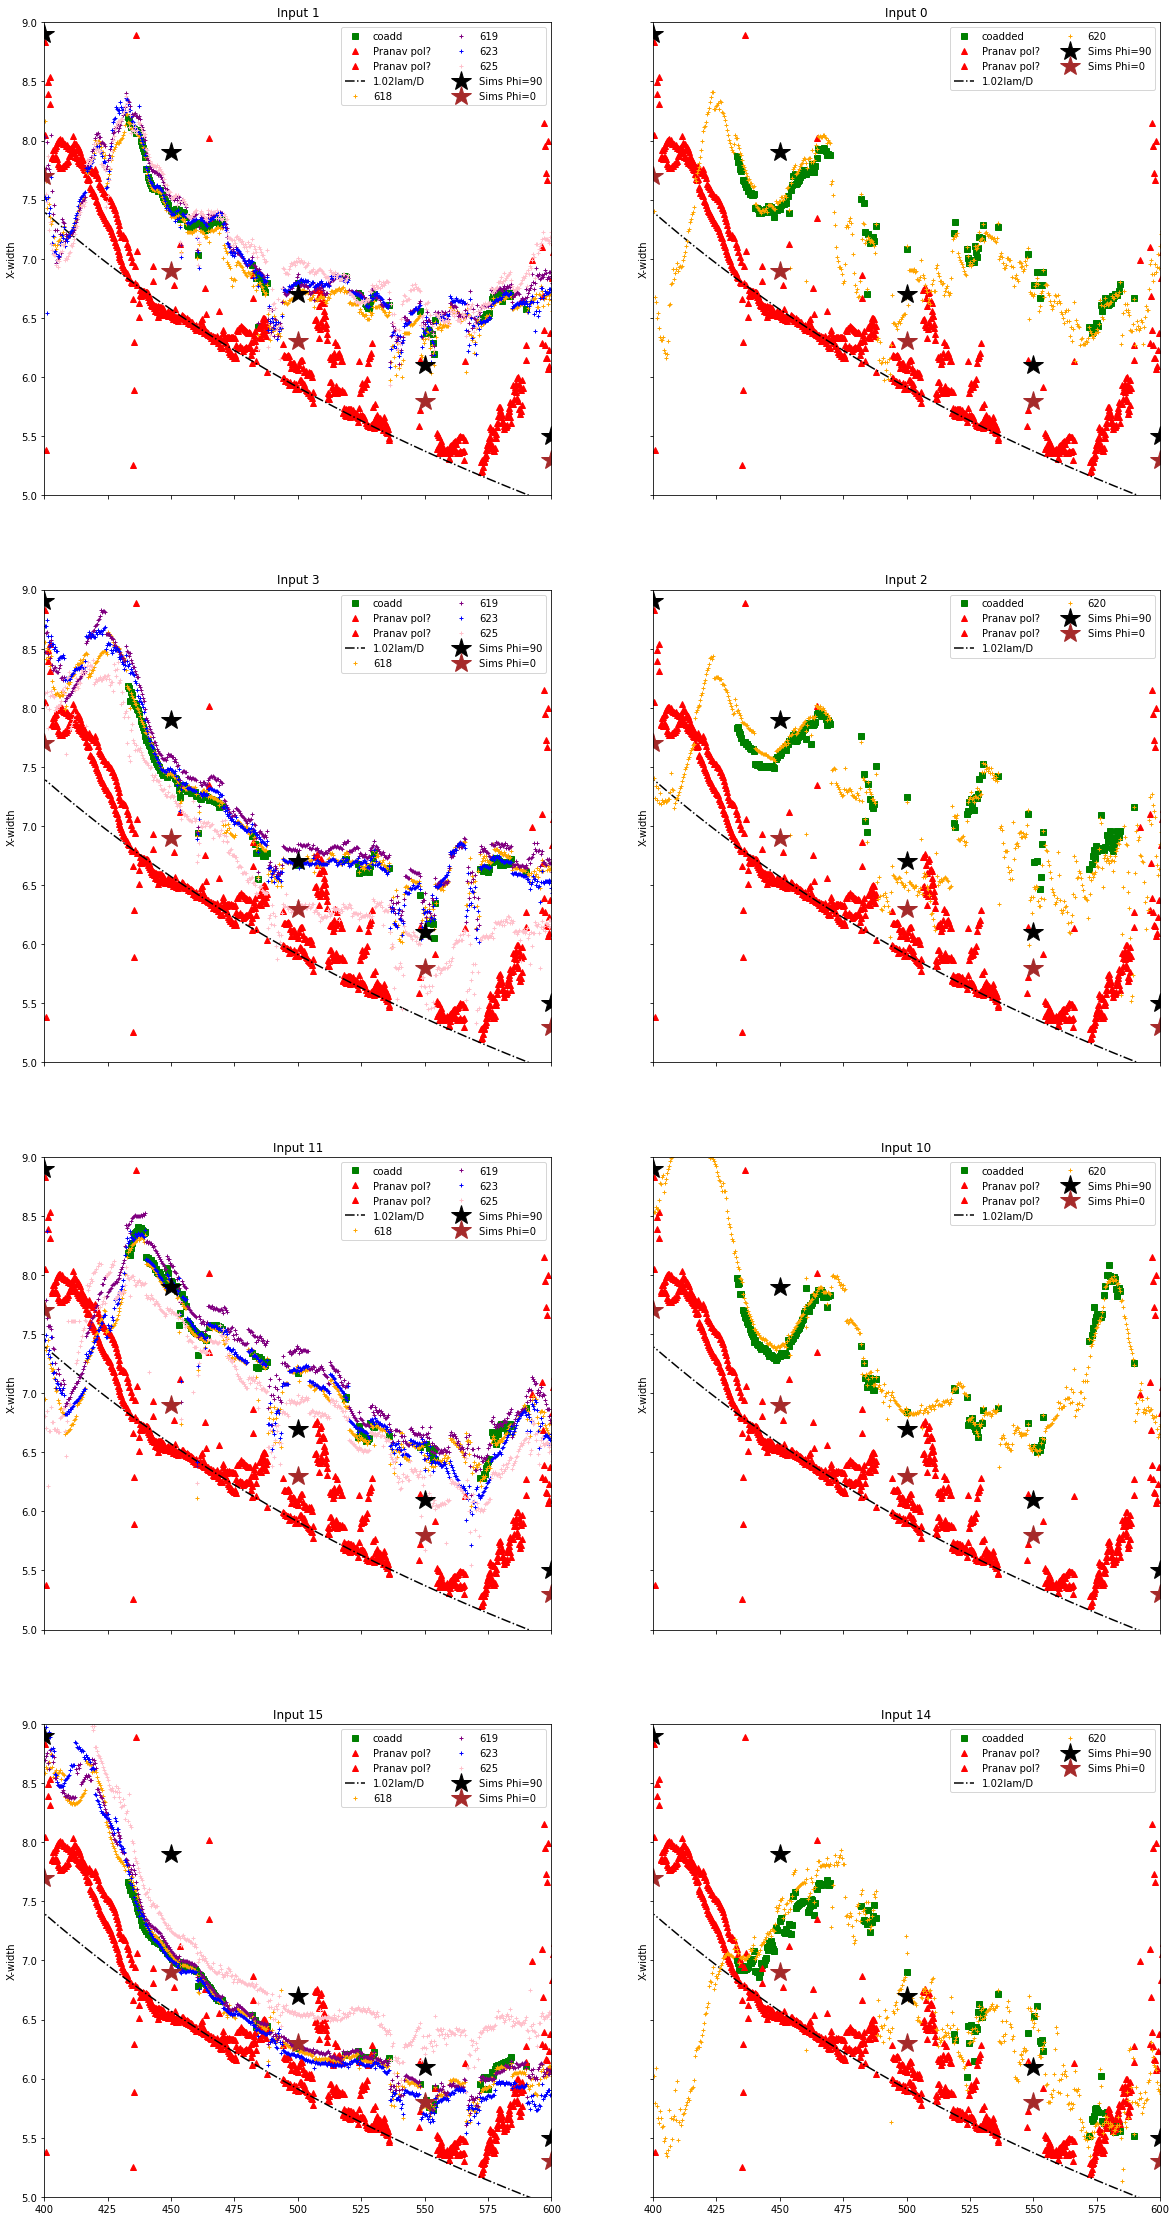

In [21]:
colorz=pu.cm_to_discrete(ccm, 16)
fig,axs = plt.subplots(4,2, sharex=True,sharey=True,figsize=(20,40))

for i,chind in enumerate(N_pols):
    yc = convert_sig_to_FWHM((convert_to_angle(coadded['G_popt'][chind,good_freqs,2,0])))
    axs[i,0].plot(freqs[good_freqs],yc,marker='s',linestyle='None',color='green',label='coadd')
    axs[i,0].plot(fwhm_pra['freq'],fwhm_pra['fwhm'][0,:],marker='^',linestyle='None',color='red',label='Pranav pol?')
    axs[i,0].plot(fwhm_pra['freq'],fwhm_pra['fwhm'][1,:],marker='^',linestyle='None',color='red',label='Pranav pol?')
    axs[i,0].plot(freqs,get_diffrac(freqs),linestyle='-.',color='black',label='1.02lam/D')
    for f,fly in enumerate(['618','619','623','625']):
        ffile = glob.glob(fitdir+'*'+fly+'*')[0]
        fits = np.load(ffile)
        axs[i,0].plot(freqs,convert_sig_to_FWHM(convert_to_angle(fits['G_popt'][chind,:,2])),
                 markersize=4,marker='+',color=colorf[f],linestyle='None',label=fly)
    axs[i,0].plot(fwhm_freq,fwhm_sim_h_phi90,marker='*',linestyle='None',color='black',ms=20,label='Sims Phi=90')
    axs[i,0].plot(fwhm_freq,fwhm_sim_h_phi0,marker='*',linestyle='None',color='brown',ms=20,label='Sims Phi=0')
    axs[i,0].legend(ncol=2)
    axs[i,0].set_title('Input '+str(chind))
    axs[i,0].set_ylabel('X-width')
    axs[i,0].set_ylim(5,9)
    axs[i,0].set_xlim(400,600)
    #plt.show()
    
for i,chind in enumerate(E_pols):
    yc = convert_sig_to_FWHM((convert_to_angle(coadded['G_popt'][chind,good_freqs,2,0])))
    axs[i,1].plot(freqs[good_freqs],yc,marker='s',linestyle='None',color='green',label='coadded')
    axs[i,1].plot(fwhm_pra['freq'],fwhm_pra['fwhm'][0,:],marker='^',linestyle='None',color='red',label='Pranav pol?')
    axs[i,1].plot(fwhm_pra['freq'],fwhm_pra['fwhm'][1,:],marker='^',linestyle='None',color='red',label='Pranav pol?')
    axs[i,1].plot(freqs,get_diffrac(freqs),linestyle='-.',color='black',label='1.02lam/D')
    for f,fly in enumerate(['620']):
        ffile = glob.glob(fitdir+'*'+fly+'*')[0]
        fits = np.load(ffile)
        axs[i,1].plot(freqs,convert_sig_to_FWHM(convert_to_angle(fits['G_popt'][chind,:,2])),
                 markersize=4,marker='+',color=colorf[f],linestyle='None',label=fly)
    axs[i,1].plot(fwhm_freq,fwhm_sim_h_phi90,marker='*',linestyle='None',color='black',ms=20,label='Sims Phi=90')
    axs[i,1].plot(fwhm_freq,fwhm_sim_h_phi0,marker='*',linestyle='None',color='brown',ms=20,label='Sims Phi=0')
    axs[i,1].legend(ncol=2)
    axs[i,1].set_title('Input '+str(chind))
    axs[i,1].set_ylabel('X-width')
    axs[i,1].set_ylim(5,9)
    axs[i,0].set_xlim(400,600)
plt.show()



In [ ]:
# THE FWHM DIFFERENCES BETWEEN COAD AND FLIGHTS ???

# In order of 'offness':
# Input 9 (N)
# Input 1 (N)
# Input 0 (E)
# Input 14 (E)


<ipython-input-47-fc755f462cb9>:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(2,5,1+i)
<ipython-input-47-fc755f462cb9>:18: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(ptest.d0_centers_grid[:,:,chind],ptest.d1_centers_grid[:,:,chind],
<ipython-input-47-fc755f462cb9>:18: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor re

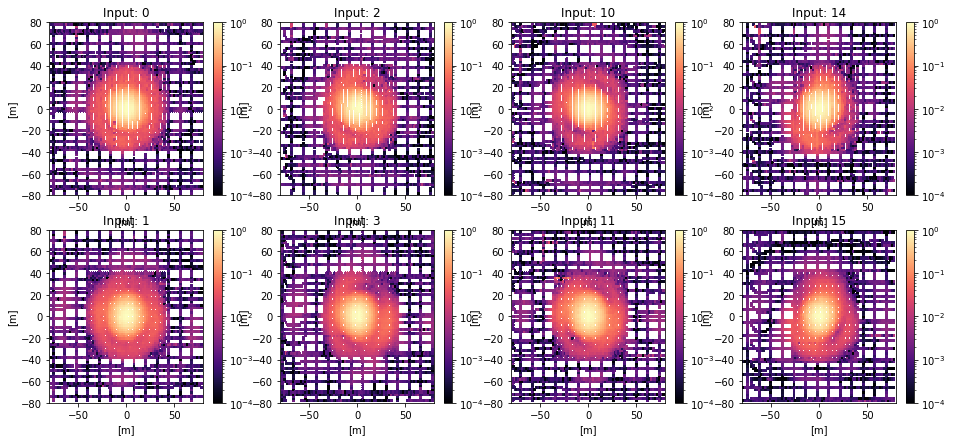

In [47]:
fig = plt.figure(figsize=(20,7))
plt.subplot(2,5,1)


copoldir = 'E'
pols = E_pols
f_intern = 0 # only one frequency per file, this is always 0

find = good_freqs[50]
picklefile = beamdir+'Beamcoadd_pol_'+copoldir+'_freq_'+str(find)+'.pkl'
with open(picklefile, 'rb') as inp:
    ptest = pickle.load(inp)
    
# Plot maps and variances

for i,chind in enumerate(pols):
    plt.subplot(2,5,1+i)
    plt.pcolormesh(ptest.d0_centers_grid[:,:,chind],ptest.d1_centers_grid[:,:,chind],
               np.abs(ptest.V_LC_operation[:,:,0,chind]),cmap=cm.magma,vmin=1E-4,vmax=1.0,norm=LogNorm())#,edgecolors='k')
    plt.xlim(-1*sz,sz)
    plt.ylim(-1*sz,sz)
    plt.xlabel('[m]')
    plt.ylabel('[m]')
    plt.title('Input: '+str(chind))
    plt.colorbar()
    
    
# set which pol:
copoldir = 'N'
pols = N_pols

picklefile = beamdir+'Beamcoadd_pol_'+copoldir+'_freq_'+str(find)+'.pkl'
with open(picklefile, 'rb') as inp:
    ptest = pickle.load(inp)
    
# Plot maps and variances

for i,chind in enumerate(pols):
    plt.subplot(2,5,5+i+1)
    plt.pcolormesh(ptest.d0_centers_grid[:,:,chind],ptest.d1_centers_grid[:,:,chind],
               np.abs(ptest.V_LC_operation[:,:,0,chind]),cmap=cm.magma,vmin=1E-4,vmax=1.0,norm=LogNorm())#,edgecolors='k')
    plt.xlim(-1*sz,sz)
    plt.ylim(-1*sz,sz)
    plt.xlabel('[m]')
    plt.ylabel('[m]')
    plt.title('Input: '+str(chind))
    plt.colorbar()
    

plt.show()

    
    



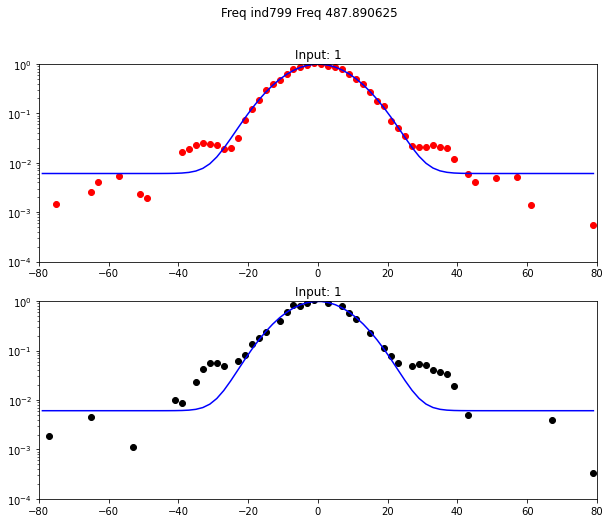

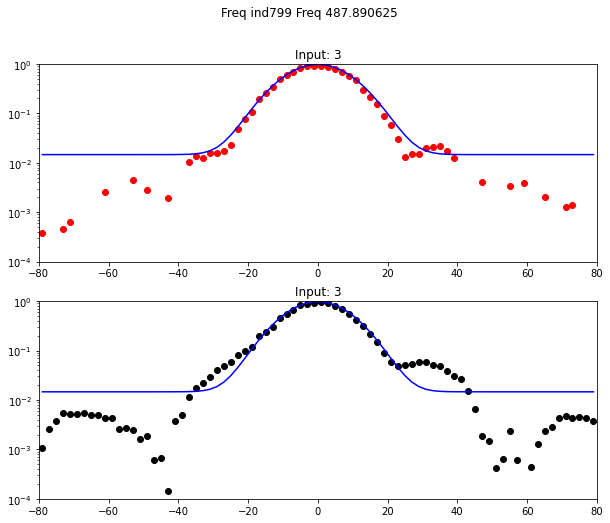

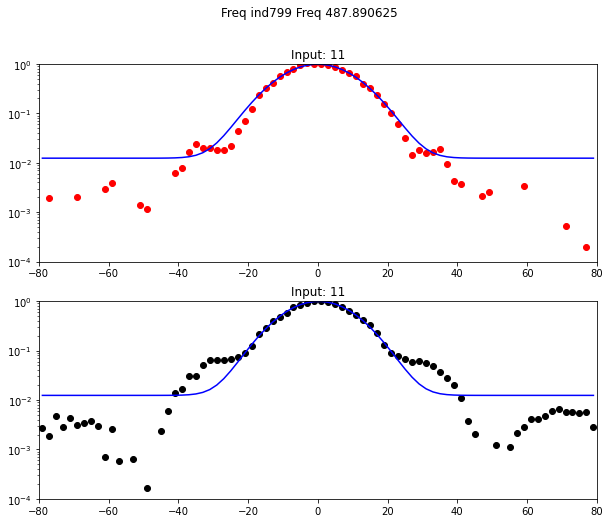

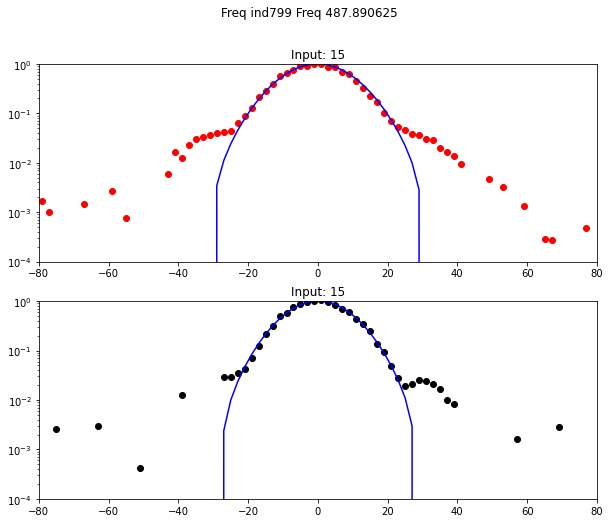

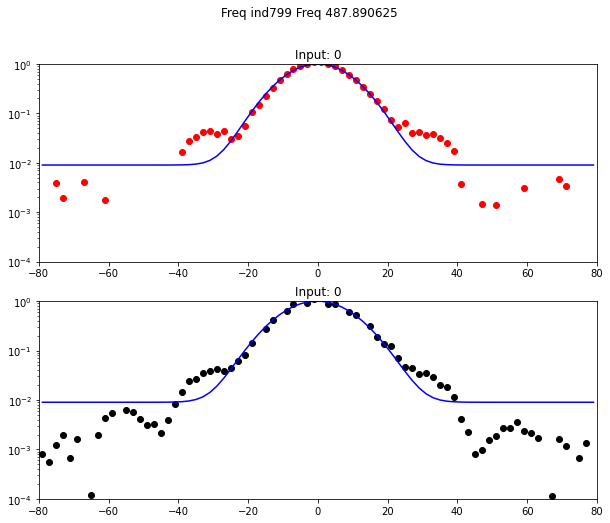

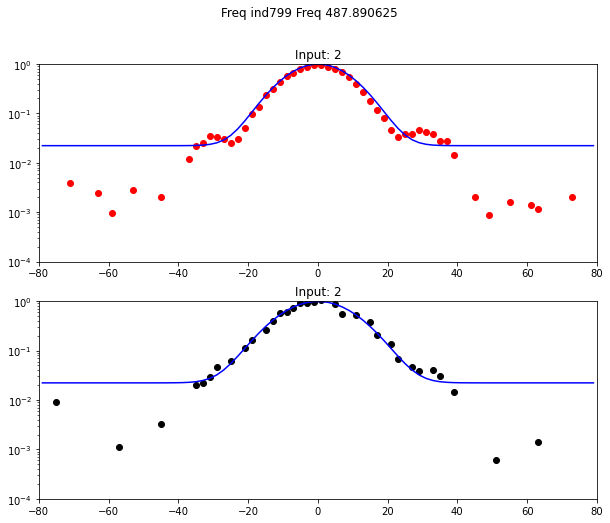

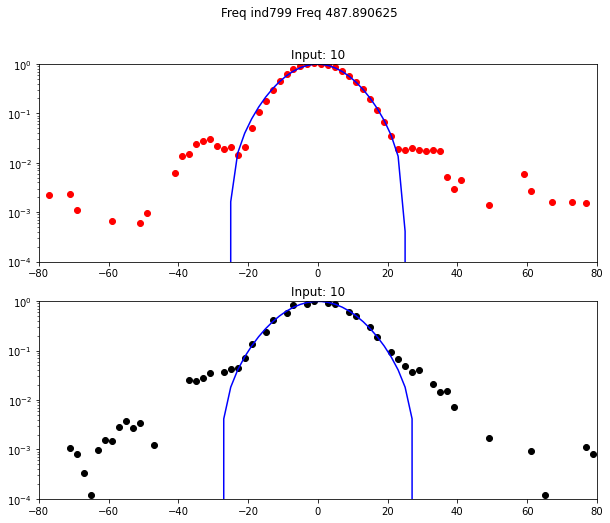

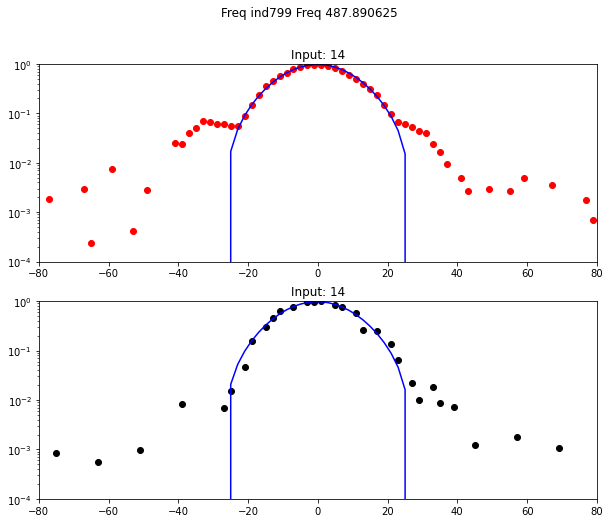

In [48]:
# plot slice through the co-added beams above

# set which pol:
copoldir = 'N'
pols = N_pols

picklefile = beamdir+'Beamcoadd_pol_'+copoldir+'_freq_'+str(find)+'.pkl'
with open(picklefile, 'rb') as inp:
    beam_coad = pickle.load(inp)
    
xx = 0
chind = pols[0]
colx = get_slice(beam_coad.d0_centers_grid[:,:,chind],beam_coad.d1_centers_grid[:,:,chind],
                 beam_coad.V_LC_operation[:,:,0,chind],xx,'v')
coly = get_slice(beam_coad.d0_centers_grid[:,:,chind],beam_coad.d1_centers_grid[:,:,chind],
                 beam_coad.V_LC_operation[:,:,0,chind],xx,'h')

# colx: use for constant x, let y vary: vertical slice 
# coly: use for constany y, let x vary: horizontal slice

for chind in pols:
    fig = plt.figure(figsize=(10,8))
    plt.subplot(2,1,1)
    plt.semilogy(beam_coad.d1_centers_grid[colx,:,chind],beam_coad.V_LC_operation[colx,:,0,chind],'o',
             label='Coadd x :'+str(beam_coad.d0_centers_grid[colx,0,0]),color='red')
    yfit = fu.Gauss_2d_LC_func(coadded['G_popt'][chind,find,:,0],
                               beam_coad.d0_centers_grid[colx,:,chind],beam_coad.d1_centers_grid[colx,:,chind])
    plt.semilogy(beam_coad.d0_centers_grid[:,coly,0],yfit,color='blue')
    plt.title('Input: '+str(chind))
    plt.ylim(0.0001,1)
    plt.xlim(-1*sz,sz)
    #plt.legend(loc='lower center')
    plt.subplot(2,1,2)
    plt.semilogy(beam_coad.d0_centers_grid[:,coly,0],beam_coad.V_LC_operation[:,coly,0,chind],'o',
             label='Coadd  y :'+str(beam_coad.d1_centers_grid[0,coly,0]),color='black')
    yfit = fu.Gauss_2d_LC_func(coadded['G_popt'][chind,find,:,0],
                               beam_coad.d0_centers_grid[:,coly,0],beam_coad.d1_centers_grid[:,coly,0])
    plt.semilogy(beam_coad.d0_centers_grid[:,coly,0],yfit,color='blue')
    plt.ylim(0.0001,1)
    plt.xlim(-1*sz,sz)
    plt.title('Input: '+str(chind))
    #plt.legend(loc='lower center')
    plt.suptitle('Freq ind'+str(find)+' Freq '+str(freqs[find]))
    plt.show()
    
    
    
# set which pol:
copoldir = 'E'
pols = E_pols

picklefile = beamdir+'Beamcoadd_pol_'+copoldir+'_freq_'+str(find)+'.pkl'
with open(picklefile, 'rb') as inp:
    beam_coad = pickle.load(inp)
    
xx = 0
chind = pols[0]
colx = get_slice(beam_coad.d0_centers_grid[:,:,chind],beam_coad.d1_centers_grid[:,:,chind],
                 beam_coad.V_LC_operation[:,:,0,chind],xx,'v')
coly = get_slice(beam_coad.d0_centers_grid[:,:,chind],beam_coad.d1_centers_grid[:,:,chind],
                 beam_coad.V_LC_operation[:,:,0,chind],xx,'h')



for chind in pols:
    fig = plt.figure(figsize=(10,8))
    plt.subplot(2,1,1)
    plt.semilogy(beam_coad.d1_centers_grid[colx,:,chind],beam_coad.V_LC_operation[colx,:,0,chind],'o',
             label='Coadd x :'+str(beam_coad.d0_centers_grid[colx,0,0]),color='red')
    yfit = fu.Gauss_2d_LC_func(coadded['G_popt'][chind,find,:,0],
                               beam_coad.d0_centers_grid[colx,:,chind],beam_coad.d1_centers_grid[colx,:,chind])
    plt.semilogy(beam_coad.d0_centers_grid[:,coly,0],yfit,color='blue')
    plt.title('Input: '+str(chind))
    plt.ylim(0.0001,1)
    plt.xlim(-1*sz,sz)
    #plt.legend(loc='lower center')
    plt.subplot(2,1,2)
    plt.semilogy(beam_coad.d0_centers_grid[:,coly,0],beam_coad.V_LC_operation[:,coly,0,chind],'o',
             label='Coadd  y :'+str(beam_coad.d1_centers_grid[0,coly,0]),color='black')
    yfit = fu.Gauss_2d_LC_func(coadded['G_popt'][chind,find,:,0],
                               beam_coad.d0_centers_grid[:,coly,0],beam_coad.d1_centers_grid[:,coly,0])
    plt.semilogy(beam_coad.d0_centers_grid[:,coly,0],yfit,color='blue')
    plt.ylim(0.0001,1)
    plt.xlim(-1*sz,sz)
    plt.title('Input: '+str(chind))
    #plt.legend(loc='lower center')
    plt.suptitle('Freq ind'+str(find)+' Freq '+str(freqs[find]))
    plt.show()

# POLAR - Read in a single co-added beam pickle and plot maps, slices

In [ ]:
# Plot slice of beams - two rows, first row is N pol, second row is E pol 
def cm_to_discrete(cmap, number):
    # this takes in a colormap and a number of colors you want from it, and returns
    # hex codes associated with a discrete colormap, as a vector    
    hex_codes=[]
    
    for i in range(number):
        n = int(i * cmap.N / number)
        rgba = cmap(n)
        # rgb2hex accepts rgb or rgba
        hex_code=matplotlib.colors.rgb2hex(rgba)
        hex_codes.append(hex_code)
    
    return hex_codes

colorz = cm_to_discrete(cm.magma, 5)

# set which frequency
find = good_freqs[-1]

# set which pol:
copoldir = 'N'
pols = N_pols
chind = pols[0]


picklefile = polbeamdir+'Beamcoadd_pol_'+copoldir+'_freq_'+str(find)+'_polar.pkl'
with open(picklefile, 'rb') as inp:
    ptest = pickle.load(inp)

chind = pols[0]
col1,col2 = get_polar_slice(ptest.d0_centers_grid[:,:,chind],
                          ptest.d1_centers_grid[:,:,chind],0.0)

col1_90,col2_90 = get_polar_slice(ptest.d0_centers_grid[:,:,chind],
                          ptest.d1_centers_grid[:,:,chind],np.pi/2.)


fig,axs = plt.subplots(2, 2, sharex=True,sharey=True,figsize=(10,8))
for i,chind in enumerate(N_pols):  
    axs[0,0].errorbar(np.degrees(ptest.d1_centers_grid[col1,:,chind]),
                    ptest.V_LC_operation[col1,:,0,chind],
                    yerr=ptest.V_LC_operation_err[col1,:,0,chind],marker='o',
             color=colorz[i],label='Input :'+str(chind))
    axs[0,0].errorbar(-1.0*np.degrees(ptest.d1_centers_grid[col2,:,chind]),
                    ptest.V_LC_operation[col2,:,0,chind],
                    yerr=ptest.V_LC_operation_err[col1,:,0,chind],marker='o',
             color=colorz[i])
    axs[0,1].errorbar(np.degrees(ptest.d1_centers_grid[col1_90,:,chind]),
                    ptest.V_LC_operation[col1_90,:,0,chind],
                    yerr=ptest.V_LC_operation_err[col1_90,:,0,chind],marker='o',
             color=colorz[i],label='Input :'+str(chind))
    axs[0,1].errorbar(-1.0*np.degrees(ptest.d1_centers_grid[col2_90,:,chind]),
                    ptest.V_LC_operation[col2_90,:,0,chind],
                    yerr=ptest.V_LC_operation_err[col1_90,:,0,chind],marker='o',
             color=colorz[i])
    

copoldir = 'E'
pols = E_pols
chind = pols[0]
picklefile = polbeamdir+'Beamcoadd_pol_'+copoldir+'_freq_'+str(find)+'_polar.pkl'
with open(picklefile, 'rb') as inp:
    ptest = pickle.load(inp)
    
for i,chind in enumerate(E_pols):
    axs[1,0].errorbar(np.degrees(ptest.d1_centers_grid[col1,:,chind]),
                    ptest.V_LC_operation[col1,:,0,chind],
                    yerr=ptest.V_LC_operation_err[col1,:,0,chind], marker='o',
                    color=colorz[i],label='Input :'+str(chind))
    axs[1,0].errorbar(-1.0*np.degrees(ptest.d1_centers_grid[col2,:,chind]),
                    ptest.V_LC_operation[col2,:,0,chind],
                    yerr=ptest.V_LC_operation_err[col1,:,0,chind],marker='o',
                     color=colorz[i])
    axs[1,1].errorbar(np.degrees(ptest.d1_centers_grid[col1_90,:,chind]),
                    ptest.V_LC_operation[col1_90,:,0,chind],
                    yerr=ptest.V_LC_operation_err[col1_90,:,0,chind],marker='o',
                    color=colorz[i],label='Input :'+str(chind))
    axs[1,1].errorbar(-1.0*np.degrees(ptest.d1_centers_grid[col2_90,:,chind]),
                    ptest.V_LC_operation[col2_90,:,0,chind],
                    yerr=ptest.V_LC_operation_err[col1_90,:,0,chind],marker='o',
                     color=colorz[i])
    
axs[1,0].set_xlabel('Angle [degrees]')
axs[1,1].set_xlabel('Angle [degrees]')
axs[0,0].set_ylabel('Amplitude')
axs[1,0].set_ylabel('Amplitude')
axs[0,0].legend(loc='lower center')
axs[1,0].legend(loc='lower center')
axs[0,1].legend(loc='lower center')
axs[1,1].legend(loc='lower center')
axs[0,0].text(-25,0.5,'theta=0',fontsize=14)
axs[0,1].text(-25,0.5,'theta=0',fontsize=14)
axs[1,0].text(-25,0.5,'theta=90',fontsize=14)
axs[1,1].text(-25,0.5,'theta=90',fontsize=14)
axs[0,0].set_xlim(-30,30)
axs[0,0].set_ylim(1E-4,1)
plt.show()



# set which pol:
copoldir = 'N'
pols = N_pols
chind = pols[0]

picklefile = polbeamdir+'Beamcoadd_pol_'+copoldir+'_freq_'+str(find)+'_polar.pkl'
with open(picklefile, 'rb') as inp:
    ptest = pickle.load(inp)

chind = pols[0]
col1,col2 = get_polar_slice(ptest.d0_centers_grid[:,:,chind],
                          ptest.d1_centers_grid[:,:,chind],0.0)

col1_90,col2_90 = get_polar_slice(ptest.d0_centers_grid[:,:,chind],
                          ptest.d1_centers_grid[:,:,chind],np.pi/2.)


fig,axs = plt.subplots(2, 2, sharex=True,sharey=True,figsize=(10,8))
for i,chind in enumerate(N_pols):  
    axs[0,0].errorbar(np.degrees(ptest.d1_centers_grid[col1,:,chind]),
                    ptest.V_LC_operation[col1,:,0,chind],
                    yerr=ptest.V_LC_operation_err[col1,:,0,chind],marker='o',
             color=colorz[i],label='Input :'+str(chind))
    axs[0,0].errorbar(-1.0*np.degrees(ptest.d1_centers_grid[col2,:,chind]),
                    ptest.V_LC_operation[col2,:,0,chind],
                    yerr=ptest.V_LC_operation_err[col1,:,0,chind],marker='o',
             color=colorz[i])
    axs[0,1].errorbar(np.degrees(ptest.d1_centers_grid[col1_90,:,chind]),
                    ptest.V_LC_operation[col1_90,:,0,chind],
                    yerr=ptest.V_LC_operation_err[col1_90,:,0,chind],marker='o',
             color=colorz[i],label='Input :'+str(chind))
    axs[0,1].errorbar(-1.0*np.degrees(ptest.d1_centers_grid[col2_90,:,chind]),
                    ptest.V_LC_operation[col2_90,:,0,chind],
                    yerr=ptest.V_LC_operation_err[col1_90,:,0,chind],marker='o',
             color=colorz[i])
    

copoldir = 'E'
pols = E_pols
chind = pols[0]
picklefile = polbeamdir+'Beamcoadd_pol_'+copoldir+'_freq_'+str(find)+'_polar.pkl'
with open(picklefile, 'rb') as inp:
    ptest = pickle.load(inp)
    
for i,chind in enumerate(E_pols):
    axs[1,0].errorbar(np.degrees(ptest.d1_centers_grid[col1,:,chind]),
                    ptest.V_LC_operation[col1,:,0,chind],
                    yerr=ptest.V_LC_operation_err[col1,:,0,chind], marker='o',
                    color=colorz[i],label='Input :'+str(chind))
    axs[1,0].errorbar(-1.0*np.degrees(ptest.d1_centers_grid[col2,:,chind]),
                    ptest.V_LC_operation[col2,:,0,chind],
                    yerr=ptest.V_LC_operation_err[col1,:,0,chind],marker='o',
                     color=colorz[i])
    axs[1,1].errorbar(np.degrees(ptest.d1_centers_grid[col1_90,:,chind]),
                    ptest.V_LC_operation[col1_90,:,0,chind],
                    yerr=ptest.V_LC_operation_err[col1_90,:,0,chind],marker='o',
                    color=colorz[i],label='Input :'+str(chind))
    axs[1,1].errorbar(-1.0*np.degrees(ptest.d1_centers_grid[col2_90,:,chind]),
                    ptest.V_LC_operation[col2_90,:,0,chind],
                    yerr=ptest.V_LC_operation_err[col1_90,:,0,chind],marker='o',
                     color=colorz[i])
    
axs[1,0].set_xlabel('Angle [degrees]')
axs[1,1].set_xlabel('Angle [degrees]')
axs[0,0].set_ylabel('Amplitude')
axs[1,0].set_ylabel('Amplitude')
axs[0,0].legend(loc='lower center')
axs[1,0].legend(loc='lower center')
axs[0,1].legend(loc='lower center')
axs[1,1].legend(loc='lower center')
axs[0,0].text(-25,0.5,'theta=0',fontsize=14)
axs[0,1].text(-25,0.5,'theta=0',fontsize=14)
axs[1,0].text(-25,0.5,'theta=90',fontsize=14)
axs[1,1].text(-25,0.5,'theta=90',fontsize=14)
axs[0,0].set_yscale('log')
axs[0,0].set_xlim(-30,30)
axs[0,0].set_ylim(1E-4,1)
plt.show()

In [ ]:
# plot slice through the co-added beams above

# set which pol:
copoldir = 'N'
pols = N_pols
f_intern = 0 # only one frequency per file, this is always 0

find = 900
picklefile = beamdir+'Beamcoadd_pol_'+copoldir+'_freq_'+str(find)+'.pkl'
with open(picklefile, 'rb') as inp:
    beam_coad = pickle.load(inp)
    

ppicklefile = polbeamdir+'Beamcoadd_pol_'+copoldir+'_freq_'+str(find)+'_polar.pkl'
with open(ppicklefile, 'rb') as inp:
    pptest = pickle.load(inp)

bpicklefile = polbeamdir+'Beamcoadd_pol_'+copoldir+'_freq_'+str(find)+'_polar_bgonly.pkl'
with open(ppicklefile, 'rb') as inp:
    bptest = pickle.load(inp)
    
col1,col2 = get_polar_slice(pptest.d0_centers_grid[:,:,chind],
                          pptest.d1_centers_grid[:,:,chind],0.0)


for chind in pols:
    fig = plt.figure(figsize=(15,8))    

    #plt.semilogy(pptest.d1_centers_grid[col1,:,chind],pptest.V_LC_operation[col1,:,0,chind],'o',
    #         color='black',label='Coadd theta :'+str(np.degrees(pptest.d0_centers_grid[col1,0,chind]))+' [deg]')
    #plt.semilogy(-1.0*pptest.d1_centers_grid[col2,:,chind],pptest.V_LC_operation[col2,:,0,chind],'o',
    #         color='black',label='Coadd theta :'+str(np.degrees(pptest.d0_centers_grid[col2,0,chind]))+' [deg]')
    plt.semilogy(bptest.d1_centers_grid[col1,:,chind],bptest.V_LC_operation[col1,:,0,chind],'o',
             color='red',label='Coadd theta :'+str(np.degrees(bptest.d0_centers_grid[col1,0,chind]))+' [deg]')
    plt.semilogy(-1.0*bptest.d1_centers_grid[col2,:,chind],bptest.V_LC_operation[col2,:,0,chind],'o',
             color='red',label='Coadd theta :'+str(np.degrees(bptest.d0_centers_grid[col2,0,chind]))+' [deg]')
    #plt.ylim(0.0001,1)
    #plt.xlim(-1*sz,sz)
    plt.legend(loc='lower center')
    plt.title('Input: '+str(chind)+ ' Freq ind'+str(find)+' Freq '+str(freqs[find]))
    plt.show()
    

    

In [ ]:
# plot slice through the co-added beams above

# set which pol:
copoldir = 'N'
pols = N_pols
f_intern = 0 # only one frequency per file, this is always 0

find = 900
picklefile = beamdir+'Beamcoadd_pol_'+copoldir+'_freq_'+str(find)+'.pkl'
with open(picklefile, 'rb') as inp:
    beam_coad = pickle.load(inp)
    
xx = 0
chind = pols[0]
colx = get_slice(beam_coad.x_centers_grid[:,:,chind],beam_coad.y_centers_grid[:,:,chind],
                 beam_coad.V_LC_operation[:,:,0,chind],xx,'v')
coly = get_slice(beam_coad.x_centers_grid[:,:,chind],beam_coad.y_centers_grid[:,:,chind],
                 beam_coad.V_LC_operation[:,:,0,chind],xx,'h')



ppicklefile = polbeamdir+'Beamcoadd_pol_'+copoldir+'_freq_'+str(find)+'_polar.pkl'
with open(ppicklefile, 'rb') as inp:
    pptest = pickle.load(inp)


col1,col2 = get_polar_slice(pptest.d0_centers_grid[:,:,chind],
                          pptest.d1_centers_grid[:,:,chind],0.0)


for chind in pols:
    fig = plt.figure(figsize=(15,8))
    
    plt.semilogy(convert_to_angle(beam_coad.x_centers_grid[:,coly,0]),beam_coad.V_LC_operation[:,coly,0,chind],'o',
             label='Coadd  y :'+str(beam_coad.y_centers_grid[0,coly,0]),color='black')
    plt.ylim(0.0001,1)
    plt.xlabel('meter [m]')
    plt.title('Input: '+str(chind))
    #plt.legend(loc='lower center')
    plt.suptitle('Freq ind'+str(find)+' Freq '+str(freqs[find]))

    plt.semilogy(np.degrees(pptest.d1_centers_grid[col1,:,chind]),pptest.V_LC_operation[col1,:,0,chind],'o',
             color='red',label='Coadd theta :'+str(np.degrees(pptest.d0_centers_grid[col1,0,chind]))+' [deg]')
    plt.semilogy(-1.0*np.degrees(pptest.d1_centers_grid[col2,:,chind]),pptest.V_LC_operation[col2,:,0,chind],'o',
             color='red',label='Coadd theta :'+str(np.degrees(pptest.d0_centers_grid[col2,0,chind]))+' [deg]')
    plt.ylim(0.0001,1)
    plt.xlim(-1*45,45)
    plt.legend(loc='lower center')
    plt.title('Input: '+str(chind)+ ' Freq ind'+str(find)+' Freq '+str(freqs[find]))
    plt.show()
    

    

In [ ]:
print(good_freqs)

# set which pol:
copoldir = 'N'
pols = N_pols
f_intern = 0 # only one frequency per file, this is always 0

find = 900
picklefile = polbeamdir+'Beamcoadd_pol_'+copoldir+'_freq_'+str(find)+'_polar.pkl'
with open(picklefile, 'rb') as inp:
    ptest = pickle.load(inp)
    
# Plot maps and variances

for i,chind in enumerate(pols):
    fig = plt.figure(figsize=(10,10))
    ax = plt.subplot(1, 1, 1, projection='polar')
    #plt.scatter(ptest.d0_centers_grid[:,:,chind],ptest.d1_centers_grid[:,:,chind],
    #           c=10*np.log10(np.abs(ptest.V_LC_operation[:,:,0,chind])),vmax=1.0,vmin=-40,cmap=cm.magma)#,edgecolors='k')
    plt.pcolormesh(ptest.d0_edges_grid[:,:,chind],ptest.d1_edges_grid[:,:,chind],
                   ptest.V_LC_operation[:,:,0,chind],cmap=cm.magma,norm=LogNorm())
    plt.title('Input: '+str(chind))
    plt.colorbar()
    plt.show()

for i,chind in enumerate(pols):
    fig = plt.figure(figsize=(10,10))
    ax = plt.subplot(1, 1, 1, projection='polar')
    plt.pcolormesh(ptest.d0_edges_grid[:,:,chind],ptest.d1_edges_grid[:,:,chind],
                   ptest.V_LC_operation_err[:,:,0,chind],cmap=cm.magma)
    plt.title('Input: '+str(chind))
    plt.colorbar()
    plt.show()

In [ ]:
# set which pol:
copoldir = 'N'
pols = N_pols
f_intern = 0 # only one frequency per file, this is always 0
chind = pols[1]

fig = plt.figure(figsize=(10,8))
for find in good_freqs:
    picklefile = polbeamdir+'Beamcoadd_pol_'+copoldir+'_freq_'+str(find)+'_polar.pkl'
    with open(picklefile, 'rb') as inp:
        ptest = pickle.load(inp)
    f = freqs[find]
    plt.scatter(np.degrees(ptest.d1_centers_grid[col1,:,chind]),f*np.ones(len(ptest.d1_centers_grid[col1,:,chind])),
                c=10*np.log10(abs(ptest.V_LC_operation[col1,:,0,chind])),vmin=-40,vmax=0)
    plt.scatter(np.degrees(-1.0*ptest.d1_centers_grid[col2,:,chind]),f*np.ones(len(ptest.d1_centers_grid[col1,:,chind])),
                c=10*np.log10(abs(ptest.V_LC_operation[col2,:,0,chind])),vmin=-40,vmax=0)
plt.ylabel('Frequency [MHz]')
plt.xlabel('Phi @ theta=45.0 [degrees]')
plt.colorbar()
plt.show()


In [ ]:
# set which pol:
copoldir = 'E'
pols = E_pols
f_intern = 0 # only one frequency per file, this is always 0

find = 900
picklefile = polbeamdir+'Beamcoadd_pol_'+copoldir+'_freq_'+str(find)+'_polar.pkl'
with open(picklefile, 'rb') as inp:
    ptest = pickle.load(inp)
    
# Plot maps and variances

for i,chind in enumerate(pols):
    fig = plt.figure(figsize=(10,10))
    ax = plt.subplot(1, 1, 1, projection='polar')
    #plt.scatter(ptest.d0_centers_grid[:,:,chind],ptest.d1_centers_grid[:,:,chind],
    #           c=10*np.log10(np.abs(ptest.V_LC_operation[:,:,0,chind])),vmax=1.0,vmin=-40,cmap=cm.magma)#,edgecolors='k')
    plt.pcolormesh(ptest.d0_edges_grid[:,:,chind],ptest.d1_edges_grid[:,:,chind],
                   ptest.V_LC_operation[:,:,0,chind],cmap=cm.magma,norm=LogNorm())
    plt.title('Input: '+str(chind))
    plt.colorbar()
    plt.show()

for i,chind in enumerate(pols):
    fig = plt.figure(figsize=(10,10))
    ax = plt.subplot(1, 1, 1, projection='polar')
    plt.pcolormesh(ptest.d0_edges_grid[:,:,chind],ptest.d1_edges_grid[:,:,chind],
                   ptest.V_LC_operation_err[:,:,0,chind],cmap=cm.magma)
    plt.title('Input: '+str(chind))
    plt.colorbar()
    plt.show()

In [ ]:
def get_polar_slice(theta,phi,amps,sliceval, slicedir='v'):   
    # this gradually increases the tolerance until it finds something
    tol = abs(phi[0,1] - phi[0,0])/1.5
    N = len(beam.x_centers_grid[:,0,0]) #figure out the importance of this 
    ok = True
    while(ok):
        if sliceOrientation=='h': #keeping the y value constant and changing the x value 
            sliceIndex = np.where((beam.y_centers_grid[0,:,0] < (val + tol)) & (beam.y_centers_grid[0,:,0] > (val-tol)))[0]
            n = np.count_nonzero(np.isfinite(Z)) #count number of 'good' data
            if n > 10: ok = False
            else: ok = True
                #still need to do this one 
        if sliceOrientation=='v':#keeping the x value constant and changing the y value 
            sliceIndex = np.where((beam.x_centers_grid[:,0,0] < (val+tol)) & (beam.x_centers_grid[:,0,0] > (val-tol)))[0]
            n = np.count_nonzero(np.isfinite(Z)) #count number of 'good' data
            if n > 10: ok = False
            else: ok = True
        tol+=1
        if tol > 30: ok = False
    return sliceIndex[0]

# plot slice through the co-added beams above

# set which pol:
copoldir = 'N'
pols = N_pols
f_intern = 0 # only one frequency per file, this is always 0

find = 900
picklefile = beamdir+'Beamcoadd_pol_'+copoldir+'_freq_'+str(find)+'.pkl'
with open(picklefile, 'rb') as inp:
    beam_coad = pickle.load(inp)
    
xx = 0
chind = pols[0]
colx = get_slice(beam_coad,beam_coad.V_LC_operation[:,:,0,chind],xx,'v')
coly = get_slice(beam_coad,beam_coad.V_LC_operation[:,:,0,chind],xx,'h')

fig = plt.figure(figsize=(10,8))

plt.subplot(2,1,1)
plt.semilogy(beam_coad.y_centers_grid[colx,:,chind],beam_coad.V_LC_operation[colx,:,0,chind],'o',
             label='Coadd x :'+str(beam_coad.x_centers_grid[colx,0,0]),color='black')
plt.title('Input: '+str(chind))
plt.ylim(0.0001,1)
plt.xlim(-1*sz,sz)
#plt.legend(loc='lower center')
plt.subplot(2,1,2)
plt.semilogy(beam_coad.x_centers_grid[:,coly,0],beam_coad.V_LC_operation[:,coly,0,chind],'o',
             label='Coadd  y :'+str(beam_coad.y_centers_grid[0,coly,0]),color='black')
plt.ylim(0.0001,1)
plt.xlim(-1*sz,sz)
plt.title('Input: '+str(chind))
#plt.legend(loc='lower center')
plt.suptitle('Freq ind'+str(find)+' Freq '+str(freqs[find]))



# CARTESIAN - Read in a single co-added beam pickle and plot maps, slices

448.4375


<ipython-input-23-ff830953e1ac>:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(2,5,1+i)
<ipython-input-23-ff830953e1ac>:19: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(ptest.d0_centers_grid[:,:,chind],ptest.d1_centers_grid[:,:,chind],
<ipython-input-23-ff830953e1ac>:19: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor re

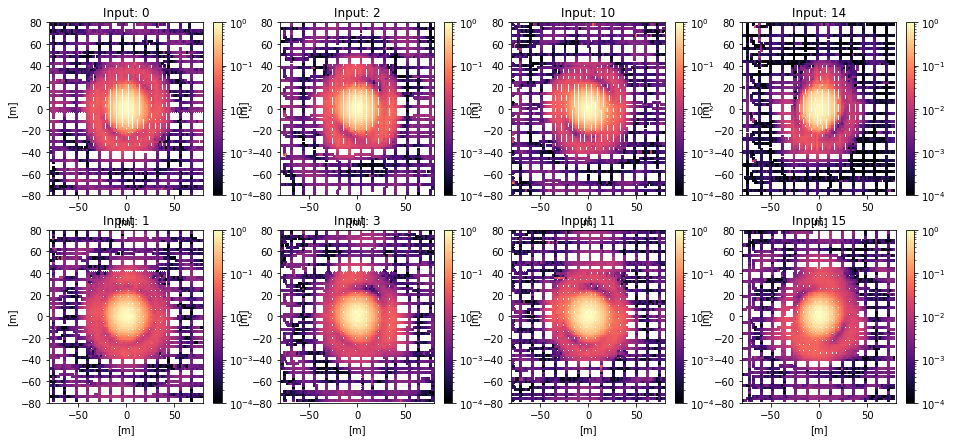

In [23]:
fig = plt.figure(figsize=(20,7))
plt.subplot(2,5,1)


copoldir = 'E'
pols = E_pols
f_intern = 0 # only one frequency per file, this is always 0

find = 900
print(freqs[900])
picklefile = beamdir+'Beamcoadd_pol_'+copoldir+'_freq_'+str(find)+'.pkl'
with open(picklefile, 'rb') as inp:
    ptest = pickle.load(inp)
    
# Plot maps and variances

for i,chind in enumerate(pols):
    plt.subplot(2,5,1+i)
    plt.pcolormesh(ptest.d0_centers_grid[:,:,chind],ptest.d1_centers_grid[:,:,chind],
               np.abs(ptest.V_LC_operation[:,:,0,chind]),cmap=cm.magma,vmin=1E-4,vmax=1.0,norm=LogNorm())#,edgecolors='k')
    plt.xlim(-1*sz,sz)
    plt.ylim(-1*sz,sz)
    plt.xlabel('[m]')
    plt.ylabel('[m]')
    plt.title('Input: '+str(chind))
    plt.colorbar()
    
    
# set which pol:
copoldir = 'N'
pols = N_pols

picklefile = beamdir+'Beamcoadd_pol_'+copoldir+'_freq_'+str(find)+'.pkl'
with open(picklefile, 'rb') as inp:
    ptest = pickle.load(inp)
    
# Plot maps and variances

for i,chind in enumerate(pols):
    plt.subplot(2,5,5+i+1)
    plt.pcolormesh(ptest.d0_centers_grid[:,:,chind],ptest.d1_centers_grid[:,:,chind],
               np.abs(ptest.V_LC_operation[:,:,0,chind]),cmap=cm.magma,vmin=1E-4,vmax=1.0,norm=LogNorm())#,edgecolors='k')
    plt.xlim(-1*sz,sz)
    plt.ylim(-1*sz,sz)
    plt.xlabel('[m]')
    plt.ylabel('[m]')
    plt.title('Input: '+str(chind))
    plt.colorbar()
    

plt.show()

    
    



In [ ]:
print(good_freqs)

# set which pol:
copoldir = 'N'
pols = N_pols
f_intern = 0 # only one frequency per file, this is always 0

find = 900
picklefile = beamdir+'Beamcoadd_pol_'+copoldir+'_freq_'+str(find)+'.pkl'
with open(picklefile, 'rb') as inp:
    ptest = pickle.load(inp)
    
# Plot maps and variances

for i,chind in enumerate(pols):
    fig = plt.figure(figsize=(10,10))
    plt.pcolormesh(ptest.x_centers_grid[:,:,chind],ptest.y_centers_grid[:,:,chind],
               np.abs(ptest.V_LC_operation[:,:,0,chind]),cmap=cm.magma,norm=LogNorm())#,edgecolors='k')
    plt.xlim(-1*sz,sz)
    plt.ylim(-1*sz,sz)
    plt.xlabel('[m]')
    plt.ylabel('[m]')
    plt.title('Input: '+str(chind))
    plt.colorbar()
    plt.show()

for i,chind in enumerate(pols):
    fig = plt.figure(figsize=(10,10))
    plt.pcolormesh(ptest.x_centers_grid[:,:,chind],ptest.y_centers_grid[:,:,chind],
               ptest.V_LC_operation_err[:,:,0,chind],cmap=cm.inferno)#,edgecolors='k')
    plt.xlim(-1*sz,sz)
    plt.ylim(-1*sz,sz)
    plt.xlabel('[m]')
    plt.ylabel('[m]')
    plt.title('Input: '+str(chind))
    plt.colorbar()
    plt.show()
    
copoldir = 'E'
pols = E_pols
f_intern = 0 # only one frequency per file, this is always 0

find = 900
picklefile = beamdir+'Beamcoadd_pol_'+copoldir+'_freq_'+str(find)+'.pkl'
with open(picklefile, 'rb') as inp:
    ptest = pickle.load(inp)
    
# Plot maps and variances

for i,chind in enumerate(pols):
    fig = plt.figure(figsize=(10,10))
    plt.pcolormesh(ptest.x_centers_grid[:,:,chind],ptest.y_centers_grid[:,:,chind],
               np.abs(ptest.V_LC_operation[:,:,0,chind]),cmap=cm.magma,norm=LogNorm())#,edgecolors='k')
    plt.xlim(-1*sz,sz)
    plt.ylim(-1*sz,sz)
    plt.xlabel('[m]')
    plt.ylabel('[m]')
    plt.title('Input: '+str(chind))
    plt.colorbar()
    plt.show()

for i,chind in enumerate(pols):
    fig = plt.figure(figsize=(10,10))
    plt.pcolormesh(ptest.x_centers_grid[:,:,chind],ptest.y_centers_grid[:,:,chind],
               ptest.V_LC_operation_err[:,:,0,chind],cmap=cm.inferno)#,edgecolors='k')
    plt.xlim(-1*sz,sz)
    plt.ylim(-1*sz,sz)
    plt.xlabel('[m]')
    plt.ylabel('[m]')
    plt.title('Input: '+str(chind))
    plt.colorbar()
    plt.show()
    
    



In [ ]:



# set which pol:
copoldir = 'N'
pols = N_pols
f_intern = 0 # only one frequency per file, this is always 0

find = 900
picklefile = beamdir+'Beamcoadd_pol_'+copoldir+'_freq_'+str(find)+'.pkl'
with open(picklefile, 'rb') as inp:
    ptest = pickle.load(inp)
    
z=177.
for i,chind in enumerate(pols):
    fig = plt.figure(figsize=(10,10))
    x = ptest.x_centers_grid[:,:,chind]
    y = ptest.y_centers_grid[:,:,chind]
    r = np.sqrt(x**2 + y**2 + z**2)
    theta = np.arccos(z/r)
    phi = np.sign(y)*np.arccos(x / np.sqrt(x**2 + y**2))
    ax = plt.subplot(1, 1, 1, projection='polar')
    plt.scatter(phi,theta,
               c=10*np.log10(np.abs(ptest.V_LC_operation[:,:,0,chind])),vmax=1.0,vmin=-40,cmap=cm.magma)#,edgecolors='k')
    plt.title('Input: '+str(chind))
    plt.colorbar()
    plt.show()
    
copoldir = 'E'
pols = E_pols
f_intern = 0 # only one frequency per file, this is always 0

find = 900
picklefile = beamdir+'Beamcoadd_pol_'+copoldir+'_freq_'+str(find)+'.pkl'
with open(picklefile, 'rb') as inp:
    ptest = pickle.load(inp)
    
for i,chind in enumerate(pols):
    fig = plt.figure(figsize=(10,10))
    x = ptest.x_centers_grid[:,:,chind]
    y = ptest.y_centers_grid[:,:,chind]
    r = np.sqrt(x**2 + y**2 + z**2)
    theta = np.arccos(z/r)
    phi = np.sign(y)*np.arccos(x / np.sqrt(x**2 + y**2))
    ax = plt.subplot(1, 1, 1, projection='polar')
    plt.scatter(phi,theta,
               c=10*np.log10(np.abs(ptest.V_LC_operation[:,:,0,chind])),vmax=1.0,vmin=-40,cmap=cm.magma)#,edgecolors='k')
    plt.title('Input: '+str(chind))
    plt.colorbar()
    plt.show()

In [ ]:
# plot slice through the co-added beams above

# set which pol:
copoldir = 'N'
pols = N_pols
f_intern = 0 # only one frequency per file, this is always 0

find = 900
picklefile = beamdir+'Beamcoadd_pol_'+copoldir+'_freq_'+str(find)+'.pkl'
with open(picklefile, 'rb') as inp:
    beam_coad = pickle.load(inp)
    
xx = 0
chind = pols[0]
colx = get_slice(beam_coad.x_centers_grid[:,:,chind],beam_coad.y_centers_grid[:,:,chind],
                 beam_coad.V_LC_operation[:,:,0,chind],xx,'v')
coly = get_slice(beam_coad.x_centers_grid[:,:,chind],beam_coad.y_centers_grid[:,:,chind],
                 beam_coad.V_LC_operation[:,:,0,chind],xx,'h')



for chind in pols:
    fig = plt.figure(figsize=(10,8))
    plt.subplot(2,1,1)
    plt.semilogy(beam_coad.y_centers_grid[colx,:,chind],beam_coad.V_LC_operation[colx,:,0,chind],'o',
             label='Coadd x :'+str(beam_coad.x_centers_grid[colx,0,0]),color='black')
    plt.title('Input: '+str(chind))
    plt.ylim(0.0001,1)
    plt.xlim(-1*sz,sz)
    #plt.legend(loc='lower center')
    plt.subplot(2,1,2)
    plt.semilogy(beam_coad.x_centers_grid[:,coly,0],beam_coad.V_LC_operation[:,coly,0,chind],'o',
             label='Coadd  y :'+str(beam_coad.y_centers_grid[0,coly,0]),color='black')
    plt.ylim(0.0001,1)
    plt.xlim(-1*sz,sz)
    plt.title('Input: '+str(chind))
    #plt.legend(loc='lower center')
    plt.suptitle('Freq ind'+str(find)+' Freq '+str(freqs[find]))
    plt.show()

In [ ]:
# plot slice through the co-added beams above

# set which pol:
copoldir = 'N'
pols = N_pols
f_intern = 0 # only one frequency per file, this is always 0

find = 900
picklefile = beamdir+'Beamcoadd_pol_'+copoldir+'_freq_'+str(find)+'.pkl'
with open(picklefile, 'rb') as inp:
    beam_coad = pickle.load(inp)
    
xx = 0
chind = pols[0]
colx = get_slice(beam_coad.x_centers_grid[:,:,chind],
                 beam_coad.y_centers_grid[:,:,chind],beam_coad.V_LC_operation[:,:,0,chind],xx,'v')
coly = get_slice(beam_coad.x_centers_grid[:,:,chind],
                 beam_coad.y_centers_grid[:,:,chind],beam_coad.V_LC_operation[:,:,0,chind],xx,'h')

fig = plt.figure(figsize=(10,8))

plt.subplot(2,1,1)
plt.semilogy(beam_coad.y_centers_grid[colx,:,chind],beam_coad.V_LC_operation[colx,:,0,chind],'o',
             label='Coadd x :'+str(beam_coad.x_centers_grid[colx,0,0]),color='black')
plt.title('Input: '+str(chind))
plt.ylim(0.0001,1)
plt.xlim(-1*sz,sz)
#plt.legend(loc='lower center')
plt.subplot(2,1,2)
plt.semilogy(beam_coad.x_centers_grid[:,coly,0],beam_coad.V_LC_operation[:,coly,0,chind],'o',
             label='Coadd  y :'+str(beam_coad.y_centers_grid[0,coly,0]),color='black')
plt.ylim(0.0001,1)
plt.xlim(-1*sz,sz)
plt.title('Input: '+str(chind))
#plt.legend(loc='lower center')
plt.suptitle('Freq ind'+str(find)+' Freq '+str(freqs[find]))



In [ ]:
fig = plt.figure(figsize=(16,8))

# Npol flights
chind = pols[0]
for p,pp in enumerate(Npolflights):
    plt.subplot(2,6,p+1)
    plt.pcolormesh(beam.x_centers_grid[:,:,0],beam.y_centers_grid[:,:,0],
               np.abs(flightarr[:,:,chind,p]),cmap=cm.magma,vmin=1E-3,vmax=1.0,norm=LogNorm())#,edgecolors='k')
    plt.xlim(-100,100)
    plt.ylim(-100,100)
    plt.text(-90,85,'Flight '+str(pp))
    plt.xlabel('[m]')
    plt.ylabel('[m]')

plt.show()

In [ ]:
colors=pu.cm_to_discrete('viridis', len(pflights))

xx = 0
chind = pols[0]
colx = get_slice(beam,beam.V_LC_mean[:,:,0,chind,0],xx,'v')
coly = get_slice(beam,beam.V_LC_mean[:,:,0,chind,0],xx,'h')
fig = plt.figure(figsize=(10,8))
plt.subplot(2,1,1)
for i,p in enumerate(pflights):
    plt.plot(beam.y_centers_grid[colx,:,0],10*np.log10(abs(flightarr[colx,:,chind,i])),'o',
             color=colors[i],label='Flight '+str(p))
    plt.title('Input: '+str(chind))
plt.plot(beam_coad.y_centers_grid[colx,:,chind],10*np.log10(np.abs(beam_coad.V_LC_operation[colx,:,0,chind])),
             label='Co-add',color='black')
plt.ylim(-40,1)
plt.xlim(-1*sz,sz)
plt.xlabel('Vertical slice through origin, distance [m]')
plt.ylabel('Beam power [dB from peak]')
plt.legend(loc='lower center')

plt.subplot(2,1,2)
for i,p in enumerate(pflights):
    plt.plot(beam.x_centers_grid[:,coly,0],10*np.log10(abs(flightarr[:,coly,chind,i])),'o',
             color=colors[i],label='Flight '+str(p))
    plt.ylim(-40,0)
    plt.xlim(-1*sz,sz)
plt.plot(beam_coad.x_centers_grid[:,coly,0],10*np.log10(abs(beam_coad.V_LC_operation[:,coly,0,chind])),
             label='Co-add',color='black')
plt.xlabel('Horizontal slice through origin, distance [m]')
plt.ylabel('Beam power [dB from peak]')
plt.legend(loc='lower center')
plt.suptitle('Frequency '+str(freqs[find])+' MHz')

In [ ]:
pflights=Epolflights
find=900

flightarr = np.zeros([64,64,16,len(pflights)]) # pixel, pixel, freq, dish, Nflights
normarr = np.zeros([64,64,16,len(pflights)])

for i, fly in enumerate(Epolflights):
    pol, pols, cpols, attn, fi = get_flightinfo(fly)
    print(fly,pol,pols,cpols, attn)
    concytest=[glob.glob(pckldir+'*'+fly+'*')[0] for x in flights]
    print(concytest[fi])

    with open(glob.glob(pckldir+'*'+fly+'*')[0], 'rb') as pfile:
        print(pfile)
        concattest1=pickle.load(pfile)
    t_cut=concattest1.inds_on

    beam=bp.Beammap(concatlist=pcklarr[[fi]],gfitlist=gfitarr[[fi]],
                 normalization='Gauss',operation='coadd',Xargs=[-1*sz,sz,2.5],
                 Yargs=[-1*sz,sz,2.5],Fargs=[find,find+1,1],f_index=find,vplot=False)

    if fly == '618':
        normarr[:,:,:,i] = 1.0
    elif fly == '620':
        normarr[:,:,:,i] = 1.0
    elif fly in Npolflights[1::]:
        pklfile = ampdir+'FLY'+str(fly)+'_Corrected_amplitudes.pkl'
        with open(pklfile, 'rb') as inp:
            amps = pickle.load(inp)
        normarr[:,:,:,i] = amps[0,find,:]
    elif fly in Epolflights[1::]:
        pklfile = ampdir+'FLY'+str(fly)+'_Corrected_amplitudes.pkl'
        with open(pklfile, 'rb') as inp:
            amps = pickle.load(inp)
        normarr[:,:,:,i] = amps[0,find,:]
    flightarr[:,:,:,i] = beam.V_LC_mean[:,:,0,:,0]*normarr[:,:,:,i]





In [ ]:
fig = plt.figure(figsize=(16,8))
pols=E_pols

# Epol flights
chind = pols[0]
for p,pp in enumerate(Epolflights):
    plt.subplot(2,6,p+1)
    plt.pcolormesh(beam.x_centers_grid[:,:,0],beam.y_centers_grid[:,:,0],
               np.abs(flightarr[:,:,chind,p]),cmap=cm.magma,vmin=1E-3,vmax=1.0,norm=LogNorm())#,edgecolors='k')
    plt.xlim(-100,100)
    plt.ylim(-100,100)
    plt.text(-90,85,'Flight '+str(pp))
    plt.xlabel('[m]')
    plt.ylabel('[m]')
plt.colorbar()
plt.show()

# Gaussian fit the co-added maps above

In [ ]:
#### LEAST SQUARES FITTING #####


#restr = 18
# read in all N pol co-adds

print(good_freqs)
G_popt = np.zeros([16,1024,6])
pG=np.array([1.0,0.0,8.0,0.0,8.0,1E-8])

# set which pol:
copoldir = 'N'
pols = N_pols

for f,find in enumerate(good_freqs):

    picklefile = beamdir+'Beamcoadd_pol_'+copoldir+'_freq_'+str(find)+'.pkl'
    with open(picklefile, 'rb') as inp:
        ptest = pickle.load(inp)

    for j, chind in enumerate(pols): 
        mbx = ptest.x_centers_grid[:,:,chind].flatten()
        mby = ptest.y_centers_grid[:,:,chind].flatten()
        mbV = ptest.V_LC_operation[:,:,0,chind].flatten()

        #gi = np.where((np.isfinite(mbV)) & (np.abs(mbx) < restr) & (np.abs(mby) < restr))[0]
        gi = np.where(np.isfinite(mbV))[0]
        input_data=np.array([mbx[gi],mby[gi],mbV[gi]])
        G_popt[chind,find,:] = least_squares(fu.Gauss_2d_LC_opt,x0=pG,method='trf',args=input_data).x

copoldir = 'E'
pols = E_pols

for f,find in enumerate(good_freqs):

    picklefile = beamdir+'Beamcoadd_pol_'+copoldir+'_freq_'+str(find)+'.pkl'
    with open(picklefile, 'rb') as inp:
        ptest = pickle.load(inp)

    for j, chind in enumerate(pols): 
        mbx = ptest.x_centers_grid[:,:,chind].flatten()
        mby = ptest.y_centers_grid[:,:,chind].flatten()
        mbV = ptest.V_LC_operation[:,:,0,chind].flatten()

        #gi = np.where((np.isfinite(mbV)) & (np.abs(mbx) < restr) & (np.abs(mby) < restr))[0]
        gi = np.where(np.isfinite(mbV))[0]
        input_data=np.array([mbx[gi],mby[gi],mbV[gi]])
        G_popt[chind,find,:] = least_squares(fu.Gauss_2d_LC_opt,x0=pG,method='trf',args=input_data).x


In [ ]:
pols = N_pols
fig = plt.figure(figsize=(10,10))
for p,pp in enumerate(pols):
    plt.plot(freqs[good_freqs],G_popt[pp,good_freqs,2],marker='.',linestyle='None',label=str(pp))
plt.ylabel('X width')
plt.legend()
plt.show()

fig = plt.figure(figsize=(10,10))
for p,pp in enumerate(pols):
    plt.plot(freqs[good_freqs],G_popt[pp,good_freqs,4],marker='.',linestyle='None',label=str(pp))
plt.ylabel('Y width')
plt.legend()
plt.show()

pols = E_pols
fig = plt.figure(figsize=(10,10))
for p,pp in enumerate(pols):
    plt.plot(freqs[good_freqs],G_popt[pp,good_freqs,2],marker='.',linestyle='None',label=str(pp))
plt.ylabel('X width')
plt.legend()
plt.show()

fig = plt.figure(figsize=(10,10))
for p,pp in enumerate(pols):
    plt.plot(freqs[good_freqs],G_popt[pp,good_freqs,4],marker='.',linestyle='None',label=str(pp))
plt.ylabel('Y width')
plt.legend()
plt.show()